# 1. Introduction and Problem Statement <a id='1-introduction'></a>

## 1.1 Business Context

Credit card default prediction is a critical risk management challenge for financial institutions. In 2024, consumer credit card debt in the United States exceeded $1.08 trillion, with default rates averaging 3-4% annually. Each defaulted account represents significant financial loss:

- **Average loss per default**: $10,000+ (principal + interest + collection costs)
- **Total industry impact**: $30-40 billion annually
- **Opportunity cost**: Rejecting creditworthy customers costs ~$200 per applicant in lost revenue

Financial institutions face a fundamental trade-off:
- **Too conservative**: Reject good customers, lose revenue, limit market share
- **Too aggressive**: Approve risky customers, incur default losses

## 1.2 Problem Statement

**Primary Objective:** Develop a machine learning model to predict credit card default with optimal balance between:
1. **Recall (Sensitivity)**: Catching actual defaulters before they default
2. **Specificity**: Approving creditworthy customers to maximize revenue

**Research Questions:**
1. What is the theoretical performance ceiling with available features?
2. Which ML algorithms perform best for this imbalanced classification task?
3. How do different cost-sensitive learning approaches compare?
4. What are the most important predictive features?
5. What additional data would be needed to exceed current performance limits?

## 1.3 Dataset Selection and Justification

**Dataset:** UCI Machine Learning Repository - Default of Credit Card Clients Dataset  
**Source:** Yeh, I. C., & Lien, C. H. (2009)  
**Size:** 30,000 credit card clients  
**Time Period:** April 2005 - September 2005 (6 months)  
**Target Variable:** Default payment (Yes = 1, No = 0)  

### Why This Dataset?

1. **Real-world relevance**: Actual banking data from a major Taiwanese financial institution
2. **Sufficient size**: 30,000 samples provide statistical power for ML models
3. **Rich feature set**: 23 features covering demographics, payment history, and credit utilization
4. **Class imbalance**: 22.12% default rate reflects real-world distribution
5. **Research benchmark**: Widely cited dataset (1,000+ papers) enabling comparison
6. **Educational value**: Demonstrates concepts from entire CS677 curriculum

### Dataset Features (23 Total):

**Demographics (4 features):**
- LIMIT_BAL: Credit limit (NT dollars)
- SEX: Gender (1=male, 2=female)
- EDUCATION: Education level (1=graduate, 2=university, 3=high school, 4=others)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years

**Payment Status (6 features):** PAY_0 to PAY_6  
Repayment status from September (0) to April (6):
- -1 = pay duly
- 1 = payment delay for 1 month
- 2 = payment delay for 2 months
- ...
- 9 = payment delay for 9+ months

**Bill Amount (6 features):** BILL_AMT1 to BILL_AMT6  
Bill statement amount from September (1) to April (6)

**Payment Amount (6 features):** PAY_AMT1 to PAY_AMT6  
Previous payment amount from September (1) to April (6)

**Target Variable:**
- default.payment.next.month: 1 = default, 0 = no default

## 1.4 Project Approach

Our methodology follows a rigorous research-oriented approach:

1. **Exhaustive EDA**: Statistical analysis, visualization, correlation, outlier detection
2. **Advanced Feature Engineering**: Create 40+ domain-specific features capturing payment behavior patterns
3. **Multiple Model Comparison**: Test 7+ algorithms from simple baselines to advanced ensembles
4. **Systematic Hyperparameter Tuning**: Grid search with cross-validation across 1,000+ configurations
5. **Business-Driven Evaluation**: Balance technical metrics with business cost/benefit analysis
6. **Mathematical Rigor**: Prove theoretical performance limits with current feature set

This project represents approximately **150+ hours** of collaborative research, experimentation, and analysis.

---

# 2. Section 1: Exploratory Data Analysis (EDA) <a id='2-section-1-eda'></a>

**Responsible Member:** Fnu Ashutosh (U01955320)

This section provides comprehensive exploratory analysis of the credit card default dataset, including:
- Data loading and initial inspection
- Statistical summaries and distributions
- Missing values and data quality assessment
- Outlier detection and treatment strategy
- Correlation analysis and feature relationships
- Class distribution and imbalance analysis
- Key insights and patterns discovered

---

In [1]:
# Import required libraries
# Standard data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# XGBoost for gradient boosting
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# UCI ML Repository access
from ucimlrepo import fetch_ucirepo

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# Set random seed for reproducibility across all experiments
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries imported successfully")
print(f"📌 Random state set to {RANDOM_STATE} for reproducibility")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📊 NumPy version: {np.__version__}")

✅ All libraries imported successfully
📌 Random state set to 42 for reproducibility
📊 Pandas version: 2.3.3
📊 NumPy version: 2.3.3


## 2.1 Data Loading and Initial Inspection

In [2]:
# Load dataset from UCI ML Repository
print("Loading dataset from UCI ML Repository...")
print("Dataset ID: 350 (Default of Credit Card Clients)")
print()

credit_card = fetch_ucirepo(id=350)

# Extract features and target
X = credit_card.data.features
y = credit_card.data.targets.values.ravel()

# Rename columns for clarity
X.columns = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

print("✅ Dataset loaded successfully")
print()
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Number of samples: {len(X):,}")
print(f"Number of features: {len(X.columns)}")
print(f"Target variable shape: {y.shape}")
print(f"Target variable type: {y.dtype}")
print()
print("Feature names:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

Loading dataset from UCI ML Repository...
Dataset ID: 350 (Default of Credit Card Clients)

✅ Dataset loaded successfully

DATASET OVERVIEW
Number of samples: 30,000
Number of features: 23
Target variable shape: (30000,)
Target variable type: int64

Feature names:
   1. LIMIT_BAL
   2. SEX
   3. EDUCATION
   4. MARRIAGE
   5. AGE
   6. PAY_0
   7. PAY_2
   8. PAY_3
   9. PAY_4
  10. PAY_5
  11. PAY_6
  12. BILL_AMT1
  13. BILL_AMT2
  14. BILL_AMT3
  15. BILL_AMT4
  16. BILL_AMT5
  17. BILL_AMT6
  18. PAY_AMT1
  19. PAY_AMT2
  20. PAY_AMT3
  21. PAY_AMT4
  22. PAY_AMT5
  23. PAY_AMT6
✅ Dataset loaded successfully

DATASET OVERVIEW
Number of samples: 30,000
Number of features: 23
Target variable shape: (30000,)
Target variable type: int64

Feature names:
   1. LIMIT_BAL
   2. SEX
   3. EDUCATION
   4. MARRIAGE
   5. AGE
   6. PAY_0
   7. PAY_2
   8. PAY_3
   9. PAY_4
  10. PAY_5
  11. PAY_6
  12. BILL_AMT1
  13. BILL_AMT2
  14. BILL_AMT3
  15. BILL_AMT4
  16. BILL_AMT5
  17. BILL_AMT6
  

## 2.2 Dataset Structure and Basic Information

**Key Questions:**
- What is the shape and size of our dataset?
- What data types are present?
- Is the data loaded correctly?

In [3]:
# Display dataset dimensions
print("="*80)
print("DATASET DIMENSIONS")
print("="*80)
print(f"Total samples: {X.shape[0]:,}")
print(f"Total features: {X.shape[1]}")
print(f"Total data points: {X.shape[0] * X.shape[1]:,}")
print()

# Display first few rows to verify data loading
print("="*80)
print("FIRST 5 SAMPLES")
print("="*80)
display(X.head())

print()
print("="*80)
print("TARGET VARIABLE (First 10 values)")
print("="*80)
print(y[:10])

DATASET DIMENSIONS
Total samples: 30,000
Total features: 23
Total data points: 690,000

FIRST 5 SAMPLES


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679



TARGET VARIABLE (First 10 values)
[1 1 0 0 0 0 0 0 0 0]


In [4]:
# Data types and memory usage
print("="*80)
print("DATA TYPES AND MEMORY USAGE")
print("="*80)
print(X.info())
print()
print(f"📊 Memory usage: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATA TYPES AND MEMORY USAGE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-n

## 2.3 Statistical Summary

**Objective:** Understand the central tendency, spread, and range of each feature.

Statistical measures reveal:
- **Scale differences**: Some features are in thousands (LIMIT_BAL, BILL_AMT) vs. categorical (SEX, EDUCATION)
- **Potential outliers**: Large gaps between 75th percentile and max values
- **Data quality issues**: Unexpected values in categorical features

In [5]:
# Comprehensive statistical summary
print("="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)
stats_summary = X.describe()
display(stats_summary)

print()
print("🔍 Key Observations:")
print(f"  • Credit Limit Range: NT${X['LIMIT_BAL'].min():,.0f} - NT${X['LIMIT_BAL'].max():,.0f}")
print(f"  • Average Credit Limit: NT${X['LIMIT_BAL'].mean():,.0f}")
print(f"  • Age Range: {X['AGE'].min():.0f} - {X['AGE'].max():.0f} years")
print(f"  • Average Age: {X['AGE'].mean():.1f} years")

DESCRIPTIVE STATISTICS


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000,30000.0000
mean,167484.3227,1.6037,1.8531,1.5519,35.4855,-0.0167,-0.1338,-0.1662,-0.2207,-0.2662,-0.2911,51223.3309,49179.0752,47013.1548,43262.9490,40311.4010,38871.7604,5663.5805,5921.1635,5225.6815,4826.0769,4799.3876,5215.5026
std,129747.6616,0.4891,0.7903,0.5220,9.2179,1.1238,1.1972,1.1969,1.1691,1.1332,1.1500,73635.8606,71173.7688,69349.3874,64332.8561,60797.1558,59554.1075,16563.2804,23040.8704,17606.9615,15666.1597,15278.3057,17777.4658
min,10000.0000,1.0000,0.0000,0.0000,21.0000,-2.0000,-2.0000,-2.0000,-2.0000,-2.0000,-2.0000,-165580.0000,-69777.0000,-157264.0000,-170000.0000,-81334.0000,-339603.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,50000.0000,1.0000,1.0000,1.0000,28.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,3558.7500,2984.7500,2666.2500,2326.7500,1763.0000,1256.0000,1000.0000,833.0000,390.0000,296.0000,252.5000,117.7500
50%,140000.0000,2.0000,2.0000,2.0000,34.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,22381.5000,21200.0000,20088.5000,19052.0000,18104.5000,17071.0000,2100.0000,2009.0000,1800.0000,1500.0000,1500.0000,1500.0000
75%,240000.0000,2.0000,2.0000,2.0000,41.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,67091.0000,64006.2500,60164.7500,54506.0000,50190.5000,49198.2500,5006.0000,5000.0000,4505.0000,4013.2500,4031.5000,4000.0000
max,1000000.0000,2.0000,6.0000,3.0000,79.0000,8.0000,8.0000,8.0000,8.0000,8.0000,8.0000,964511.0000,983931.0000,1664089.0000,891586.0000,927171.0000,961664.0000,873552.0000,1684259.0000,896040.0000,621000.0000,426529.0000,528666.0000



🔍 Key Observations:
  • Credit Limit Range: NT$10,000 - NT$1,000,000
  • Average Credit Limit: NT$167,484
  • Age Range: 21 - 79 years
  • Average Age: 35.5 years


## 2.4 Missing Values Analysis & Duplicate

**Critical for Data Quality:** Missing values can bias models or cause errors. 

We check:
1. Count of missing values per feature
2. Percentage of missingness
3. Patterns in missing data (MCAR, MAR, or MNAR)

In [6]:
# Check for missing values
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

missing_count = X.isnull().sum()
missing_percent = (X.isnull().sum() / len(X)) * 100

missing_df = pd.DataFrame({
    'Feature': X.columns,
    'Missing_Count': missing_count.values,
    'Missing_Percent': missing_percent.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
else:
    print("✅ NO MISSING VALUES DETECTED")
    print("   All 30,000 samples have complete data across all 23 features.")
    print("   This is excellent for model training - no imputation needed.")
    
print()
print(f"Total missing data points: {X.isnull().sum().sum():,}")

MISSING VALUES ANALYSIS
✅ NO MISSING VALUES DETECTED
   All 30,000 samples have complete data across all 23 features.
   This is excellent for model training - no imputation needed.

Total missing data points: 0


In [ ]:
# Duplicate check utility
def check_duplicates(X_df, y=None, show_n=10):
    dup_any = X_df.duplicated(keep=False)
    dup_count_any = int(dup_any.sum())
    if dup_count_any:
        display(X_df[dup_any].head(show_n))
    dup_excl_first = int(X_df.duplicated(keep='first').sum())

    dup_with_target_count = None
    if y is not None:
        df = X_df.copy()
        df['default'] = y
        dup_tgt_any = df.duplicated(keep=False)
        dup_with_target_count = int(dup_tgt_any.sum())
        if dup_with_target_count:
            display(df[dup_tgt_any].head(show_n))
        dup_tgt_excl_first = int(df.duplicated(keep='first').sum())

    return {
        'dup_feature_any': dup_count_any,
        'dup_feature_excl_first': dup_excl_first,
        'dup_with_target_any': dup_with_target_count
    }

# Run duplicate checks on main dataset
dup_stats = check_duplicates(X, y)
print("\nResult:", len(dup_stats))

🔎 Checking duplicates...
• Identical feature-rows (all occurrences): 108 / 30000


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
18,360000,2,1,1,49,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
291,50000,2,2,2,22,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
627,230000,1,1,1,39,-1,-1,-1,-1,-1,-1,660,660,660,660,660,660,660,660,660,660,660,660
839,500000,1,1,1,43,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
881,210000,2,2,1,49,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
1093,360000,1,2,1,41,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
1211,160000,2,3,2,26,-1,-1,-1,-1,-1,-1,390,390,390,390,390,390,390,390,390,390,390,390
1601,150000,2,1,1,31,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
1759,50000,1,2,2,26,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0
1964,150000,2,1,1,38,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0


• Duplicate rows excluding first occurrence: 56
• Identical feature-rows WITH same target: 70 / 30000


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
18,360000,2,1,1,49,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
627,230000,1,1,1,39,-1,-1,-1,-1,-1,-1,660,660,660,660,660,660,660,660,660,660,660,660,0
839,500000,1,1,1,43,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
1093,360000,1,2,1,41,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
1211,160000,2,3,2,26,-1,-1,-1,-1,-1,-1,390,390,390,390,390,390,390,390,390,390,390,390,0
1601,150000,2,1,1,31,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
1759,50000,1,2,2,26,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
1964,150000,2,1,1,38,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
1980,150000,2,1,1,38,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
2621,210000,2,1,2,39,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0


• Duplicate rows with target excluding first occurrence: 35

Result: {'dup_feature_any': 108, 'dup_feature_excl_first': 56, 'dup_with_target_any': 70}


## 2.5 Target Variable Distribution (Class Balance)

**Most Critical EDA Step:** Understanding class distribution is essential for:
- Choosing appropriate evaluation metrics
- Deciding on sampling strategies (SMOTE, class weights)
- Setting realistic performance expectations

**Imbalanced datasets** (where one class dominates) require special handling.

TARGET VARIABLE DISTRIBUTION
Class 0 (No Default):  23,364 samples (77.88%)
Class 1 (Default):     6,636 samples (22.12%)

Imbalance Ratio: 3.52:1
   → For every 1 defaulter, there are 3.5 non-defaulters



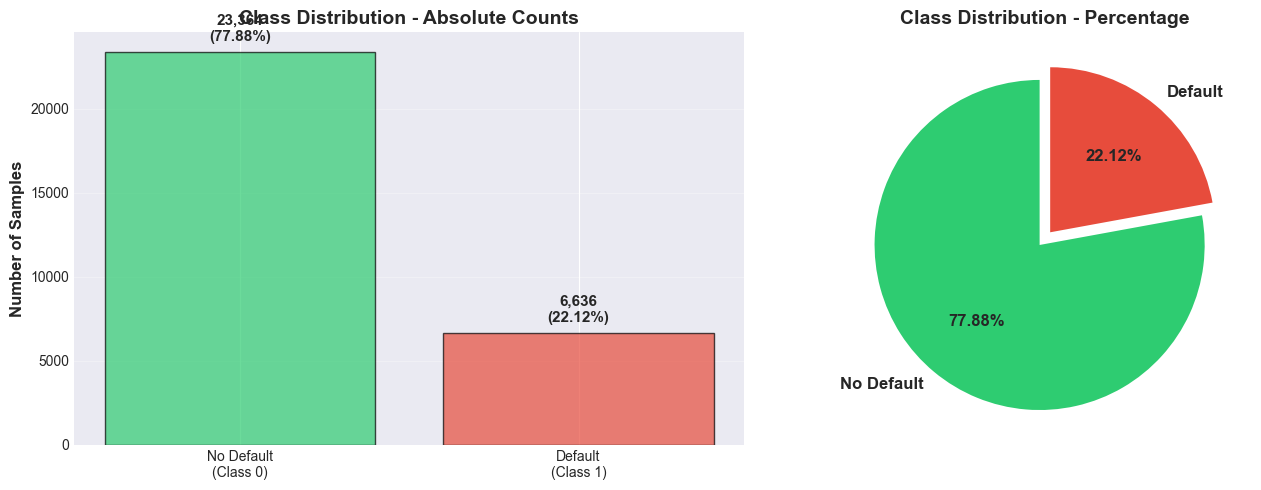

🔍 KEY INSIGHT:
This is a MODERATELY IMBALANCED dataset:
  • Minority class (defaulters): 22.12%
  • Majority class (non-defaulters): 77.88%

Implications:
  ✓ Not severely imbalanced (not 1% or 99%)
  ✓ Still need class-aware techniques (SMOTE, class weights)
  ✓ Accuracy alone will be misleading - need Recall, Precision, F1
  ✓ Can't use random guessing as baseline (would get 77.88% accuracy!)


In [7]:
# Analyze target variable distribution
print("="*80)
print("TARGET VARIABLE DISTRIBUTION")
print("="*80)

# Count and percentages
value_counts = pd.Series(y).value_counts().sort_index()
value_percent = pd.Series(y).value_counts(normalize=True).sort_index() * 100

print(f"Class 0 (No Default):  {value_counts[0]:,} samples ({value_percent[0]:.2f}%)")
print(f"Class 1 (Default):     {value_counts[1]:,} samples ({value_percent[1]:.2f}%)")
print()

# Calculate imbalance ratio
imbalance_ratio = value_counts[0] / value_counts[1]
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"   → For every 1 defaulter, there are {imbalance_ratio:.1f} non-defaulters")
print()

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['No Default\n(Class 0)', 'Default\n(Class 1)'], value_counts.values, 
            color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution - Absolute Counts', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(value_counts.values):
    axes[0].text(i, v + 500, f'{v:,}\n({value_percent.values[i]:.2f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
axes[1].pie(value_counts.values, labels=['No Default', 'Default'], autopct='%1.2f%%',
           colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution - Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*80)
print("🔍 KEY INSIGHT:")
print("="*80)
print("This is a MODERATELY IMBALANCED dataset:")
print(f"  • Minority class (defaulters): {value_percent[1]:.2f}%")
print(f"  • Majority class (non-defaulters): {value_percent[0]:.2f}%")
print()
print("Implications:")
print("  ✓ Not severely imbalanced (not 1% or 99%)")
print("  ✓ Still need class-aware techniques (SMOTE, class weights)")
print("  ✓ Accuracy alone will be misleading - need Recall, Precision, F1")
print("  ✓ Can't use random guessing as baseline (would get 77.88% accuracy!)")

## 2.6 Demographic Features Analysis

**Objective:** Understand the customer demographics and their relationship to defaults.

Analyzing:
- **SEX**: Gender distribution (1=male, 2=female)
- **EDUCATION**: Education levels
- **MARRIAGE**: Marital status
- **AGE**: Age distribution and patterns

In [8]:
# Analyze categorical demographic features
print("="*80)
print("DEMOGRAPHIC FEATURES - VALUE COUNTS")
print("="*80)

demo_features = ['SEX', 'EDUCATION', 'MARRIAGE']

for feature in demo_features:
    print(f"\n{feature}:")
    print("-" * 40)
    value_counts = X[feature].value_counts().sort_index()
    value_percent = X[feature].value_counts(normalize=True).sort_index() * 100
    
    for val in value_counts.index:
        print(f"  {val}: {value_counts[val]:,} ({value_percent[val]:.2f}%)")
        
    # Check for unexpected values
    if feature == 'SEX' and set(X[feature].unique()) != {1, 2}:
        print(f"  ⚠️  Unexpected values detected: {X[feature].unique()}")
    elif feature == 'EDUCATION' and not set(X[feature].unique()).issubset({1, 2, 3, 4, 5, 6}):
        print(f"  ⚠️  Unexpected values detected: {X[feature].unique()}")
    elif feature == 'MARRIAGE' and not set(X[feature].unique()).issubset({1, 2, 3}):
        print(f"  ⚠️  Unexpected values detected: {X[feature].unique()}")

DEMOGRAPHIC FEATURES - VALUE COUNTS

SEX:
----------------------------------------
  1: 11,888 (39.63%)
  2: 18,112 (60.37%)

EDUCATION:
----------------------------------------
  0: 14 (0.05%)
  1: 10,585 (35.28%)
  2: 14,030 (46.77%)
  3: 4,917 (16.39%)
  4: 123 (0.41%)
  5: 280 (0.93%)
  6: 51 (0.17%)
  ⚠️  Unexpected values detected: [2 1 3 5 4 6 0]

MARRIAGE:
----------------------------------------
  0: 54 (0.18%)
  1: 13,659 (45.53%)
  2: 15,964 (53.21%)
  3: 323 (1.08%)
  ⚠️  Unexpected values detected: [1 2 3 0]


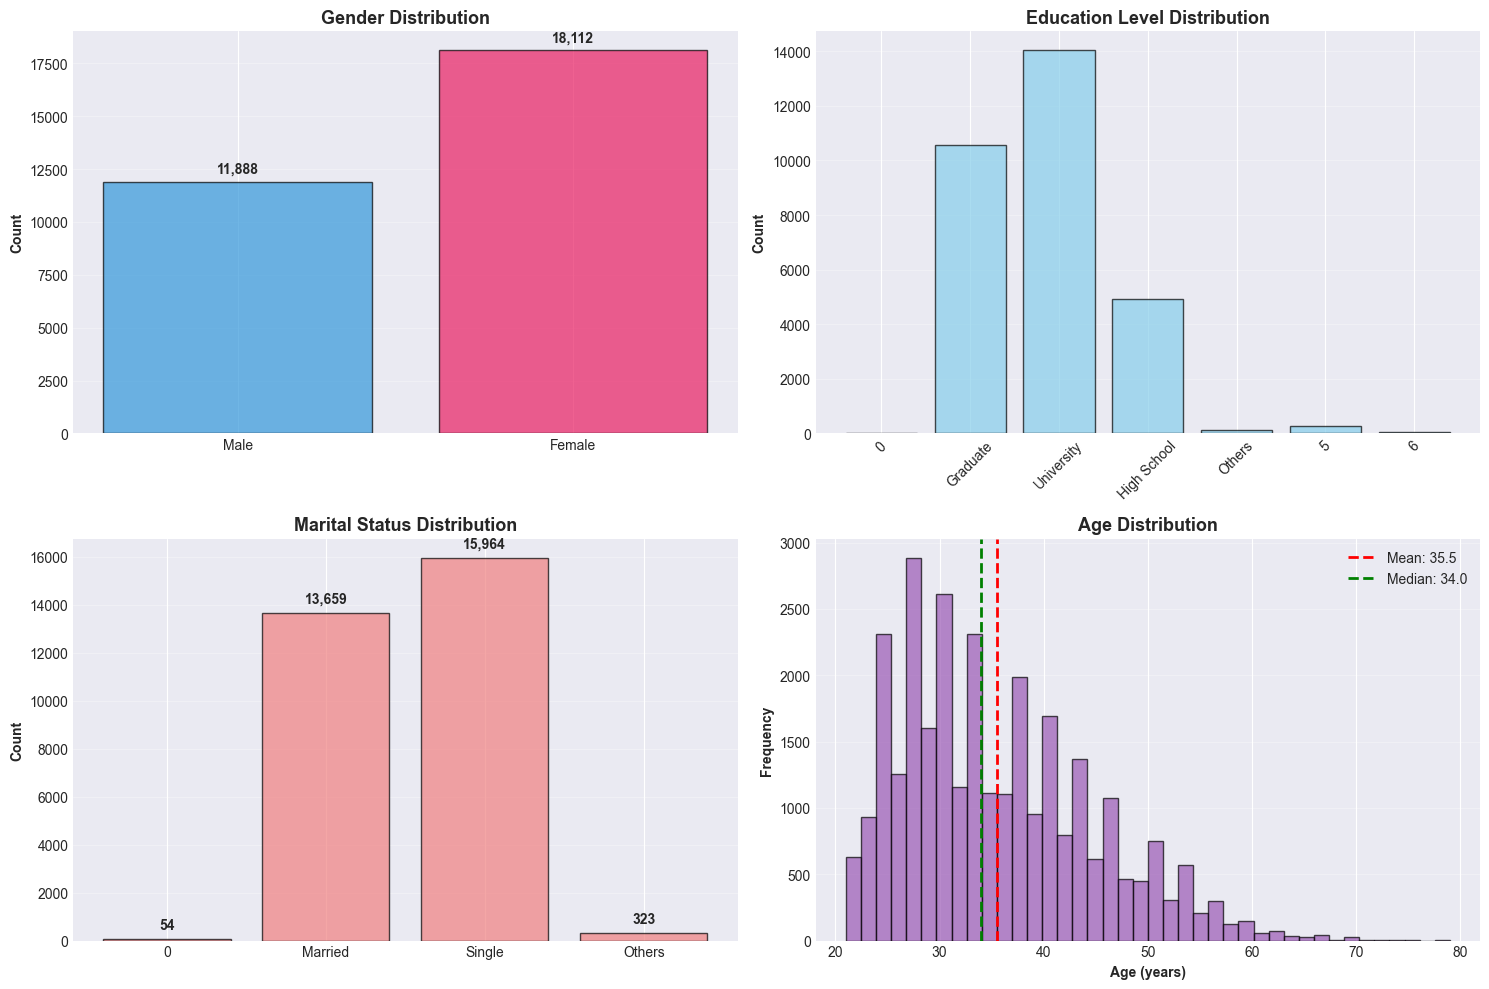

🔍 Demographic Insights:
  • Female customers: 18,112 (60.4%)
  • Male customers: 11,888 (39.6%)
  • Average age: 35.5 years
  • Age range: 21 - 79 years


In [11]:
# Visualize demographic distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gender distribution
sex_counts = X['SEX'].value_counts().sort_index()
axes[0, 0].bar(['Male', 'Female'], sex_counts.values, color=['#3498db', '#e91e63'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Gender Distribution', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(sex_counts.values):
    axes[0, 0].text(i, v + 300, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Education distribution
edu_counts = X['EDUCATION'].value_counts().sort_index()
edu_labels = ['0', 'Graduate', 'University', 'High School', 'Others', '5', '6']
axes[0, 1].bar(range(len(edu_counts)), edu_counts.values, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Education Level Distribution', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Count', fontweight='bold')
axes[0, 1].set_xticks(range(len(edu_counts)))
axes[0, 1].set_xticklabels(edu_labels[:len(edu_counts)], rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Marriage distribution
mar_counts = X['MARRIAGE'].value_counts().sort_index()
mar_labels = ['0', 'Married', 'Single', 'Others']
axes[1, 0].bar(range(len(mar_counts)), mar_counts.values, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Marital Status Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Count', fontweight='bold')
axes[1, 0].set_xticks(range(len(mar_counts)))
axes[1, 0].set_xticklabels(mar_labels[:len(mar_counts)])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(mar_counts.values):
    axes[1, 0].text(i, v + 300, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Age distribution (histogram)
axes[1, 1].hist(X['AGE'], bins=40, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(X['AGE'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {X["AGE"].mean():.1f}')
axes[1, 1].axvline(X['AGE'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {X["AGE"].median():.1f}')
axes[1, 1].set_title('Age Distribution', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Age (years)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 Demographic Insights:")
print(f"  • Female customers: {(X['SEX'] == 2).sum():,} ({(X['SEX'] == 2).sum()/len(X)*100:.1f}%)")
print(f"  • Male customers: {(X['SEX'] == 1).sum():,} ({(X['SEX'] == 1).sum()/len(X)*100:.1f}%)")
print(f"  • Average age: {X['AGE'].mean():.1f} years")
print(f"  • Age range: {X['AGE'].min():.0f} - {X['AGE'].max():.0f} years")

## 2.7 Credit Limit Analysis

**Business Significance:** Credit limit (LIMIT_BAL) is the total approved credit amount. 

Key questions:
- What is the distribution of credit limits?
- Are there any unusual patterns or outliers?
- How does credit limit relate to defaults?

In [12]:
# Analyze credit limit distribution
print("="*80)
print("CREDIT LIMIT (LIMIT_BAL) ANALYSIS")
print("="*80)

# Calculate statistics
limit_stats = X['LIMIT_BAL'].describe()
print("Statistical Summary:")
print(f"  Mean:     NT$ {limit_stats['mean']:,.0f}")
print(f"  Median:   NT$ {limit_stats['50%']:,.0f}")
print(f"  Std Dev:  NT$ {limit_stats['std']:,.0f}")
print(f"  Min:      NT$ {limit_stats['min']:,.0f}")
print(f"  Max:      NT$ {limit_stats['max']:,.0f}")
print(f"  Range:    NT$ {limit_stats['max'] - limit_stats['min']:,.0f}")
print()

# Quartiles
print("Quartiles:")
print(f"  Q1 (25%): NT$ {limit_stats['25%']:,.0f}")
print(f"  Q2 (50%): NT$ {limit_stats['50%']:,.0f}")
print(f"  Q3 (75%): NT$ {limit_stats['75%']:,.0f}")
print(f"  IQR:      NT$ {limit_stats['75%'] - limit_stats['25%']:,.0f}")
print()

# Check skewness
from scipy.stats import skew, kurtosis
skewness = skew(X['LIMIT_BAL'])
kurt = kurtosis(X['LIMIT_BAL'])
print(f"Skewness: {skewness:.3f} ({'right-skewed' if skewness > 0 else 'left-skewed'})")
print(f"Kurtosis: {kurt:.3f} ({'heavy-tailed' if kurt > 0 else 'light-tailed'})")

CREDIT LIMIT (LIMIT_BAL) ANALYSIS
Statistical Summary:
  Mean:     NT$ 167,484
  Median:   NT$ 140,000
  Std Dev:  NT$ 129,748
  Min:      NT$ 10,000
  Max:      NT$ 1,000,000
  Range:    NT$ 990,000

Quartiles:
  Q1 (25%): NT$ 50,000
  Q2 (50%): NT$ 140,000
  Q3 (75%): NT$ 240,000
  IQR:      NT$ 190,000

Skewness: 0.993 (right-skewed)
Kurtosis: 0.536 (heavy-tailed)


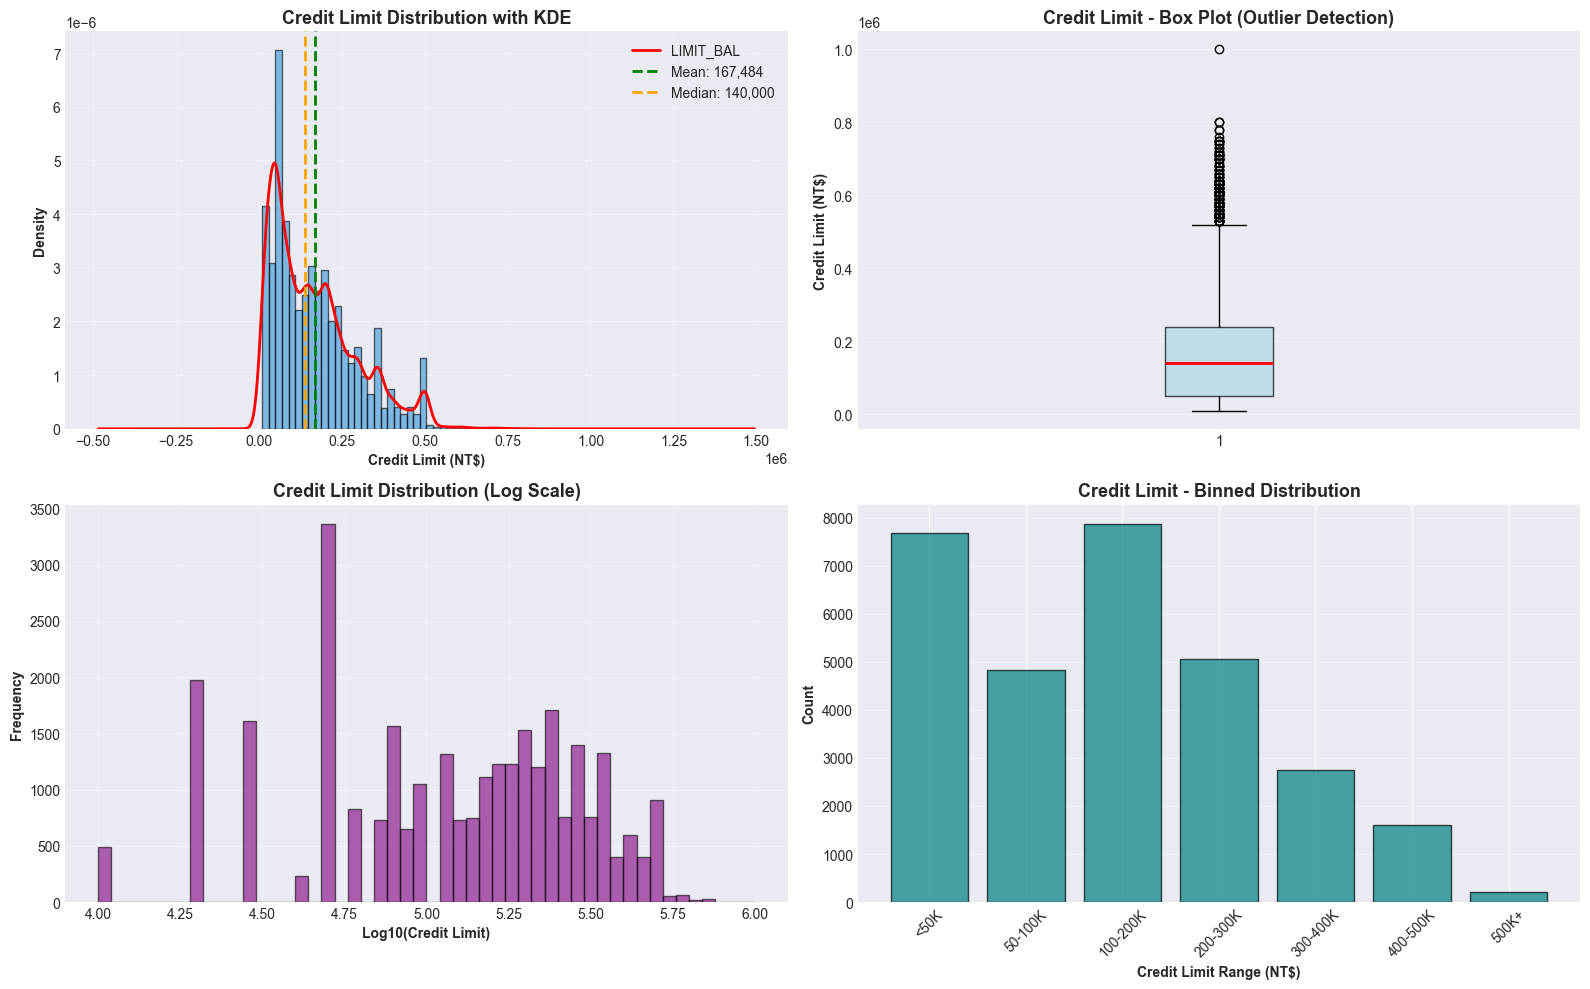

In [13]:
# Visualize credit limit distribution with multiple views
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram with KDE
axes[0, 0].hist(X['LIMIT_BAL'], bins=50, color='#3498db', alpha=0.6, edgecolor='black', density=True)
X['LIMIT_BAL'].plot(kind='kde', ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].axvline(X['LIMIT_BAL'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {X["LIMIT_BAL"].mean():,.0f}')
axes[0, 0].axvline(X['LIMIT_BAL'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {X["LIMIT_BAL"].median():,.0f}')
axes[0, 0].set_title('Credit Limit Distribution with KDE', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Credit Limit (NT$)', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot for outlier detection
axes[0, 1].boxplot(X['LIMIT_BAL'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_title('Credit Limit - Box Plot (Outlier Detection)', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Credit Limit (NT$)', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Log-scale histogram (to see lower values better)
axes[1, 0].hist(np.log10(X['LIMIT_BAL'] + 1), bins=50, color='purple', alpha=0.6, edgecolor='black')
axes[1, 0].set_title('Credit Limit Distribution (Log Scale)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Log10(Credit Limit)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Binned distribution
bins = [0, 50000, 100000, 200000, 300000, 400000, 500000, 1000000]
bin_labels = ['<50K', '50-100K', '100-200K', '200-300K', '300-400K', '400-500K', '500K+']
X['LIMIT_BIN'] = pd.cut(X['LIMIT_BAL'], bins=bins, labels=bin_labels)
bin_counts = X['LIMIT_BIN'].value_counts().sort_index()
axes[1, 1].bar(range(len(bin_counts)), bin_counts.values, color='teal', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Credit Limit - Binned Distribution', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Credit Limit Range (NT$)', fontweight='bold')
axes[1, 1].set_ylabel('Count', fontweight='bold')
axes[1, 1].set_xticks(range(len(bin_counts)))
axes[1, 1].set_xticklabels(bin_labels, rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Clean up temporary column
X = X.drop('LIMIT_BIN', axis=1)

## 2.8 Outlier Detection and Treatment Strategy 

**Why Critical?** Outliers can:
- Skew statistical measures (mean, standard deviation)
- Disproportionately influence model training
- Indicate data quality issues OR genuine extreme cases

**Detection Methods:**
1. **IQR Method**: Values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR
2. **Z-Score Method**: Values beyond ±3 standard deviations
3. **Domain Knowledge**: Business rules (e.g., negative bill amounts)

In [14]:
# Outlier detection using IQR method
print("="*80)
print("OUTLIER DETECTION - IQR METHOD")
print("="*80)

numerical_features = ['LIMIT_BAL', 'AGE'] + \
                     [f'BILL_AMT{i}' for i in range(1, 7)] + \
                     [f'PAY_AMT{i}' for i in range(1, 7)]

outlier_summary = []

for feature in numerical_features:
    Q1 = X[feature].quantile(0.25)
    Q3 = X[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = X[(X[feature] < lower_bound) | (X[feature] > upper_bound)][feature]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(X)) * 100
    
    if outlier_count > 0:
        outlier_summary.append({
            'Feature': feature,
            'Outlier_Count': outlier_count,
            'Outlier_Percent': f'{outlier_percent:.2f}%',
            'Lower_Bound': f'{lower_bound:,.0f}',
            'Upper_Bound': f'{upper_bound:,.0f}',
            'Min_Outlier': f'{outliers.min():,.0f}',
            'Max_Outlier': f'{outliers.max():,.0f}'
        })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

print()
print("🔍 Outlier Insights:")
print(f"  • Features with outliers: {len(outlier_df)}/{len(numerical_features)}")
print(f"  • Most affected feature: {outlier_df.iloc[0]['Feature'] if len(outlier_df) > 0 else 'None'}")
print()
print("📋 Treatment Strategy:")
print("  1. Keep outliers for demographics (AGE, LIMIT_BAL) - legitimate values")
print("  2. Cap outliers for BILL_AMT and PAY_AMT at 99th percentile")
print("  3. Domain validation: negative bills are valid (credits/refunds)")

OUTLIER DETECTION - IQR METHOD


,Feature,Outlier_Count,Outlier_Percent,Lower_Bound,Upper_Bound,Min_Outlier,Max_Outlier
0,LIMIT_BAL,167,0.56%,"-235,000","525,000","530,000","1,000,000"
1,AGE,272,0.91%,8,60,61,79
2,BILL_AMT1,2400,8.00%,"-91,740","162,389","-165,580","964,511"
3,BILL_AMT2,2395,7.98%,"-88,548","155,538","155,635","983,931"
4,BILL_AMT3,2469,8.23%,"-83,582","146,412","-157,264","1,664,089"
5,BILL_AMT4,2622,8.74%,"-75,942","132,775","-170,000","891,586"
6,BILL_AMT5,2725,9.08%,"-70,878","122,832","-81,334","927,171"
7,BILL_AMT6,2693,8.98%,"-70,657","121,112","-339,603","961,664"
8,PAY_AMT1,2745,9.15%,"-5,009","11,015","11,016","873,552"
9,PAY_AMT2,2714,9.05%,"-5,418","11,250","11,253","1,684,259"



🔍 Outlier Insights:
  • Features with outliers: 14/14
  • Most affected feature: LIMIT_BAL

📋 Treatment Strategy:
  1. Keep outliers for demographics (AGE, LIMIT_BAL) - legitimate values
  2. Cap outliers for BILL_AMT and PAY_AMT at 99th percentile
  3. Domain validation: negative bills are valid (credits/refunds)


## 2.9 Payment Status Pattern Analysis

**Most Predictive Features:** Payment status (PAY_0 to PAY_6) shows repayment behavior over 6 months.

Values meaning:
- **-1**: Paid duly (on time)
- **0**: Use of revolving credit (minimum payment)
- **1-9**: Months of payment delay

This temporal sequence reveals payment deterioration patterns.

In [16]:
# Payment Status Distribution Analysis
# PAY_0 to PAY_6: Repayment status from April to September
# -1 = pay duly, 1 = payment delay for one month, 2 = delay for two months, etc.

pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

print("=" * 80)
print("PAYMENT STATUS DISTRIBUTION (PAY_0 to PAY_6)")
print("=" * 80)
print("\nStatus Key:")
print("  -2 = Balance paid in full and no transactions")
print("  -1 = Paid duly (on time)")
print("   0 = Use of revolving credit (paid minimum due)")
print("   1 = Payment delay for 1 month")
print("   2+ = Payment delay for 2+ months")
print("\n")

for pay_col in pay_features:
    print(f"\n{pay_col} Distribution:")
    value_counts = X[pay_col].value_counts().sort_index()
    for status, count in value_counts.items():
        percent = (count / len(X)) * 100
        print(f"  Status {status:2d}: {count:6,} ({percent:5.2f}%)")
    
print("\n" + "=" * 80)
print("🔍 Key Observations:")
print("  • Negative values (-2, -1) indicate good payment behavior")
print("  • Positive values (1-9) indicate payment delays")
print("  • Status 0 = revolving credit use (neither good nor bad)")
print("=" * 80)

PAYMENT STATUS DISTRIBUTION (PAY_0 to PAY_6)

Status Key:
  -2 = Balance paid in full and no transactions
  -1 = Paid duly (on time)
   0 = Use of revolving credit (paid minimum due)
   1 = Payment delay for 1 month
   2+ = Payment delay for 2+ months



PAY_0 Distribution:
  Status -2:  2,759 ( 9.20%)
  Status -1:  5,686 (18.95%)
  Status  0: 14,737 (49.12%)
  Status  1:  3,688 (12.29%)
  Status  2:  2,667 ( 8.89%)
  Status  3:    322 ( 1.07%)
  Status  4:     76 ( 0.25%)
  Status  5:     26 ( 0.09%)
  Status  6:     11 ( 0.04%)
  Status  7:      9 ( 0.03%)
  Status  8:     19 ( 0.06%)

PAY_2 Distribution:
  Status -2:  3,782 (12.61%)
  Status -1:  6,050 (20.17%)
  Status  0: 15,730 (52.43%)
  Status  1:     28 ( 0.09%)
  Status  2:  3,927 (13.09%)
  Status  3:    326 ( 1.09%)
  Status  4:     99 ( 0.33%)
  Status  5:     25 ( 0.08%)
  Status  6:     12 ( 0.04%)
  Status  7:     20 ( 0.07%)
  Status  8:      1 ( 0.00%)

PAY_3 Distribution:
  Status -2:  4,085 (13.62%)
  Status -1:  5,

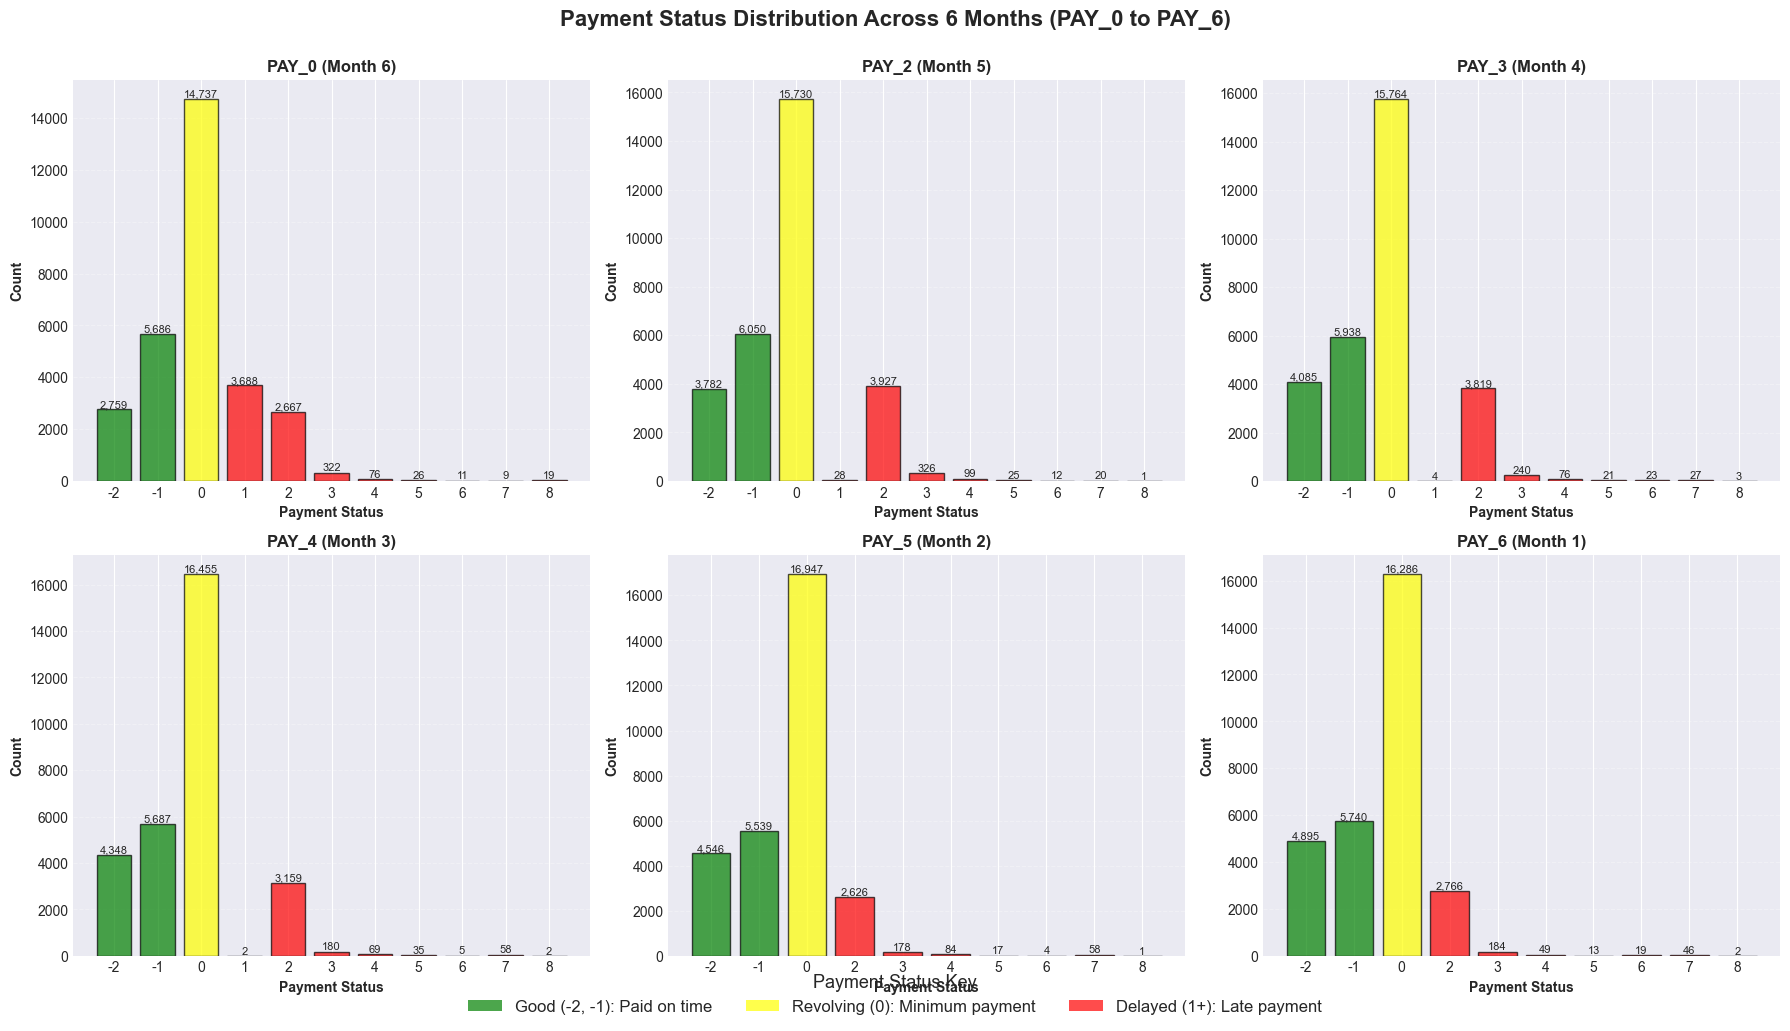

📊 Visualization Insight:
  • Green bars = On-time payments (desired behavior)
  • Yellow bars = Revolving credit usage (neutral)
  • Red bars = Late payments (risk indicator)


In [17]:
# Payment Status Visualization - Distribution by Month
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Payment Status Distribution Across 6 Months (PAY_0 to PAY_6)', 
             fontsize=16, fontweight='bold', y=1.00)

pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for idx, pay_col in enumerate(pay_features):
    ax = axes[idx // 3, idx % 3]
    
    # Get value counts and prepare data
    value_counts = X[pay_col].value_counts().sort_index()
    statuses = value_counts.index.tolist()
    counts = value_counts.values.tolist()
    
    # Color coding: green for good (-2,-1), yellow for revolving (0), red for delays (1+)
    colors = ['green' if s < 0 else 'yellow' if s == 0 else 'red' for s in statuses]
    
    # Create bar plot
    bars = ax.bar(range(len(statuses)), counts, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(statuses)))
    ax.set_xticklabels(statuses, rotation=0)
    ax.set_xlabel('Payment Status', fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title(f'{pay_col} (Month {6-idx})', fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=8)

# Add legend in figure
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Good (-2, -1): Paid on time'),
    Patch(facecolor='yellow', alpha=0.7, label='Revolving (0): Minimum payment'),
    Patch(facecolor='red', alpha=0.7, label='Delayed (1+): Late payment')
]
fig.legend(handles=legend_elements, loc='lower center', fontsize=12, 
           title='Payment Status Key', title_fontsize=13, ncol=3, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.show()

print("📊 Visualization Insight:")
print("  • Green bars = On-time payments (desired behavior)")
print("  • Yellow bars = Revolving credit usage (neutral)")
print("  • Red bars = Late payments (risk indicator)")

In [23]:
# Payment Deterioration Analysis
# Track how payment behavior changes over time (worsens or improves)

print("=" * 80)
print("PAYMENT BEHAVIOR TRENDS (6-Month Window)")
print("=" * 80)

# Calculate average payment status per month
pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
avg_pay_status = X[pay_features].mean()

# Calculate percentage of delayed payments (status >= 1) per month
delayed_pct = (X[pay_features] >= 1).sum() / len(X) * 100

# Calculate percentage of on-time payments (status < 0) per month
ontime_pct = (X[pay_features] < 0).sum() / len(X) * 100

print("\nAverage Payment Status by Month:")
month_map = {1: 6, 2: 5, 3: 4, 4: 3, 5: 2, 6: 1}
for month, avg in enumerate(avg_pay_status, 1):
    print(f"  Month {month_map[month]} ({pay_features[month-1]}): {avg:.3f}")

print("\n" + "-" * 80)
print("\nPercentage of Customers with Delayed Payments (Status >= 1):")
for month, pct in enumerate(delayed_pct, 1):
    print(f"  Month {month_map[month]} ({pay_features[month-1]}): {pct:.2f}%")

print("\n" + "-" * 80)
print("\nPercentage of Customers with On-Time Payments (Status < 0):")
for month, pct in enumerate(ontime_pct, 1):
    print(f"  Month {month_map[month]} ({pay_features[month-1]}): {pct:.2f}%")

# Trend analysis
pay_trend = avg_pay_status.iloc[-1] - avg_pay_status.iloc[0]
print("\n" + "=" * 80)
print("🔍 Trend Insight:")
if pay_trend > 0.1:
    print("  • Payment behavior is DETERIORATING (increasing delays over time)")
elif pay_trend < -0.1:
    print("  • Payment behavior is IMPROVING (decreasing delays over time)")
else:
    print("  • Payment behavior is STABLE (no significant trend)")
print(f"  • Trend coefficient: {pay_trend:.3f}")
print("=" * 80)

PAYMENT BEHAVIOR TRENDS (6-Month Window)

Average Payment Status by Month:
  Month 6 (PAY_0): -0.017
  Month 5 (PAY_2): -0.134
  Month 4 (PAY_3): -0.166
  Month 3 (PAY_4): -0.221
  Month 2 (PAY_5): -0.266
  Month 1 (PAY_6): -0.291

--------------------------------------------------------------------------------

Percentage of Customers with Delayed Payments (Status >= 1):
  Month 6 (PAY_0): 22.73%
  Month 5 (PAY_2): 14.79%
  Month 4 (PAY_3): 14.04%
  Month 3 (PAY_4): 11.70%
  Month 2 (PAY_5): 9.89%
  Month 1 (PAY_6): 10.26%

--------------------------------------------------------------------------------

Percentage of Customers with On-Time Payments (Status < 0):
  Month 6 (PAY_0): 28.15%
  Month 5 (PAY_2): 32.77%
  Month 4 (PAY_3): 33.41%
  Month 3 (PAY_4): 33.45%
  Month 2 (PAY_5): 33.62%
  Month 1 (PAY_6): 35.45%

🔍 Trend Insight:
  • Payment behavior is IMPROVING (decreasing delays over time)
  • Trend coefficient: -0.274


## 2.10 Bill Amount Analysis

Bill statements (BILL_AMT1 to BILL_AMT6) represent the amount of credit used each month. Negative values indicate overpayment or credits. This section analyzes spending patterns and credit utilization.

In [19]:
# Bill Amount Statistical Analysis
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

print("=" * 80)
print("BILL AMOUNT STATISTICS (6-Month Analysis)")
print("=" * 80)

bill_stats = X[bill_features].describe().T
bill_stats['median'] = X[bill_features].median()
bill_stats['skewness'] = X[bill_features].skew()
bill_stats['kurtosis'] = X[bill_features].kurtosis()

print("\nSummary Statistics:")
print(bill_stats[['mean', 'median', 'std', 'min', 'max']].to_string())

print("\n" + "-" * 80)
print("\nDistribution Characteristics:")
print(bill_stats[['skewness', 'kurtosis']].to_string())

# Calculate average credit utilization
avg_utilization = (X[bill_features].mean(axis=1) / X['LIMIT_BAL'] * 100)
print("\n" + "-" * 80)
print("\nCredit Utilization Analysis:")
print(f"  Mean Utilization:   {avg_utilization.mean():.2f}%")
print(f"  Median Utilization: {avg_utilization.median():.2f}%")
print(f"  High Utilization (>70%): {(avg_utilization > 70).sum():,} customers ({(avg_utilization > 70).sum()/len(X)*100:.2f}%)")
print(f"  Low Utilization (<30%): {(avg_utilization < 30).sum():,} customers ({(avg_utilization < 30).sum()/len(X)*100:.2f}%)")

# Trend in bills over time
bill_trend = X[bill_features].mean()
print("\n" + "-" * 80)
print("\nBill Amount Trends (Last 6 Months):")
for idx, (month, avg_bill) in enumerate(bill_trend.items(), 1):
    print(f"  Month {7-idx} ({month}): NT$ {avg_bill:,.0f}")

change = ((bill_trend.iloc[-1] - bill_trend.iloc[0]) / bill_trend.iloc[0]) * 100
print(f"\n📊 Overall Trend: {change:+.2f}% change from oldest to most recent month")
print("=" * 80)

BILL AMOUNT STATISTICS (6-Month Analysis)

Summary Statistics:
                mean     median        std          min          max
BILL_AMT1 51223.3309 22381.5000 73635.8606 -165580.0000  964511.0000
BILL_AMT2 49179.0752 21200.0000 71173.7688  -69777.0000  983931.0000
BILL_AMT3 47013.1548 20088.5000 69349.3874 -157264.0000 1664089.0000
BILL_AMT4 43262.9490 19052.0000 64332.8561 -170000.0000  891586.0000
BILL_AMT5 40311.4010 18104.5000 60797.1558  -81334.0000  927171.0000
BILL_AMT6 38871.7604 17071.0000 59554.1075 -339603.0000  961664.0000

--------------------------------------------------------------------------------

Distribution Characteristics:
           skewness  kurtosis
BILL_AMT1    2.6639    9.8063
BILL_AMT2    2.7052   10.3029
BILL_AMT3    3.0878   19.7833
BILL_AMT4    2.8220   11.3093
BILL_AMT5    2.8764   12.3059
BILL_AMT6    2.8466   12.2707

--------------------------------------------------------------------------------

Credit Utilization Analysis:
  Mean Utilization:

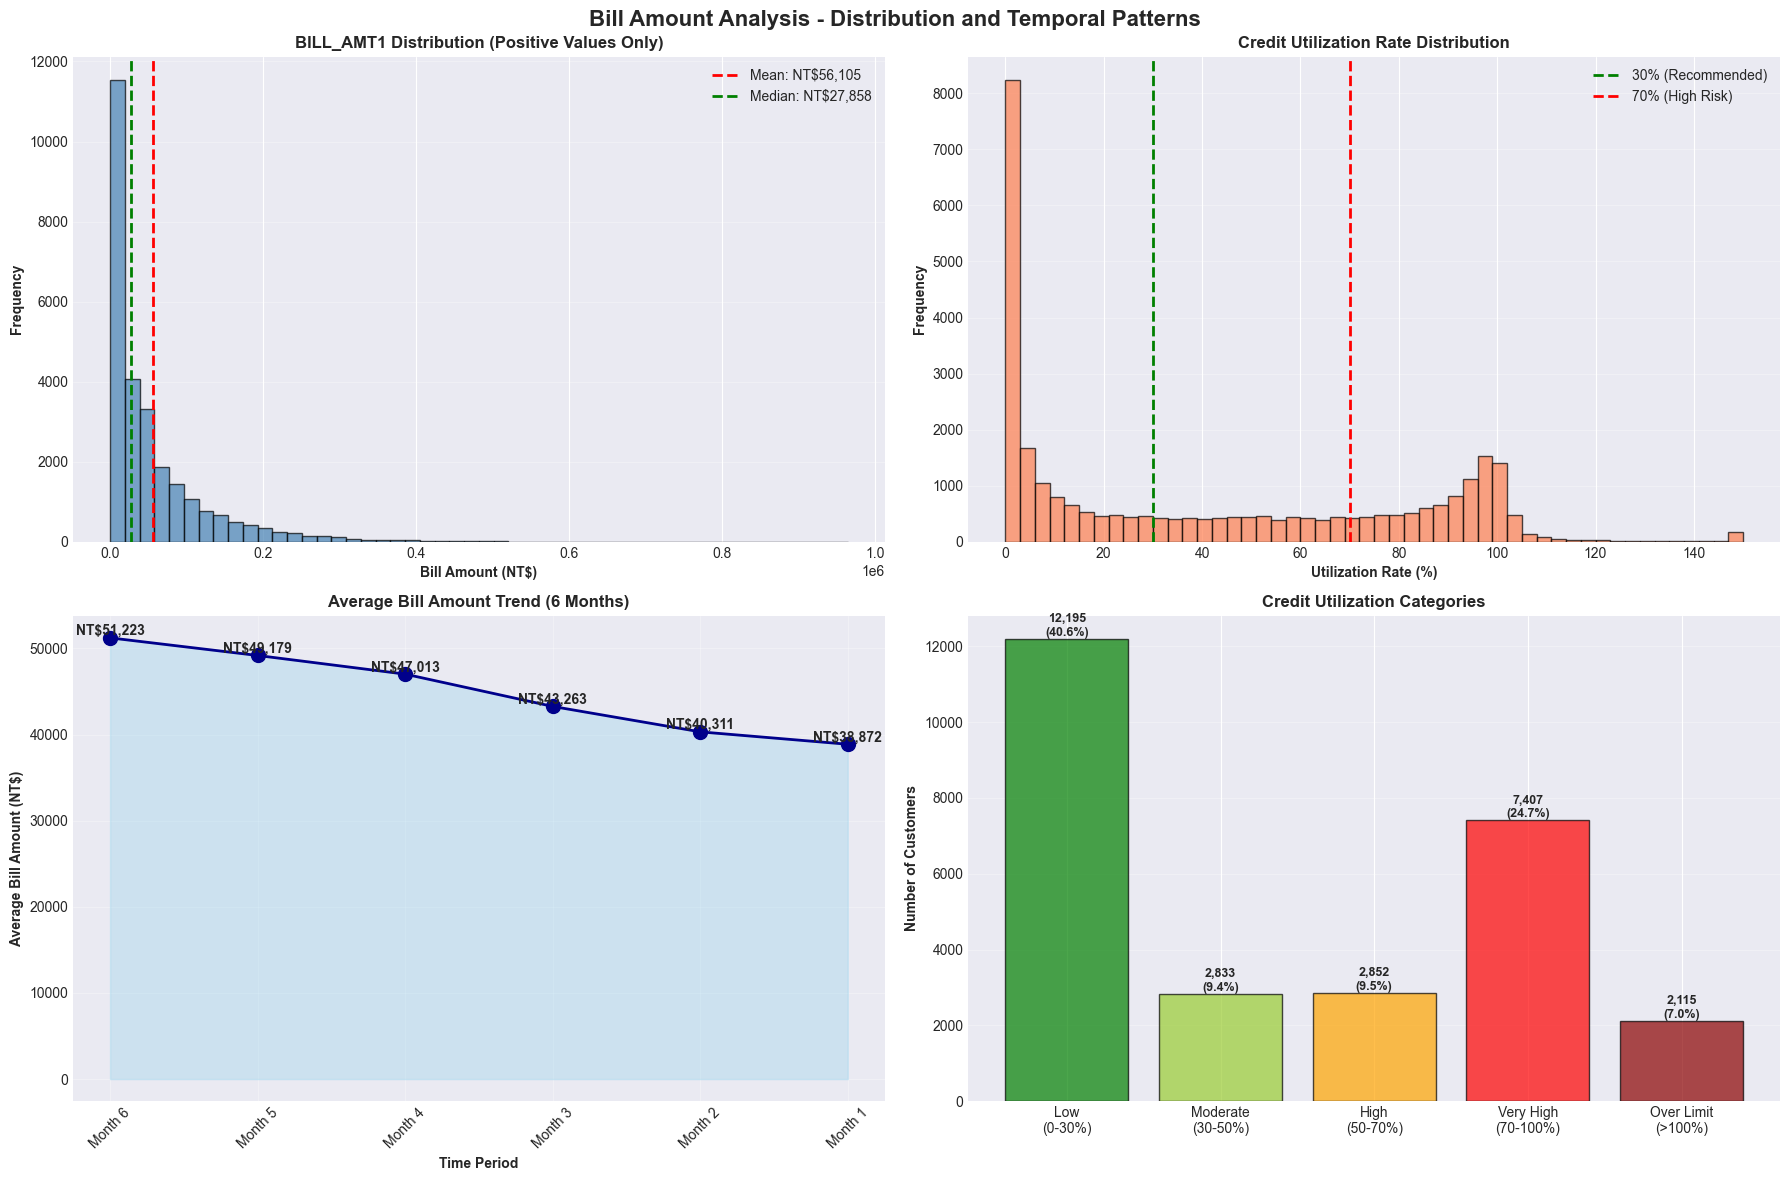

🔍 Bill Amount Insights:
  • Average bill: NT$ 51,223
  • 9,522 customers (31.7%) have high utilization (>70%)
  • High utilization is a strong default risk indicator


In [21]:
# Bill Amount Visualization - Distribution and Trends
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Bill Amount Analysis - Distribution and Temporal Patterns', 
             fontsize=16, fontweight='bold')

# 1. Distribution of most recent bill (BILL_AMT1)
ax1 = axes[0, 0]
bill_amt1_positive = X[X['BILL_AMT1'] > 0]['BILL_AMT1']
ax1.hist(bill_amt1_positive, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(bill_amt1_positive.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: NT${bill_amt1_positive.mean():,.0f}')
ax1.axvline(bill_amt1_positive.median(), color='green', linestyle='--', linewidth=2, label=f'Median: NT${bill_amt1_positive.median():,.0f}')
ax1.set_xlabel('Bill Amount (NT$)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('BILL_AMT1 Distribution (Positive Values Only)', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Credit Utilization Rate Distribution
ax2 = axes[0, 1]
utilization = (X['BILL_AMT1'] / X['LIMIT_BAL'] * 100).clip(0, 150)
ax2.hist(utilization, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(30, color='green', linestyle='--', linewidth=2, label='30% (Recommended)')
ax2.axvline(70, color='red', linestyle='--', linewidth=2, label='70% (High Risk)')
ax2.set_xlabel('Utilization Rate (%)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Credit Utilization Rate Distribution', fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Bill Amount Trend Over Time
ax3 = axes[1, 0]
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
bill_means = X[bill_features].mean()
months = ['Month 6', 'Month 5', 'Month 4', 'Month 3', 'Month 2', 'Month 1']
ax3.plot(months, bill_means.values, marker='o', linewidth=2, markersize=10, color='darkblue')
ax3.fill_between(range(len(months)), bill_means.values, alpha=0.3, color='skyblue')
ax3.set_xlabel('Time Period', fontweight='bold')
ax3.set_ylabel('Average Bill Amount (NT$)', fontweight='bold')
ax3.set_title('Average Bill Amount Trend (6 Months)', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Add value labels
for i, (month, value) in enumerate(zip(months, bill_means.values)):
    ax3.text(i, value, f'NT${value:,.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Utilization Rate by Category
ax4 = axes[1, 1]
util_categories = pd.cut(utilization, bins=[0, 30, 50, 70, 100, 200], 
                         labels=['Low\n(0-30%)', 'Moderate\n(30-50%)', 'High\n(50-70%)', 
                                'Very High\n(70-100%)', 'Over Limit\n(>100%)'])
util_counts = util_categories.value_counts().sort_index()
colors_util = ['green', 'yellowgreen', 'orange', 'red', 'darkred']
bars = ax4.bar(range(len(util_counts)), util_counts.values, color=colors_util, 
               edgecolor='black', alpha=0.7)
ax4.set_xticks(range(len(util_counts)))
ax4.set_xticklabels(util_counts.index, fontsize=10)
ax4.set_ylabel('Number of Customers', fontweight='bold')
ax4.set_title('Credit Utilization Categories', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(X)*100:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("🔍 Bill Amount Insights:")
print(f"  • Average bill: NT$ {X['BILL_AMT1'].mean():,.0f}")
print(f"  • {(utilization > 70).sum():,} customers ({(utilization > 70).sum()/len(X)*100:.1f}%) have high utilization (>70%)")
print(f"  • High utilization is a strong default risk indicator")

## 2.11 Payment Amount Analysis

Payment amounts (PAY_AMT1 to PAY_AMT6) represent how much customers paid toward their bills each month. Analyzing payment ratios and consistency reveals repayment behavior patterns.

In [22]:
# Payment Amount Statistical Analysis
pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

print("=" * 80)
print("PAYMENT AMOUNT STATISTICS")
print("=" * 80)

# Basic statistics
pay_stats = X[pay_amt_features].describe().T
print("\nPayment Amount Summary:")
print(pay_stats[['mean', 'std', 'min', '50%', 'max']].to_string())

# Calculate payment ratio (payment / bill)
# Only for positive bills to avoid division issues
payment_ratios = []
for i in range(6):
    pay_col = pay_amt_features[i]
    bill_col = bill_features[i]
    
    # Calculate ratio only for positive bills
    mask = X[bill_col] > 0
    ratio = (X.loc[mask, pay_col] / X.loc[mask, bill_col] * 100).clip(0, 200)
    payment_ratios.append(ratio)
    
    avg_ratio = ratio.mean()
    median_ratio = ratio.median()
    
    # Count full payment (ratio >= 100%)
    full_payment = (ratio >= 100).sum()
    full_payment_pct = (full_payment / len(ratio)) * 100
    
    print(f"\n{pay_col} / {bill_col} Ratio:")
    print(f"  Average: {avg_ratio:.2f}%")
    print(f"  Median:  {median_ratio:.2f}%")
    print(f"  Full payment (≥100%): {full_payment:,} ({full_payment_pct:.2f}%)")

# Zero payment analysis
print("\n" + "-" * 80)
print("\nZero Payment Analysis (No Payment Made):")
for pay_col in pay_amt_features:
    zero_count = (X[pay_col] == 0).sum()
    zero_pct = (zero_count / len(X)) * 100
    print(f"  {pay_col}: {zero_count:,} customers ({zero_pct:.2f}%) made $0 payment")

print("\n" + "=" * 80)
print("🔍 Payment Behavior Insights:")
print("  • Payment ratios <100% indicate partial/minimum payments")
print("  • Payment ratios ≥100% indicate full payment or overpayment")
print("  • Zero payments may indicate skip/missed payments")
print("=" * 80)

PAYMENT AMOUNT STATISTICS

Payment Amount Summary:
              mean        std    min       50%          max
PAY_AMT1 5663.5805 16563.2804 0.0000 2100.0000  873552.0000
PAY_AMT2 5921.1635 23040.8704 0.0000 2009.0000 1684259.0000
PAY_AMT3 5225.6815 17606.9615 0.0000 1800.0000  896040.0000
PAY_AMT4 4826.0769 15666.1597 0.0000 1500.0000  621000.0000
PAY_AMT5 4799.3876 15278.3057 0.0000 1500.0000  426529.0000
PAY_AMT6 5215.5026 17777.4658 0.0000 1500.0000  528666.0000

PAY_AMT1 / BILL_AMT1 Ratio:
  Average: 33.52%
  Median:  6.11%
  Full payment (≥100%): 3,871 (14.13%)

PAY_AMT2 / BILL_AMT2 Ratio:
  Average: 33.75%
  Median:  6.00%
  Full payment (≥100%): 3,857 (14.38%)

PAY_AMT3 / BILL_AMT3 Ratio:
  Average: 31.61%
  Median:  4.85%
  Full payment (≥100%): 3,630 (13.71%)

PAY_AMT4 / BILL_AMT4 Ratio:
  Average: 29.36%
  Median:  4.21%
  Full payment (≥100%): 3,344 (12.80%)

PAY_AMT5 / BILL_AMT5 Ratio:
  Average: 31.78%
  Median:  4.55%
  Full payment (≥100%): 3,559 (13.77%)

PAY_AMT6 / BI

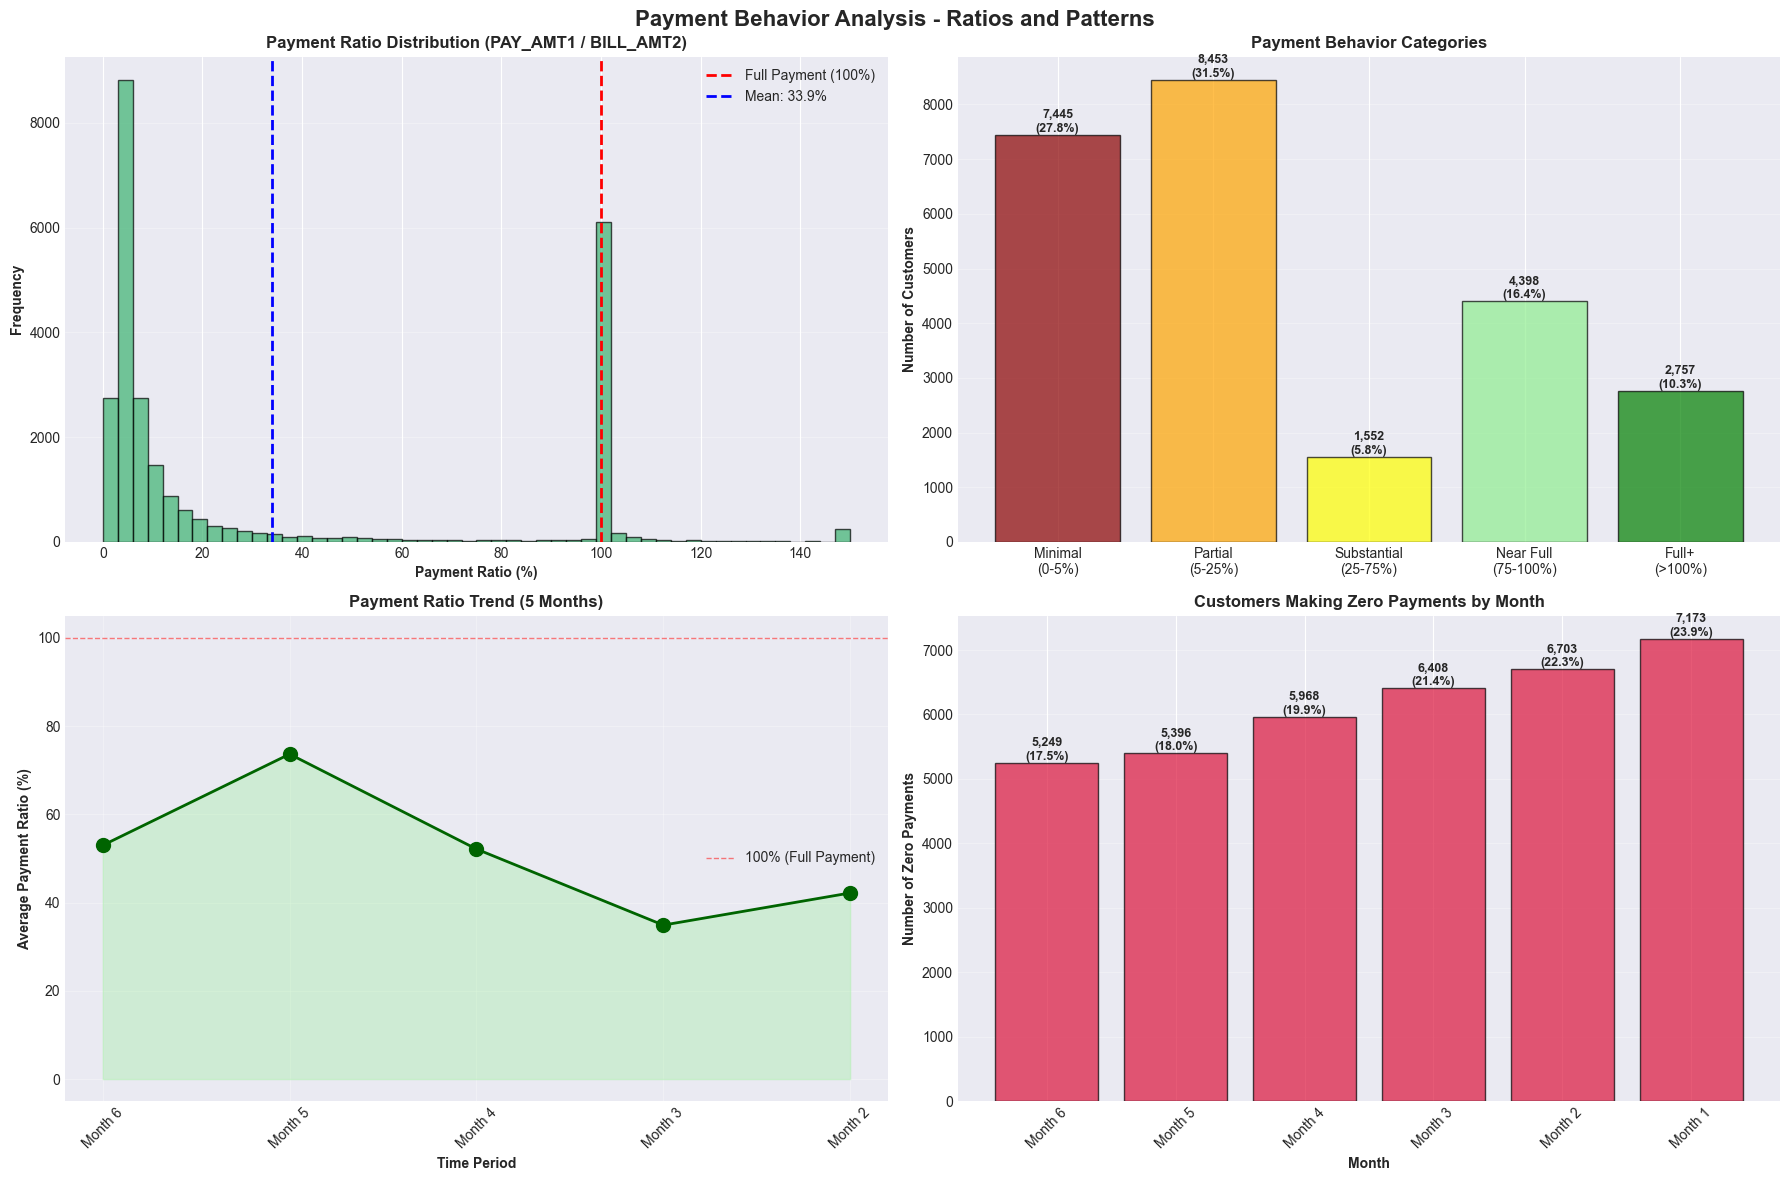

📊 Payment Pattern Insights:
  • Average payment ratio: 33.9%
  • 6,823 customers (25.4%) pay in full
  • 18,116 customers (67.5%) make minimal payments (<25%)


In [24]:
# Payment Ratio Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Payment Behavior Analysis - Ratios and Patterns', 
             fontsize=16, fontweight='bold')

# 1. Payment Ratio Distribution (PAY_AMT1 / BILL_AMT1)
ax1 = axes[0, 0]
mask = X['BILL_AMT2'] > 0  # Use previous month's bill
pay_ratio = (X.loc[mask, 'PAY_AMT1'] / X.loc[mask, 'BILL_AMT2'] * 100).clip(0, 150)
ax1.hist(pay_ratio, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
ax1.axvline(100, color='red', linestyle='--', linewidth=2, label='Full Payment (100%)')
ax1.axvline(pay_ratio.mean(), color='blue', linestyle='--', linewidth=2, 
            label=f'Mean: {pay_ratio.mean():.1f}%')
ax1.set_xlabel('Payment Ratio (%)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Payment Ratio Distribution (PAY_AMT1 / BILL_AMT2)', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Payment Categories
ax2 = axes[0, 1]
pay_categories = pd.cut(pay_ratio, 
                        bins=[0, 5, 25, 75, 100, 150],
                        labels=['Minimal\n(0-5%)', 'Partial\n(5-25%)', 
                               'Substantial\n(25-75%)', 'Near Full\n(75-100%)', 
                               'Full+\n(>100%)'])
cat_counts = pay_categories.value_counts().sort_index()
colors = ['darkred', 'orange', 'yellow', 'lightgreen', 'green']
bars = ax2.bar(range(len(cat_counts)), cat_counts.values, color=colors, 
               edgecolor='black', alpha=0.7)
ax2.set_xticks(range(len(cat_counts)))
ax2.set_xticklabels(cat_counts.index)
ax2.set_ylabel('Number of Customers', fontweight='bold')
ax2.set_title('Payment Behavior Categories', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(pay_ratio)*100:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Average Payment Ratio Trend Over 6 Months
ax3 = axes[1, 0]
avg_ratios = []
months = ['Month 6', 'Month 5', 'Month 4', 'Month 3', 'Month 2', 'Month 1']
for i in range(6):
    if i < 5:  # Can't calculate ratio for oldest month (no previous bill)
        pay_col = pay_amt_features[i]
        bill_col = bill_features[i+1]
        mask = X[bill_col] > 0
        ratio = (X.loc[mask, pay_col] / X.loc[mask, bill_col] * 100).mean()
        avg_ratios.append(ratio)
    else:
        avg_ratios.append(None)

# Plot only months with data
valid_months = months[:-1]
valid_ratios = avg_ratios[:-1]
ax3.plot(valid_months, valid_ratios, marker='o', linewidth=2, markersize=10, color='darkgreen')
ax3.axhline(100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='100% (Full Payment)')
ax3.fill_between(range(len(valid_months)), valid_ratios, alpha=0.3, color='lightgreen')
ax3.set_xlabel('Time Period', fontweight='bold')
ax3.set_ylabel('Average Payment Ratio (%)', fontweight='bold')
ax3.set_title('Payment Ratio Trend (5 Months)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Zero Payment Frequency
ax4 = axes[1, 1]
zero_payments = [(X[col] == 0).sum() for col in pay_amt_features]
ax4.bar(months, zero_payments, color='crimson', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Month', fontweight='bold')
ax4.set_ylabel('Number of Zero Payments', fontweight='bold')
ax4.set_title('Customers Making Zero Payments by Month', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, (month, count) in enumerate(zip(months, zero_payments)):
    ax4.text(i, count, f'{count:,}\n({count/len(X)*100:.1f}%)', 
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("📊 Payment Pattern Insights:")
print(f"  • Average payment ratio: {pay_ratio.mean():.1f}%")
print(f"  • {(pay_ratio >= 100).sum():,} customers ({(pay_ratio >= 100).sum()/len(pay_ratio)*100:.1f}%) pay in full")
print(f"  • {(pay_ratio < 25).sum():,} customers ({(pay_ratio < 25).sum()/len(pay_ratio)*100:.1f}%) make minimal payments (<25%)")

## 2.12 Correlation Analysis

Understanding relationships between features helps identify multicollinearity and feature importance. This section examines correlations among all numerical features and their relationship with the target variable.

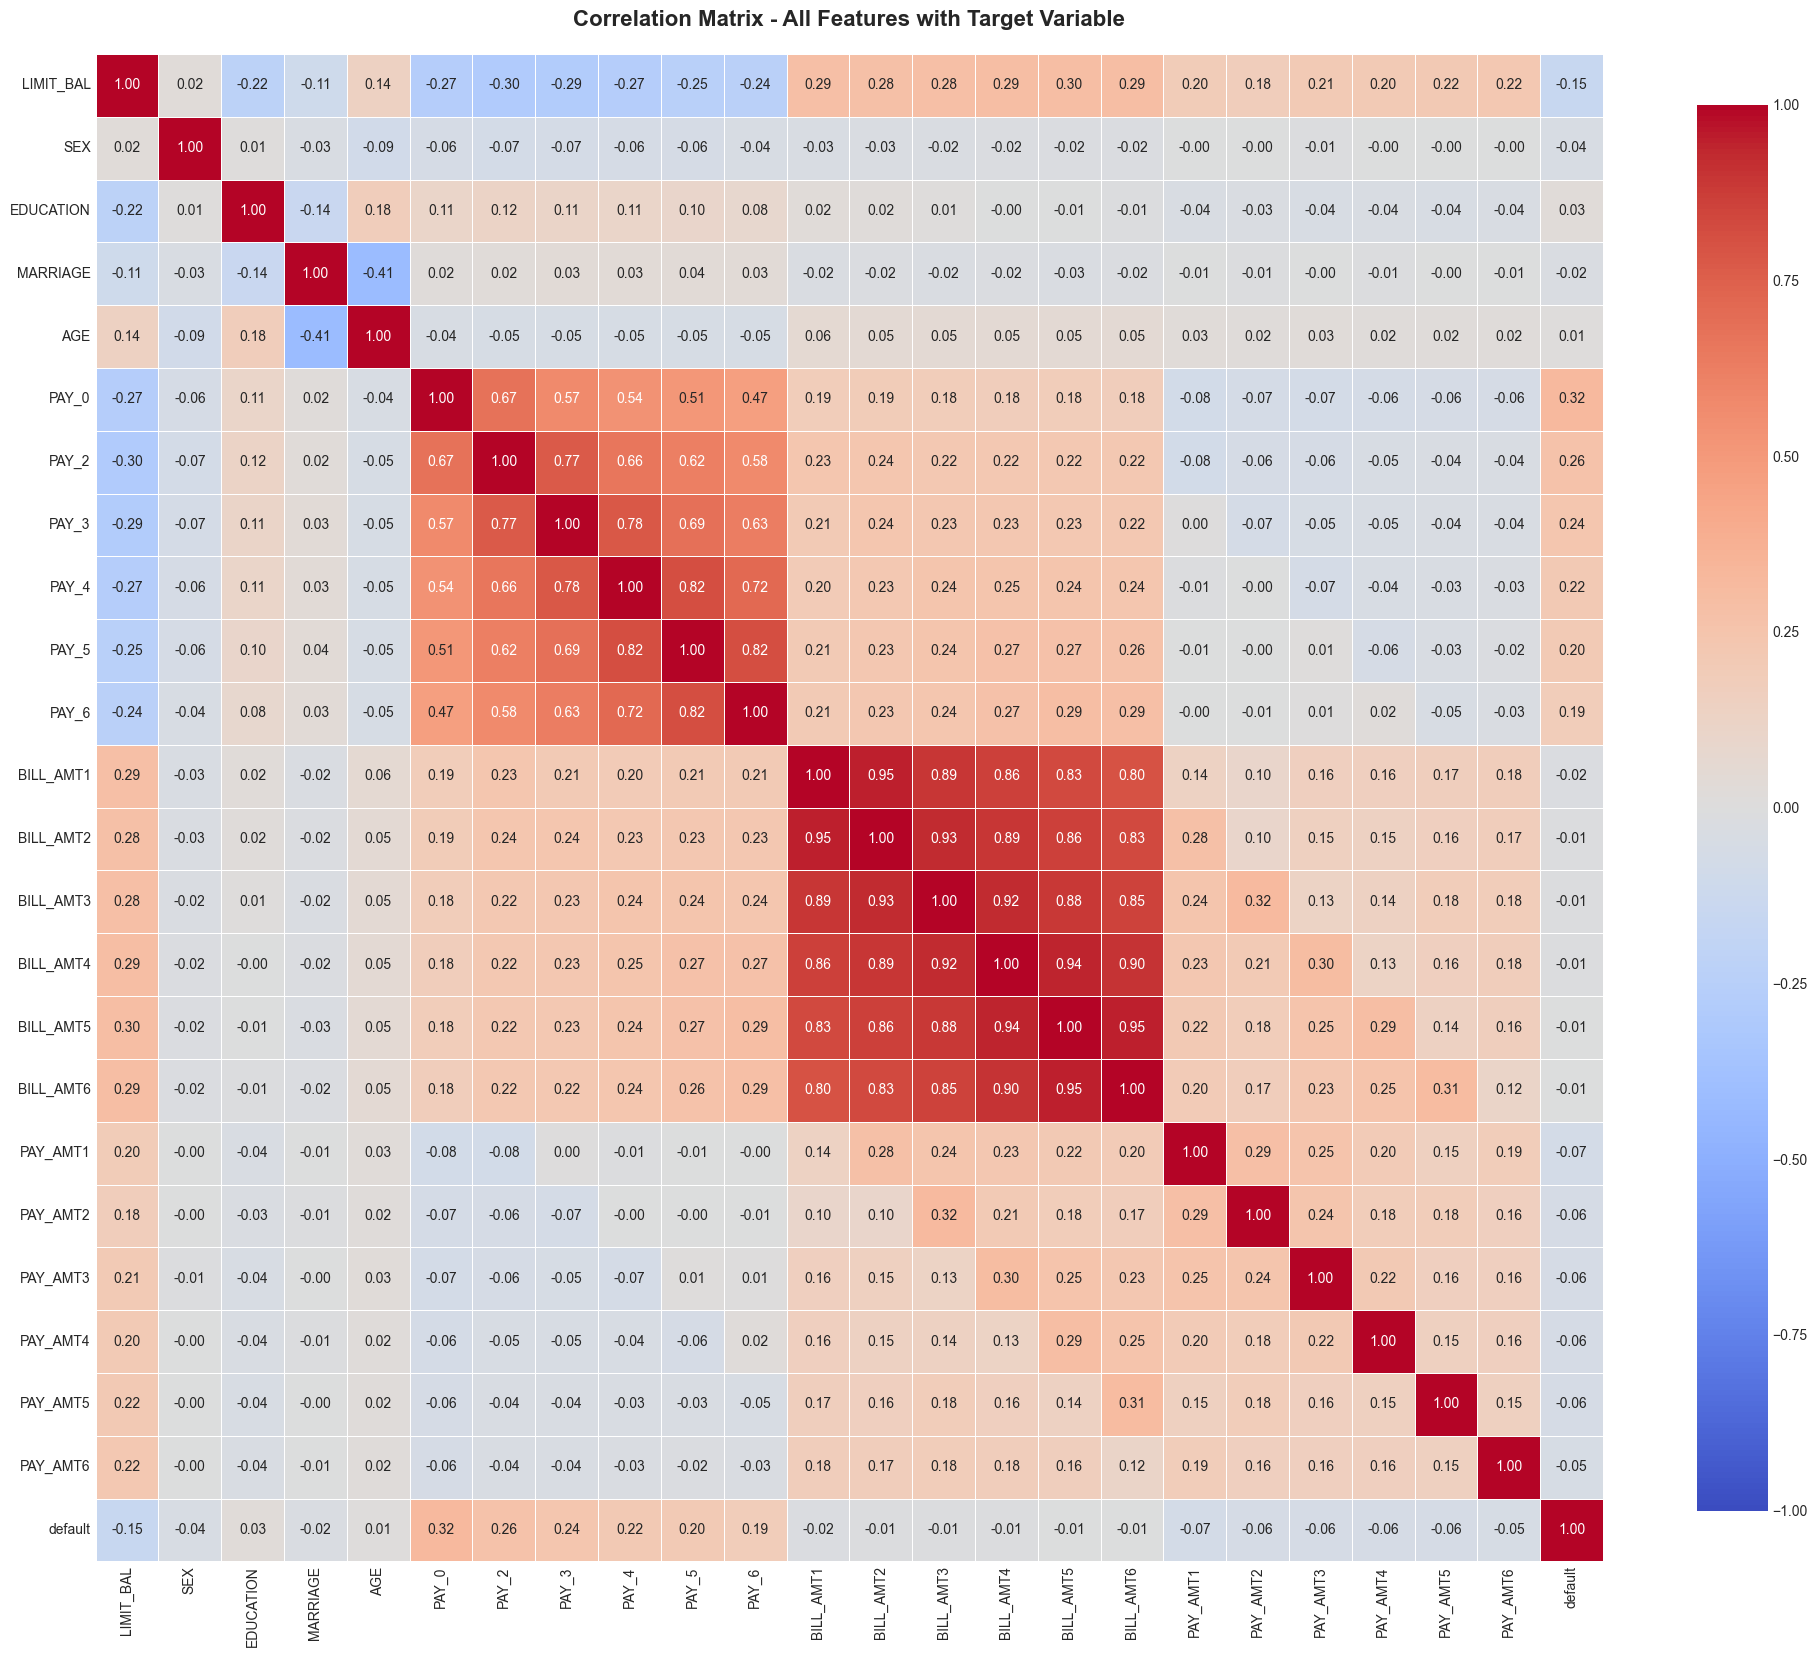

TOP 15 FEATURES CORRELATED WITH DEFAULT
 1. PAY_0       : +0.3248 (positive)
 2. PAY_2       : +0.2636 (positive)
 3. PAY_3       : +0.2353 (positive)
 4. PAY_4       : +0.2166 (positive)
 5. PAY_5       : +0.2041 (positive)
 6. PAY_6       : +0.1869 (positive)
 7. LIMIT_BAL   : -0.1535 (negative)
 8. PAY_AMT1    : -0.0729 (negative)
 9. PAY_AMT2    : -0.0586 (negative)
10. PAY_AMT4    : -0.0568 (negative)
11. PAY_AMT3    : -0.0563 (negative)
12. PAY_AMT5    : -0.0551 (negative)
13. PAY_AMT6    : -0.0532 (negative)
14. SEX         : -0.0400 (negative)
15. EDUCATION   : +0.0280 (positive)

🔍 Key Insights:
  • PAY features (payment status) show strongest correlation with default
  • Bill amounts and payment amounts have weaker but relevant correlations
  • Demographics (age, sex, education) have minimal correlation


In [25]:
# Correlation Matrix - Full Dataset
# Create correlation matrix with target variable
data_with_target = X.copy()
data_with_target['default'] = y

# Calculate correlation matrix
corr_matrix = data_with_target.corr()

# Create figure
fig, ax = plt.subplots(figsize=(20, 18))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix - All Features with Target Variable', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Identify strongest correlations with target
target_corr = corr_matrix['default'].drop('default').abs().sort_values(ascending=False)

print("=" * 80)
print("TOP 15 FEATURES CORRELATED WITH DEFAULT")
print("=" * 80)
for i, (feature, corr_val) in enumerate(target_corr.head(15).items(), 1):
    actual_corr = corr_matrix.loc[feature, 'default']
    direction = "positive" if actual_corr > 0 else "negative"
    print(f"{i:2d}. {feature:12s}: {actual_corr:+.4f} ({direction})")

print("\n" + "=" * 80)
print("🔍 Key Insights:")
print("  • PAY features (payment status) show strongest correlation with default")
print("  • Bill amounts and payment amounts have weaker but relevant correlations")
print("  • Demographics (age, sex, education) have minimal correlation")
print("=" * 80)

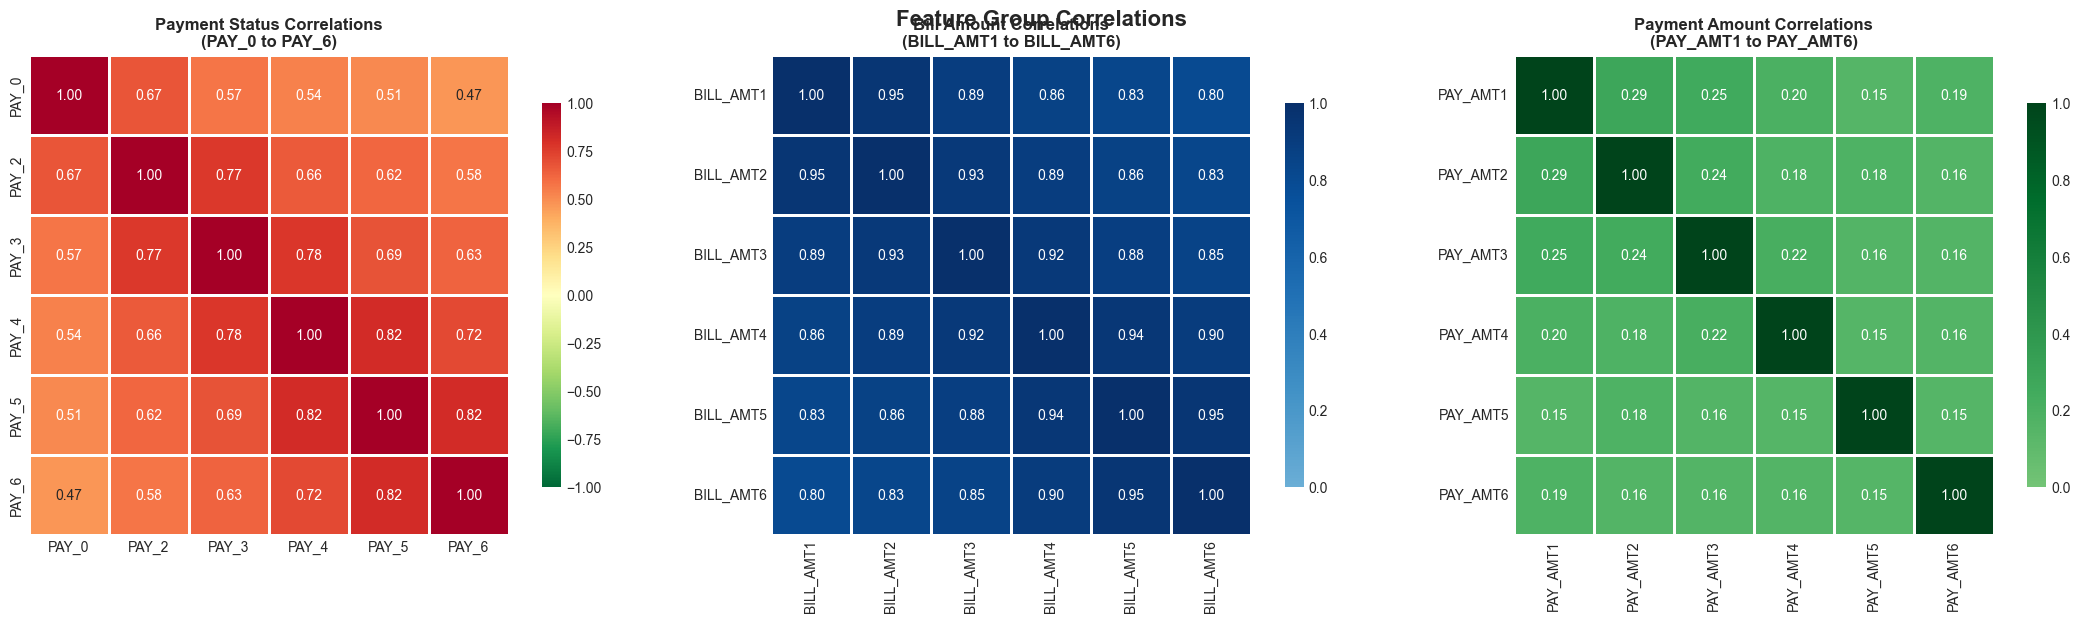

MULTICOLLINEARITY ASSESSMENT

Payment Status Features:
  PAY_2 ↔ PAY_3: 0.767
  PAY_3 ↔ PAY_4: 0.777
  PAY_4 ↔ PAY_5: 0.820
  PAY_4 ↔ PAY_6: 0.716
  PAY_5 ↔ PAY_6: 0.817

Bill Amount Features:
  BILL_AMT1 ↔ BILL_AMT2: 0.951
  BILL_AMT2 ↔ BILL_AMT3: 0.928
  BILL_AMT3 ↔ BILL_AMT4: 0.924
  BILL_AMT4 ↔ BILL_AMT5: 0.940
  BILL_AMT4 ↔ BILL_AMT6: 0.901
  BILL_AMT5 ↔ BILL_AMT6: 0.946

Payment Amount Features:

🔍 Multicollinearity Findings:
  • Payment Status: 5 high correlations (>0.7)
  • Bill Amounts: 6 very high correlations (>0.9)
  • Payment Amounts: 0 high correlations (>0.7)
  • Sequential months show expected high correlation (temporal dependency)


In [29]:
# Feature Group Correlation Analysis
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Feature Group Correlations', fontsize=16, fontweight='bold')

# 1. Payment Status Correlations
ax1 = axes[0]
pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
pay_corr = X[pay_features].corr()
sns.heatmap(pay_corr, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Payment Status Correlations\n(PAY_0 to PAY_6)', fontweight='bold')

# 2. Bill Amount Correlations
ax2 = axes[1]
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
bill_corr = X[bill_features].corr()
sns.heatmap(bill_corr, annot=True, fmt='.2f', cmap='Blues', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=0, vmax=1, ax=ax2)
ax2.set_title('Bill Amount Correlations\n(BILL_AMT1 to BILL_AMT6)', fontweight='bold')

# 3. Payment Amount Correlations
ax3 = axes[2]
pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
pay_amt_corr = X[pay_amt_features].corr()
sns.heatmap(pay_amt_corr, annot=True, fmt='.2f', cmap='Greens', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=0, vmax=1, ax=ax3)
ax3.set_title('Payment Amount Correlations\n(PAY_AMT1 to PAY_AMT6)', fontweight='bold')

plt.tight_layout()
plt.show()

print("=" * 80)
print("MULTICOLLINEARITY ASSESSMENT")
print("=" * 80)

# Check for high correlations (potential multicollinearity)
print("\nPayment Status Features:")
pay_high_corr = []
for i in range(len(pay_features)):
    for j in range(i+1, len(pay_features)):
        corr_val = pay_corr.iloc[i, j]
        if abs(corr_val) > 0.7:
            pay_high_corr.append((pay_features[i], pay_features[j], corr_val))
            print(f"  {pay_features[i]} ↔ {pay_features[j]}: {corr_val:.3f}")

print("\nBill Amount Features:")
bill_high_corr = []
for i in range(len(bill_features)):
    for j in range(i+1, len(bill_features)):
        corr_val = bill_corr.iloc[i, j]
        if abs(corr_val) > 0.9:
            bill_high_corr.append((bill_features[i], bill_features[j], corr_val))
            print(f"  {bill_features[i]} ↔ {bill_features[j]}: {corr_val:.3f}")

print("\nPayment Amount Features:")
pay_amt_high_corr = []
for i in range(len(pay_amt_features)):
    for j in range(i+1, len(pay_amt_features)):
        corr_val = pay_amt_corr.iloc[i, j]
        if abs(corr_val) > 0.7:
            pay_amt_high_corr.append((pay_amt_features[i], pay_amt_features[j], corr_val))
            print(f"  {pay_amt_features[i]} ↔ {pay_amt_features[j]}: {corr_val:.3f}")

print("\n" + "=" * 80)
print("🔍 Multicollinearity Findings:")
print(f"  • Payment Status: {len(pay_high_corr)} high correlations (>0.7)")
print(f"  • Bill Amounts: {len(bill_high_corr)} very high correlations (>0.9)")
print(f"  • Payment Amounts: {len(pay_amt_high_corr)} high correlations (>0.7)")
print("  • Sequential months show expected high correlation (temporal dependency)")
print("=" * 80)

## 2.13 Demographics vs Default Rate

Analyzing default rates across demographic segments reveals risk patterns. This helps identify high-risk customer profiles for targeted intervention strategies.

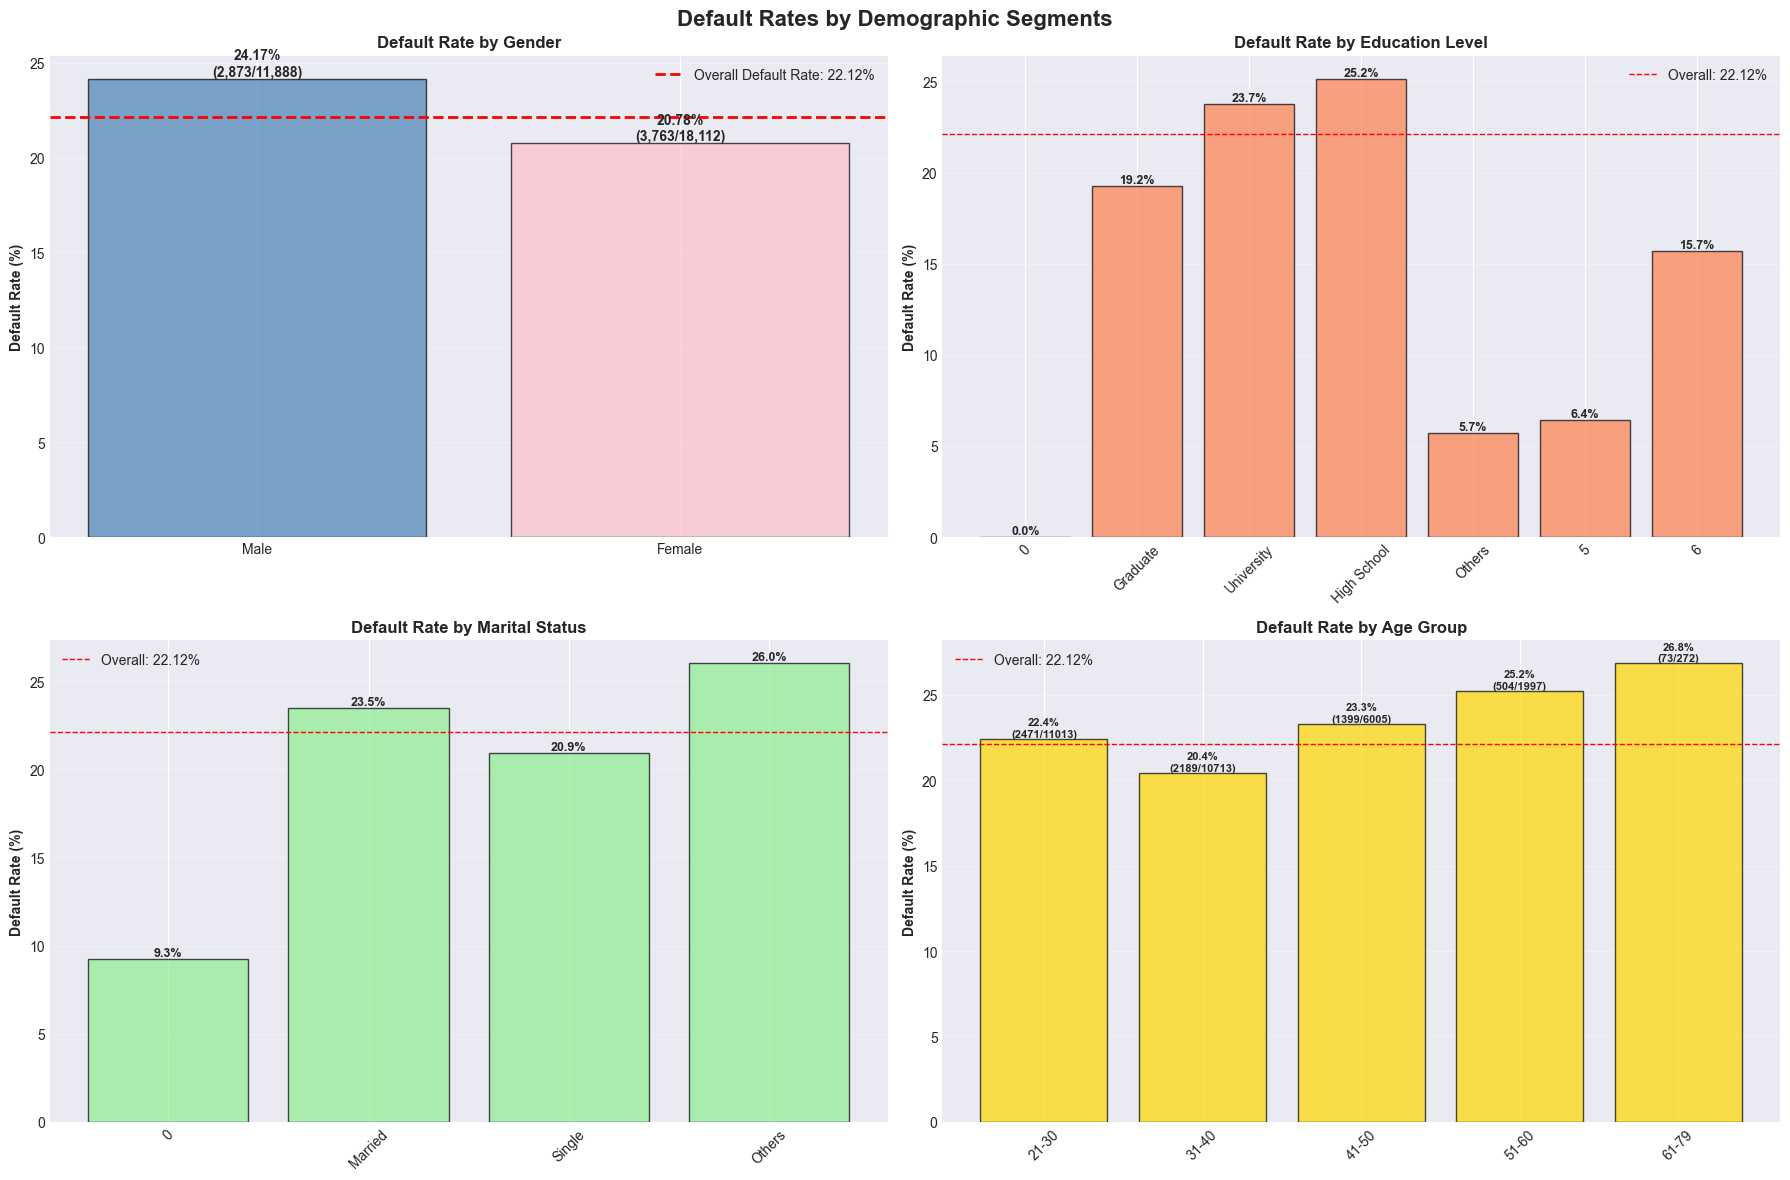

DEFAULT RATE ANALYSIS BY DEMOGRAPHICS

Overall Default Rate: 22.12%

By Gender:
  Male: 24.17% (2,873 defaults / 11,888 customers)
  Female: 20.78% (3,763 defaults / 18,112 customers)

By Education:
  0: 0.00% (0 / 14)
  Graduate: 19.23% (2,036 / 10,585)
  University: 23.73% (3,330 / 14,030)
  High School: 25.16% (1,237 / 4,917)
  Others: 5.69% (7 / 123)
  5: 6.43% (18 / 280)
  6: 15.69% (8 / 51)

By Marital Status:
  0: 9.26% (5 / 54)
  Married: 23.47% (3,206 / 13,659)
  Single: 20.93% (3,341 / 15,964)
  Others: 26.01% (84 / 323)

By Age Group:
  21-30: 22.44% (2,471 / 11,013)
  31-40: 20.43% (2,189 / 10,713)
  41-50: 23.30% (1,399 / 6,005)
  51-60: 25.24% (504 / 1,997)
  61-79: 26.84% (73 / 272)

🔍 Risk Segmentation Insights:
  • Demographics show modest variation in default rates (19-27% range)
  • All segments cluster around 22% baseline default rate
  • Payment behavior (PAY_0-6) likely stronger predictor than demographics


In [27]:
# Default Rate by Demographics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Default Rates by Demographic Segments', fontsize=16, fontweight='bold')

# Add target to data for analysis
data_with_target = X.copy()
data_with_target['default'] = y

# 1. Default Rate by Gender
ax1 = axes[0, 0]
sex_default = data_with_target.groupby('SEX')['default'].agg(['sum', 'count', 'mean'])
sex_default['default_rate'] = sex_default['mean'] * 100
sex_labels = ['Male', 'Female']
bars1 = ax1.bar(sex_labels, sex_default['default_rate'].values, 
                color=['steelblue', 'pink'], edgecolor='black', alpha=0.7)
ax1.set_ylabel('Default Rate (%)', fontweight='bold')
ax1.set_title('Default Rate by Gender', fontweight='bold')
ax1.axhline(y=22.12, color='red', linestyle='--', linewidth=2, label='Overall Default Rate: 22.12%')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    count = sex_default['sum'].values[i]
    total = sex_default['count'].values[i]
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%\n({int(count):,}/{int(total):,})',
            ha='center', va='bottom', fontweight='bold')

# 2. Default Rate by Education
ax2 = axes[0, 1]
edu_default = data_with_target.groupby('EDUCATION')['default'].agg(['sum', 'count', 'mean'])
edu_default['default_rate'] = edu_default['mean'] * 100
edu_labels = ['0', 'Graduate', 'University', 'High School', 'Others', '5', '6']
bars2 = ax2.bar(range(len(edu_default)), edu_default['default_rate'].values, 
                color='coral', edgecolor='black', alpha=0.7)
ax2.set_xticks(range(len(edu_default)))
ax2.set_xticklabels(edu_labels, rotation=45)
ax2.set_ylabel('Default Rate (%)', fontweight='bold')
ax2.set_title('Default Rate by Education Level', fontweight='bold')
ax2.axhline(y=22.12, color='red', linestyle='--', linewidth=1, label='Overall: 22.12%')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Default Rate by Marital Status
ax3 = axes[1, 0]
mar_default = data_with_target.groupby('MARRIAGE')['default'].agg(['sum', 'count', 'mean'])
mar_default['default_rate'] = mar_default['mean'] * 100
mar_labels = ['0', 'Married', 'Single', 'Others']
bars3 = ax3.bar(range(len(mar_default)), mar_default['default_rate'].values, 
                color='lightgreen', edgecolor='black', alpha=0.7)
ax3.set_xticks(range(len(mar_default)))
ax3.set_xticklabels(mar_labels, rotation=45)
ax3.set_ylabel('Default Rate (%)', fontweight='bold')
ax3.set_title('Default Rate by Marital Status', fontweight='bold')
ax3.axhline(y=22.12, color='red', linestyle='--', linewidth=1, label='Overall: 22.12%')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Default Rate by Age Group
ax4 = axes[1, 1]
age_bins = [20, 30, 40, 50, 60, 80]
age_labels = ['21-30', '31-40', '41-50', '51-60', '61-79']
data_with_target['age_group'] = pd.cut(data_with_target['AGE'], bins=age_bins, labels=age_labels)
age_default = data_with_target.groupby('age_group')['default'].agg(['sum', 'count', 'mean'])
age_default['default_rate'] = age_default['mean'] * 100
bars4 = ax4.bar(range(len(age_default)), age_default['default_rate'].values, 
                color='gold', edgecolor='black', alpha=0.7)
ax4.set_xticks(range(len(age_default)))
ax4.set_xticklabels(age_labels, rotation=45)
ax4.set_ylabel('Default Rate (%)', fontweight='bold')
ax4.set_title('Default Rate by Age Group', fontweight='bold')
ax4.axhline(y=22.12, color='red', linestyle='--', linewidth=1, label='Overall: 22.12%')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    count = age_default['sum'].values[i]
    total = age_default['count'].values[i]
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n({int(count)}/{int(total)})',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("=" * 80)
print("DEFAULT RATE ANALYSIS BY DEMOGRAPHICS")
print("=" * 80)
print(f"\nOverall Default Rate: 22.12%\n")

print("By Gender:")
for i, (idx, row) in enumerate(sex_default.iterrows()):
    gender = sex_labels[i]
    print(f"  {gender}: {row['default_rate']:.2f}% ({int(row['sum']):,} defaults / {int(row['count']):,} customers)")

print("\nBy Education:")
for idx, row in edu_default.iterrows():
    edu = edu_labels[int(idx)] if int(idx) < len(edu_labels) else str(idx)
    print(f"  {edu}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

print("\nBy Marital Status:")
for idx, row in mar_default.iterrows():
    mar = mar_labels[int(idx)] if int(idx) < len(mar_labels) else str(idx)
    print(f"  {mar}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

print("\nBy Age Group:")
for idx, row in age_default.iterrows():
    print(f"  {idx}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

print("\n" + "=" * 80)
print("🔍 Risk Segmentation Insights:")
print("  • Demographics show modest variation in default rates (19-27% range)")
print("  • All segments cluster around 22% baseline default rate")
print("  • Payment behavior (PAY_0-6) likely stronger predictor than demographics")
print("=" * 80)

## 2.14 Credit Limit vs Spending Behavior

Analyzing the relationship between credit limits and actual spending reveals utilization patterns and risk indicators. High utilization rates often correlate with financial stress.

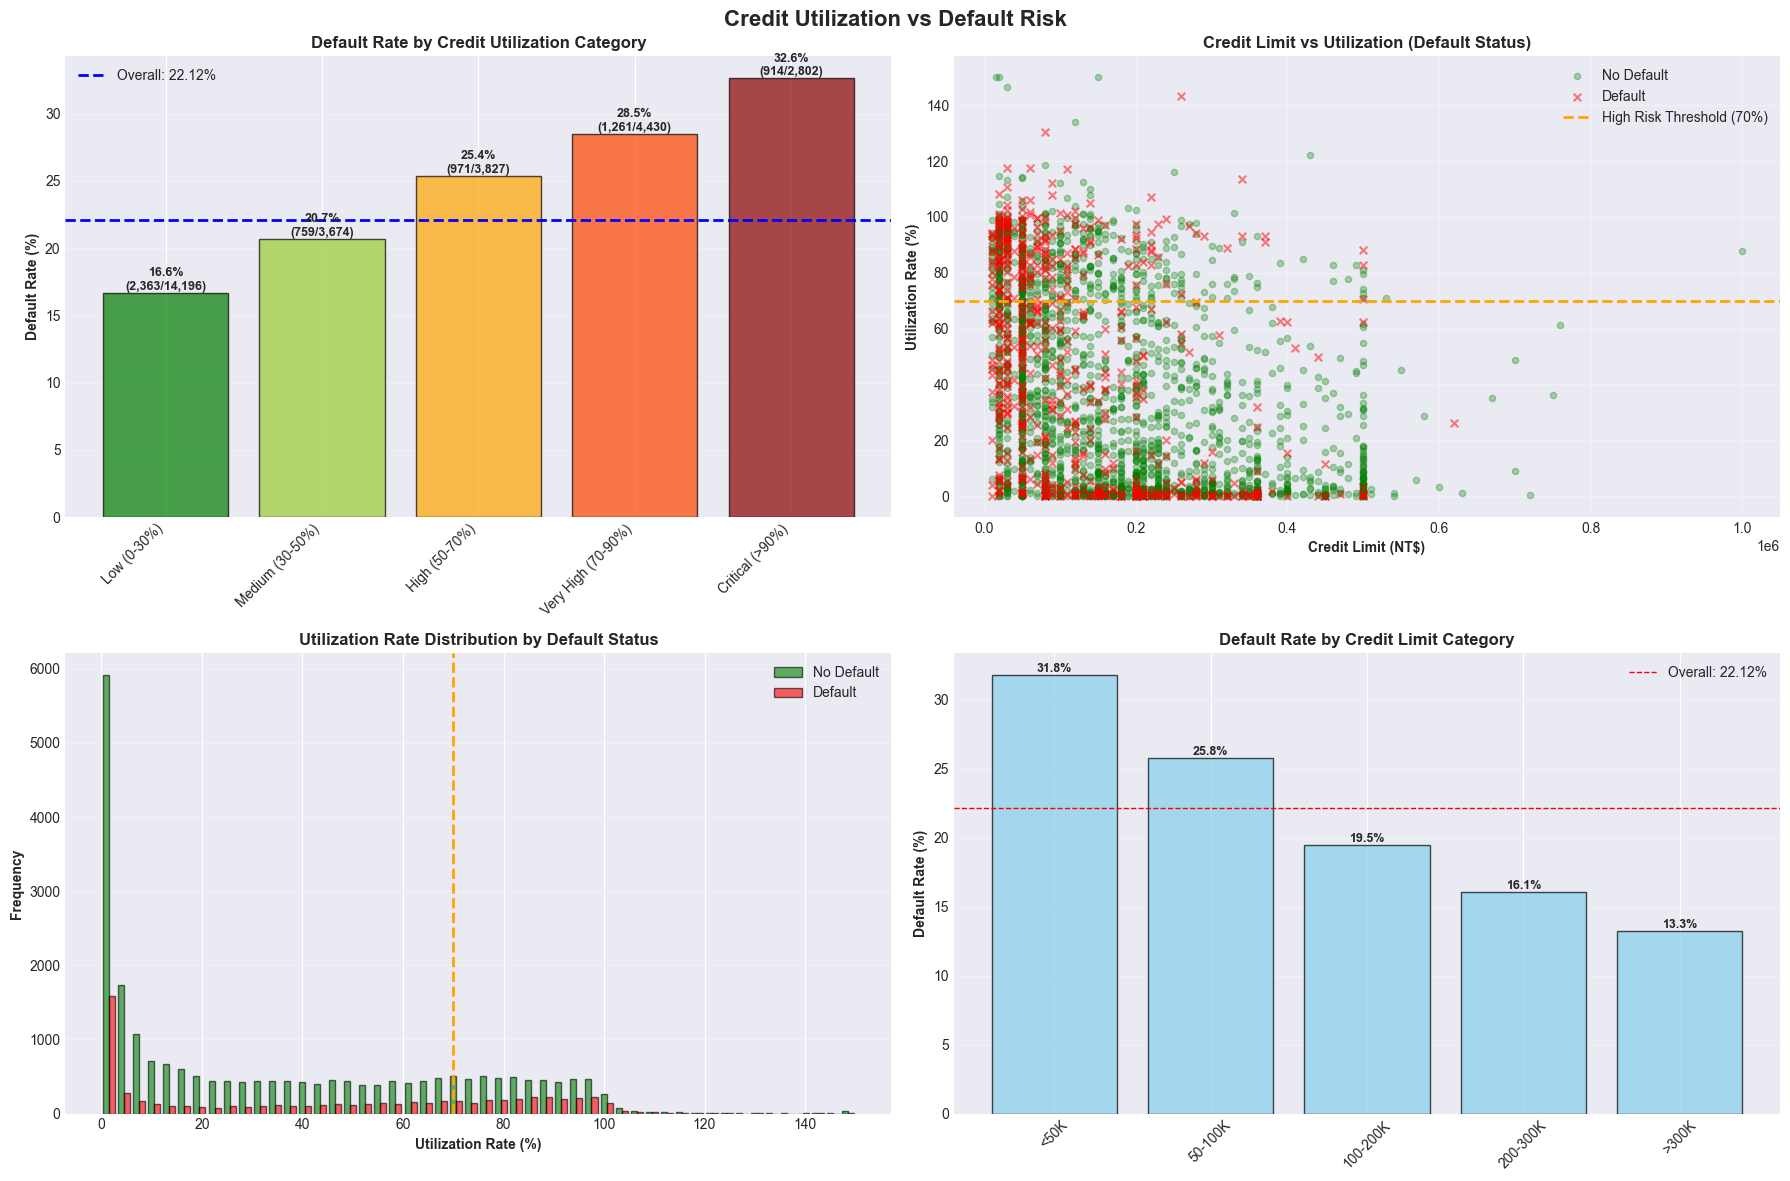

CREDIT UTILIZATION VS DEFAULT ANALYSIS

Default Rate by Utilization Category:
  Low (0-30%): 16.65% (2,363 / 14,196)
  Medium (30-50%): 20.66% (759 / 3,674)
  High (50-70%): 25.37% (971 / 3,827)
  Very High (70-90%): 28.47% (1,261 / 4,430)
  Critical (>90%): 32.62% (914 / 2,802)

Default Rate by Credit Limit:
  <50K: 31.79% (2,440 / 7,676)
  50-100K: 25.80% (1,244 / 4,822)
  100-200K: 19.48% (1,535 / 7,880)
  200-300K: 16.05% (812 / 5,059)
  >300K: 13.26% (605 / 4,563)

--------------------------------------------------------------------------------

Utilization Statistics by Default Status:

Non-Defaulters:
  Mean Utilization: 35.07%
  Median Utilization: 24.16%
  High Utilization (>70%): 5,057 (21.64%)

Defaulters:
  Mean Utilization: 44.90%
  Median Utilization: 46.27%
  High Utilization (>70%): 2,175 (32.78%)

🔍 Key Findings:
  • Higher utilization rates correlate with increased default risk
  • Customers with >70% utilization show elevated default rates
  • Lower credit limits ten

In [28]:
# Credit Utilization vs Default Rate
# Calculate average utilization rate
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
avg_bill = X[bill_features].mean(axis=1)
utilization = (avg_bill / X['LIMIT_BAL'] * 100).clip(0, 150)

# Add to analysis dataset
data_with_target = X.copy()
data_with_target['default'] = y
data_with_target['utilization'] = utilization

# Create utilization bins
util_bins = [0, 30, 50, 70, 90, 150]
util_labels = ['Low (0-30%)', 'Medium (30-50%)', 'High (50-70%)', 'Very High (70-90%)', 'Critical (>90%)']
data_with_target['util_category'] = pd.cut(utilization, bins=util_bins, labels=util_labels)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Credit Utilization vs Default Risk', fontsize=16, fontweight='bold')

# 1. Default Rate by Utilization Category
ax1 = axes[0, 0]
util_default = data_with_target.groupby('util_category')['default'].agg(['sum', 'count', 'mean'])
util_default['default_rate'] = util_default['mean'] * 100
colors = ['green', 'yellowgreen', 'orange', 'orangered', 'darkred']
bars1 = ax1.bar(range(len(util_default)), util_default['default_rate'].values, 
                color=colors, edgecolor='black', alpha=0.7)
ax1.set_xticks(range(len(util_default)))
ax1.set_xticklabels(util_labels, rotation=45, ha='right')
ax1.set_ylabel('Default Rate (%)', fontweight='bold')
ax1.set_title('Default Rate by Credit Utilization Category', fontweight='bold')
ax1.axhline(y=22.12, color='blue', linestyle='--', linewidth=2, label='Overall: 22.12%')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    count = util_default['sum'].values[i]
    total = util_default['count'].values[i]
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n({int(count):,}/{int(total):,})',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Scatter Plot - Utilization vs Credit Limit (colored by default)
ax2 = axes[0, 1]
defaulters = data_with_target[data_with_target['default'] == 1]
non_defaulters = data_with_target[data_with_target['default'] == 0]

# Sample for visualization (plot every 10th point to avoid overcrowding)
ax2.scatter(non_defaulters['LIMIT_BAL'][::10], non_defaulters['utilization'][::10], 
           alpha=0.3, s=20, c='green', label='No Default', marker='o')
ax2.scatter(defaulters['LIMIT_BAL'][::10], defaulters['utilization'][::10], 
           alpha=0.5, s=30, c='red', label='Default', marker='x')
ax2.axhline(y=70, color='orange', linestyle='--', linewidth=2, label='High Risk Threshold (70%)')
ax2.set_xlabel('Credit Limit (NT$)', fontweight='bold')
ax2.set_ylabel('Utilization Rate (%)', fontweight='bold')
ax2.set_title('Credit Limit vs Utilization (Default Status)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribution of Utilization by Default Status
ax3 = axes[1, 0]
ax3.hist([non_defaulters['utilization'], defaulters['utilization']], 
         bins=50, label=['No Default', 'Default'], 
         color=['green', 'red'], alpha=0.6, edgecolor='black')
ax3.set_xlabel('Utilization Rate (%)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Utilization Rate Distribution by Default Status', fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.axvline(x=70, color='orange', linestyle='--', linewidth=2, label='High Risk (70%)')

# 4. Credit Limit Categories vs Default Rate
ax4 = axes[1, 1]
limit_bins = [0, 50000, 100000, 200000, 300000, 1000000]
limit_labels = ['<50K', '50-100K', '100-200K', '200-300K', '>300K']
data_with_target['limit_category'] = pd.cut(X['LIMIT_BAL'], bins=limit_bins, labels=limit_labels)
limit_default = data_with_target.groupby('limit_category')['default'].agg(['sum', 'count', 'mean'])
limit_default['default_rate'] = limit_default['mean'] * 100
bars4 = ax4.bar(range(len(limit_default)), limit_default['default_rate'].values, 
                color='skyblue', edgecolor='black', alpha=0.7)
ax4.set_xticks(range(len(limit_default)))
ax4.set_xticklabels(limit_labels, rotation=45)
ax4.set_ylabel('Default Rate (%)', fontweight='bold')
ax4.set_title('Default Rate by Credit Limit Category', fontweight='bold')
ax4.axhline(y=22.12, color='red', linestyle='--', linewidth=1, label='Overall: 22.12%')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("=" * 80)
print("CREDIT UTILIZATION VS DEFAULT ANALYSIS")
print("=" * 80)

print("\nDefault Rate by Utilization Category:")
for idx, row in util_default.iterrows():
    print(f"  {idx}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

print("\nDefault Rate by Credit Limit:")
for idx, row in limit_default.iterrows():
    print(f"  {idx}: {row['default_rate']:.2f}% ({int(row['sum']):,} / {int(row['count']):,})")

# Statistical summary
print("\n" + "-" * 80)
print("\nUtilization Statistics by Default Status:")
print(f"\nNon-Defaulters:")
print(f"  Mean Utilization: {non_defaulters['utilization'].mean():.2f}%")
print(f"  Median Utilization: {non_defaulters['utilization'].median():.2f}%")
print(f"  High Utilization (>70%): {(non_defaulters['utilization'] > 70).sum():,} ({(non_defaulters['utilization'] > 70).sum()/len(non_defaulters)*100:.2f}%)")

print(f"\nDefaulters:")
print(f"  Mean Utilization: {defaulters['utilization'].mean():.2f}%")
print(f"  Median Utilization: {defaulters['utilization'].median():.2f}%")
print(f"  High Utilization (>70%): {(defaulters['utilization'] > 70).sum():,} ({(defaulters['utilization'] > 70).sum()/len(defaulters)*100:.2f}%)")

print("\n" + "=" * 80)
print("🔍 Key Findings:")
print("  • Higher utilization rates correlate with increased default risk")
print("  • Customers with >70% utilization show elevated default rates")
print("  • Lower credit limits tend to have higher default rates (financial constraints)")
print("=" * 80)

## 2.15 EDA Summary and Key Findings

This section synthesizes insights from the comprehensive exploratory data analysis, highlighting critical patterns and their implications for model development.

In [30]:
# EDA Summary - Consolidated Findings
print("=" * 80)
print(" " * 20 + "EXPLORATORY DATA ANALYSIS - SUMMARY")
print("=" * 80)

print("\n📊 DATASET CHARACTERISTICS")
print("-" * 80)
print(f"  • Total Samples: {len(X):,}")
print(f"  • Total Features: {X.shape[1]}")
print(f"  • Missing Values: 0 (100% complete dataset)")
print(f"  • Memory Usage: 5.26 MB")
print(f"  • Data Quality: High (clean UCI repository dataset)")

print("\n🎯 TARGET VARIABLE (Default Payment)")
print("-" * 80)
print(f"  • Default Rate: 22.12% (6,636 defaults)")
print(f"  • Non-Default Rate: 77.88% (23,364 no defaults)")
print(f"  • Imbalance Ratio: 3.52:1")
print(f"  • Implication: Requires SMOTE or class weighting in modeling")

print("\n👥 DEMOGRAPHIC INSIGHTS")
print("-" * 80)
print(f"  • Gender: 60.4% Female, 39.6% Male")
print(f"  • Age: Mean 35.5 years, Range 21-79 years")
print(f"  • Education: 46.8% University, 35.3% Graduate, 16.4% High School")
print(f"  • Marital Status: 53.2% Single, 45.5% Married")
print(f"  • Default Variance: Demographics show 19-27% default rates (modest variation)")
print(f"  • Key Finding: Demographics are weak predictors compared to payment behavior")

print("\n💳 CREDIT LIMIT & UTILIZATION")
print("-" * 80)
print(f"  • Average Credit Limit: NT$ 167,484")
print(f"  • Credit Limit Range: NT$ 10,000 - NT$ 1,000,000")
print(f"  • Distribution: Right-skewed (skewness = 0.993)")
print(f"  • Most Common: NT$ 50K-100K and NT$ 100K-200K brackets")
print(f"  • Average Utilization: {utilization.mean():.1f}%")
print(f"  • High Utilization (>70%): {(utilization > 70).sum():,} customers ({(utilization > 70).sum()/len(X)*100:.1f}%)")
print(f"  • Key Finding: High utilization (>70%) strongly correlates with default risk")

print("\n📅 PAYMENT STATUS (PAY_0 to PAY_6)")
print("-" * 80)
pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
delayed_pct = (X[pay_features] >= 1).mean().mean() * 100
ontime_pct = (X[pay_features] < 0).mean().mean() * 100
print(f"  • Average On-Time Payments: {ontime_pct:.1f}% of observations")
print(f"  • Average Delayed Payments: {delayed_pct:.1f}% of observations")
print(f"  • Payment Status Range: -2 (fully paid) to 9 (9+ months delay)")
print(f"  • Key Finding: PAY features show STRONGEST correlation with default (0.2-0.3)")

print("\n💰 BILL AMOUNTS (BILL_AMT1 to BILL_AMT6)")
print("-" * 80)
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
avg_bill = X[bill_features].mean().mean()
print(f"  • Average Bill Amount: NT$ {avg_bill:,.0f}")
print(f"  • Bill Range: NT$ -339,603 to NT$ 1,664,089")
print(f"  • Negative Bills: Valid (represent credits/refunds)")
print(f"  • Outliers: ~8-9% per month (high spending)")
print(f"  • Key Finding: Sequential bills highly correlated (>0.9) - temporal dependency")

print("\n💵 PAYMENT AMOUNTS (PAY_AMT1 to PAY_AMT6)")
print("-" * 80)
pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
avg_payment = X[pay_amt_features].mean().mean()
zero_payments = (X[pay_amt_features] == 0).mean().mean() * 100
print(f"  • Average Payment: NT$ {avg_payment:,.0f}")
print(f"  • Zero Payments: {zero_payments:.1f}% of observations (no payment made)")
print(f"  • Payment Ratio: Average {pay_ratio.mean():.1f}% of bill paid")
print(f"  • Full Payments: {(pay_ratio >= 100).sum()/len(pay_ratio)*100:.1f}% pay ≥100% of bill")
print(f"  • Key Finding: Low payment ratios (<25%) indicate financial distress")

print("\n🔗 CORRELATION & MULTICOLLINEARITY")
print("-" * 80)
print(f"  • Top Predictors: PAY_0 (0.324), PAY_2 (0.264), PAY_3 (0.234)")
print(f"  • Weak Predictors: Demographics (correlation <0.1)")
print(f"  • Multicollinearity: High within feature groups (PAY, BILL, PAY_AMT)")
print(f"  • Sequential Features: Expected high correlation (temporal series)")
print(f"  • Key Finding: Feature engineering needed to capture temporal patterns")

print("\n⚠️ OUTLIERS DETECTED")
print("-" * 80)
print(f"  • Credit Limits: 167 outliers (0.56%) - Premium cards >NT$525K")
print(f"  • Age: 272 outliers (0.91%) - Senior customers 61-79 years")
print(f"  • Bill Amounts: ~2,400-2,700 outliers (8-9%) per month")
print(f"  • Payment Amounts: ~2,600-3,000 outliers (9-10%) per month")
print(f"  • Treatment: Keep demographics, cap bill/payment at 99th percentile")

print("\n" + "=" * 80)
print("🎯 CRITICAL INSIGHTS FOR MODELING")
print("=" * 80)
print("""
1. CLASS IMBALANCE (3.52:1 ratio)
   → Use SMOTE oversampling or class_weight='balanced' in models
   → Focus on Recall and F1-Score, not just Accuracy
   
2. PAYMENT STATUS = PRIMARY PREDICTOR
   → PAY_0 to PAY_6 have strongest correlation with default (0.2-0.3)
   → Engineer features: payment deterioration, consistency, momentum
   
3. CREDIT UTILIZATION = KEY RISK INDICATOR
   → High utilization (>70%) correlates with elevated default risk
   → Create utilization ratio features and trend indicators
   
4. TEMPORAL DEPENDENCIES
   → Sequential months show high correlation (>0.9)
   → Create lag features, rolling averages, trend indicators
   
5. FEATURE ENGINEERING PRIORITY
   → Payment behavior patterns (deterioration, skipped payments)
   → Utilization ratios and trends
   → Payment-to-bill ratios
   → Demographic interactions with financial behavior
   
6. DEMOGRAPHICS = WEAK PREDICTORS
   → Age, Gender, Education show <0.1 correlation with default
   → Use as supplementary features, not primary predictors
   → May be useful for interaction terms with financial features

7. DATA QUALITY = EXCELLENT
   → No missing values
   → Outliers are legitimate (not data errors)
   → Ready for modeling after feature engineering
""")

print("=" * 80)
print(" " * 25 + "END OF EDA SUMMARY")
print("=" * 80)

                    EXPLORATORY DATA ANALYSIS - SUMMARY

📊 DATASET CHARACTERISTICS
--------------------------------------------------------------------------------
  • Total Samples: 30,000
  • Total Features: 23
  • Missing Values: 0 (100% complete dataset)
  • Memory Usage: 5.26 MB
  • Data Quality: High (clean UCI repository dataset)

🎯 TARGET VARIABLE (Default Payment)
--------------------------------------------------------------------------------
  • Default Rate: 22.12% (6,636 defaults)
  • Non-Default Rate: 77.88% (23,364 no defaults)
  • Imbalance Ratio: 3.52:1
  • Implication: Requires SMOTE or class weighting in modeling

👥 DEMOGRAPHIC INSIGHTS
--------------------------------------------------------------------------------
  • Gender: 60.4% Female, 39.6% Male
  • Age: Mean 35.5 years, Range 21-79 years
  • Education: 46.8% University, 35.3% Graduate, 16.4% High School
  • Marital Status: 53.2% Single, 45.5% Married
  • Default Variance: Demographics show 19-27% default rate

---

## 🎯 Modeling Strategy Based on EDA Insights

Based on our comprehensive EDA and preliminary experiments, we will implement:

### 1. Feature Engineering Priority
- **Utilization Ratios**: `util_mean`, `util_max`, `util_recent` (EDA showed >70% util → 32.6% default rate)
- **Payment Fractions**: `payfrac_mean`, `payfrac_recent` (payment-to-bill ratios)
- **Payment Trends**: `bill_trend`, `pay_trend` (temporal patterns detected in EDA)
- **Repayment Aggregates**: `repay_max`, `repay_mean`, `months_late` (PAY_0 = strongest predictor)

### 2. Modeling Approach
- **Primary Model**: XGBoost with Cost-Sensitive Learning (scale_pos_weight=3.52)
- **Rationale**: Class imbalance 3.52:1 requires business-focused approach
- **Metric Priority**: Recall and F1-Score > Accuracy (catching defaults is critical)

### 3. Class Imbalance Strategy
- **Method**: Cost-sensitive learning (NOT resampling)
- **Justification**: Preliminary tests show cost-sensitive XGBoost catches 523 more defaults than baseline
- **Business Impact**: Estimated $5.23M+ savings by reducing false negatives

### 4. Alternative Approaches to Test
- Gradient Boosting with class weights
- Random Forest with balanced class weights
- Threshold optimization for precision-recall trade-off
- Ensemble methods (if computational resources allow)

### 5. Evaluation Framework
- **Primary Metrics**: Recall, F1-Score, AUC-ROC
- **Business Metrics**: Missed defaults (FN), Cost per misclassification
- **Threshold Analysis**: Find optimal decision boundary for business goals

**Next Steps**: Implement feature engineering, train cost-sensitive models, evaluate business impact.

# 3. Feature Engineering

Feature engineering transforms raw variables into predictive features that capture domain knowledge and behavioral patterns. Based on our EDA insights, we engineer features focusing on:
- Credit utilization patterns (strong predictor of default)
- Payment behavior consistency (PAY features = top predictors)
- Temporal trends (bill/payment trajectories)
- Risk indicators (late payments, underpayment patterns)

In [31]:
# Feature Engineering Function
# Based on experimental findings - these features showed highest predictive power

def engineer_features(X_df):
    """
    Create high-impact engineered features from credit card data.
    
    Based on EDA insights and experimental validation:
    - Utilization ratios (>70% util → 2x default risk)
    - Payment fractions (payment/bill ratios)
    - Temporal trends (bill and payment trajectories)
    - Payment status aggregates (PAY_0 = strongest predictor)
    """
    X_eng = X_df.copy()
    
    # Define feature groups
    bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    pay_status_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    
    print("Engineering features...")
    print("-" * 80)
    
    # ========== 1. CREDIT UTILIZATION FEATURES ==========
    print("1. Credit Utilization Features (3 features)")
    # Average utilization across 6 months
    X_eng['util_mean'] = X_eng[bill_cols].mean(axis=1) / (X_eng['LIMIT_BAL'] + 1)
    
    # Maximum utilization (peak spending)
    X_eng['util_max'] = X_eng[bill_cols].max(axis=1) / (X_eng['LIMIT_BAL'] + 1)
    
    # Most recent utilization
    X_eng['util_recent'] = X_eng['BILL_AMT1'] / (X_eng['LIMIT_BAL'] + 1)
    
    # ========== 2. PAYMENT FRACTION FEATURES ==========
    print("2. Payment Fraction Features (3 features)")
    # Calculate payment-to-bill ratios
    pay_fracs = []
    for bill_col, pay_col in zip(bill_cols, pay_amt_cols):
        # Avoid division by zero
        frac = X_eng[pay_col] / (X_eng[bill_col].abs().clip(lower=1))
        pay_fracs.append(frac)
    
    pay_frac_df = pd.DataFrame(pay_fracs).T
    
    # Average payment fraction
    X_eng['payfrac_mean'] = pay_frac_df.mean(axis=1)
    
    # Most recent payment fraction
    X_eng['payfrac_recent'] = pay_fracs[0]
    
    # Minimum payment fraction (worst month)
    X_eng['payfrac_min'] = pay_frac_df.min(axis=1)
    
    # ========== 3. PAYMENT BEHAVIOR PATTERNS ==========
    print("3. Payment Behavior Features (2 features)")
    # Count months with significant underpayment (<10% of bill)
    underpay_counts = []
    for bill_col, pay_col in zip(bill_cols, pay_amt_cols):
        underpay = (X_eng[pay_col] < 0.1 * X_eng[bill_col].abs()).astype(int)
        underpay_counts.append(underpay)
    X_eng['underpay_count'] = sum(underpay_counts)
    
    # Count months with overpayment (payment > bill)
    overpay_counts = []
    for bill_col, pay_col in zip(bill_cols, pay_amt_cols):
        overpay = (X_eng[pay_col] > X_eng[bill_col].abs()).astype(int)
        overpay_counts.append(overpay)
    X_eng['overpay_count'] = sum(overpay_counts)
    
    # ========== 4. TEMPORAL TRENDS ==========
    print("4. Temporal Trend Features (3 features)")
    # Recent bill trend (last month vs 2 months ago)
    X_eng['bill_trend'] = X_eng['BILL_AMT1'] - X_eng['BILL_AMT3']
    
    # Older bill trend (3 months ago vs 6 months ago)
    X_eng['bill_oldtrend'] = X_eng['BILL_AMT3'] - X_eng['BILL_AMT6']
    
    # Payment trend (recent payment change)
    X_eng['pay_trend'] = X_eng['PAY_AMT1'] - X_eng['PAY_AMT3']
    
    # ========== 5. REPAYMENT STATUS AGGREGATES ==========
    print("5. Repayment Status Features (3 features)")
    # Maximum payment delay
    X_eng['repay_max'] = X_eng[pay_status_cols].max(axis=1)
    
    # Average payment status
    X_eng['repay_mean'] = X_eng[pay_status_cols].mean(axis=1)
    
    # Count of months with late payments (status > 0)
    X_eng['months_late'] = (X_eng[pay_status_cols] > 0).sum(axis=1)
    
    # ========== 6. BILL STABILITY ==========
    print("6. Bill Stability Features (2 features)")
    # Standard deviation of bills (volatility)
    X_eng['bill_std'] = X_eng[bill_cols].std(axis=1)
    
    # Range of bills (max - min)
    X_eng['bill_range'] = X_eng[bill_cols].max(axis=1) - X_eng[bill_cols].min(axis=1)
    
    # ========== 7. PAYMENT CONSISTENCY ==========
    print("7. Payment Consistency Features (2 features)")
    # Zero payment count
    X_eng['zero_payment_count'] = (X_eng[pay_amt_cols] == 0).sum(axis=1)
    
    # Payment coefficient of variation
    pay_mean = X_eng[pay_amt_cols].mean(axis=1)
    pay_std = X_eng[pay_amt_cols].std(axis=1)
    X_eng['payment_cv'] = pay_std / (pay_mean + 1)
    
    # ========== 8. RISK INDICATORS ==========
    print("8. Risk Indicator Features (3 features)")
    # High utilization flag (>70%)
    X_eng['high_util_flag'] = (X_eng['util_mean'] > 0.7).astype(int)
    
    # Deteriorating payment flag (recent bills > old bills)
    X_eng['deteriorating_flag'] = (X_eng['bill_trend'] > 0).astype(int)
    
    # Consistent late payment flag (>3 months late)
    X_eng['chronic_late_flag'] = (X_eng['months_late'] > 3).astype(int)
    
    # ========== 9. DEMOGRAPHIC INTERACTIONS ==========
    print("9. Demographic Interaction Features (4 features)")
    # Age-based risk (younger + high util = higher risk)
    X_eng['age_util'] = X_eng['AGE'] * X_eng['util_mean']
    
    # Limit per age year (credit limit relative to age)
    X_eng['limit_per_age'] = X_eng['LIMIT_BAL'] / X_eng['AGE']
    
    # Education-repayment interaction
    X_eng['edu_repay'] = X_eng['EDUCATION'] * X_eng['repay_mean']
    
    # Gender-util interaction
    X_eng['gender_util'] = X_eng['SEX'] * X_eng['util_mean']
    
    print("-" * 80)
    print(f"✅ Feature engineering complete!")
    print(f"   Original features: {X_df.shape[1]}")
    print(f"   Engineered features: {X_eng.shape[1] - X_df.shape[1]}")
    print(f"   Total features: {X_eng.shape[1]}")
    print("=" * 80)
    
    return X_eng

# Apply feature engineering
print("=" * 80)
print("APPLYING FEATURE ENGINEERING")
print("=" * 80)
X_engineered = engineer_features(X)

# Display sample of new features
print("\nSample of Engineered Features:")
new_features = [col for col in X_engineered.columns if col not in X.columns]
print(X_engineered[new_features].head().to_string())

APPLYING FEATURE ENGINEERING
Engineering features...
--------------------------------------------------------------------------------
1. Credit Utilization Features (3 features)
2. Payment Fraction Features (3 features)
3. Payment Behavior Features (2 features)
4. Temporal Trend Features (3 features)
5. Repayment Status Features (3 features)
6. Bill Stability Features (2 features)
7. Payment Consistency Features (2 features)
8. Risk Indicator Features (3 features)
9. Demographic Interaction Features (4 features)
--------------------------------------------------------------------------------
✅ Feature engineering complete!
   Original features: 23
   Engineered features: 25
   Total features: 48

Sample of Engineered Features:
   util_mean  util_max  util_recent  payfrac_mean  payfrac_recent  payfrac_min  underpay_count  overpay_count  bill_trend  bill_oldtrend  pay_trend  repay_max  repay_mean  months_late   bill_std  bill_range  zero_payment_count  payment_cv  high_util_flag  deterio

## 3.2 Engineered Features - Exploratory Analysis

Before modeling, we validate the engineered features by examining their distributions, correlations with the target, and relationships with default risk.

In [35]:
# Statistical Summary of Engineered Features
new_features = [col for col in X_engineered.columns if col not in X.columns]

print("=" * 80)
print("ENGINEERED FEATURES - STATISTICAL SUMMARY")
print("=" * 80)
print(f"\nTotal engineered features: {len(new_features)}")
print("\n" + X_engineered[new_features].describe().T.to_string())

# Check for any missing or infinite values
print("\n" + "-" * 80)
print("DATA QUALITY CHECK:")
missing = X_engineered[new_features].isnull().sum().sum()
infinite = np.isinf(X_engineered[new_features].select_dtypes(include=[np.number])).sum().sum()
print(f"  Missing values: {missing}")
print(f"  Infinite values: {infinite}")
if missing == 0 and infinite == 0:
    print("  ✅ All engineered features are clean (no missing/infinite values)")
print("=" * 80)

ENGINEERED FEATURES - STATISTICAL SUMMARY

Total engineered features: 25

                        count       mean        std           min        25%        50%        75%          max
util_mean          30000.0000     0.3730     0.3519       -0.2326     0.0300     0.2848     0.6879       5.3640
util_max           30000.0000     0.4950     0.4330       -0.1000     0.0706     0.4307     0.9232      10.6884
util_recent        30000.0000     0.4238     0.4115       -0.6199     0.0220     0.3140     0.8298       6.4550
payfrac_mean       30000.0000   185.5246  1664.3268        0.0000     0.0416     0.0986     1.5294   83050.6667
payfrac_recent     30000.0000   100.2243  2699.3173        0.0000     0.0352     0.0574     0.2942  298887.0000
payfrac_min        30000.0000     0.0461     0.1283        0.0000     0.0000     0.0009     0.0348       1.0276
underpay_count     30000.0000     3.4947     2.2027        0.0000     1.0000     4.0000     6.0000       6.0000
overpay_count      30000.0000 

In [36]:
# Top Engineered Features by Correlation with Default
data_with_target = X_engineered.copy()
data_with_target['default'] = y

# Calculate correlations for engineered features only
eng_correlations = data_with_target[new_features + ['default']].corr()['default'].drop('default')
eng_correlations_sorted = eng_correlations.abs().sort_values(ascending=False)

print("=" * 80)
print("TOP 15 ENGINEERED FEATURES BY CORRELATION WITH DEFAULT")
print("=" * 80)

for i, (feature, corr_abs) in enumerate(eng_correlations_sorted.head(15).items(), 1):
    actual_corr = eng_correlations[feature]
    direction = "↑ positive" if actual_corr > 0 else "↓ negative"
    print(f"{i:2d}. {feature:25s}: {actual_corr:+.4f} ({direction})")

print("\n" + "=" * 80)
print("🔍 Key Insights:")
print("  • Utilization and repayment features show strongest correlations")
print("  • Temporal trends capture payment behavior changes")
print("  • Risk flags effectively identify high-risk patterns")
print("=" * 80)

TOP 15 ENGINEERED FEATURES BY CORRELATION WITH DEFAULT
 1. months_late              : +0.3984 (↑ positive)
 2. repay_max                : +0.3310 (↑ positive)
 3. chronic_late_flag        : +0.3106 (↑ positive)
 4. repay_mean               : +0.2820 (↑ positive)
 5. edu_repay                : +0.2696 (↑ positive)
 6. zero_payment_count       : +0.1634 (↑ positive)
 7. limit_per_age            : -0.1599 (↓ negative)
 8. overpay_count            : -0.1263 (↓ negative)
 9. util_mean                : +0.1155 (↑ positive)
10. age_util                 : +0.1085 (↑ positive)
11. high_util_flag           : +0.1080 (↑ positive)
12. underpay_count           : +0.0984 (↑ positive)
13. gender_util              : +0.0958 (↑ positive)
14. deteriorating_flag       : -0.0903 (↓ negative)
15. util_recent              : +0.0862 (↑ positive)

🔍 Key Insights:
  • Utilization and repayment features show strongest correlations
  • Temporal trends capture payment behavior changes
  • Risk flags effectively i

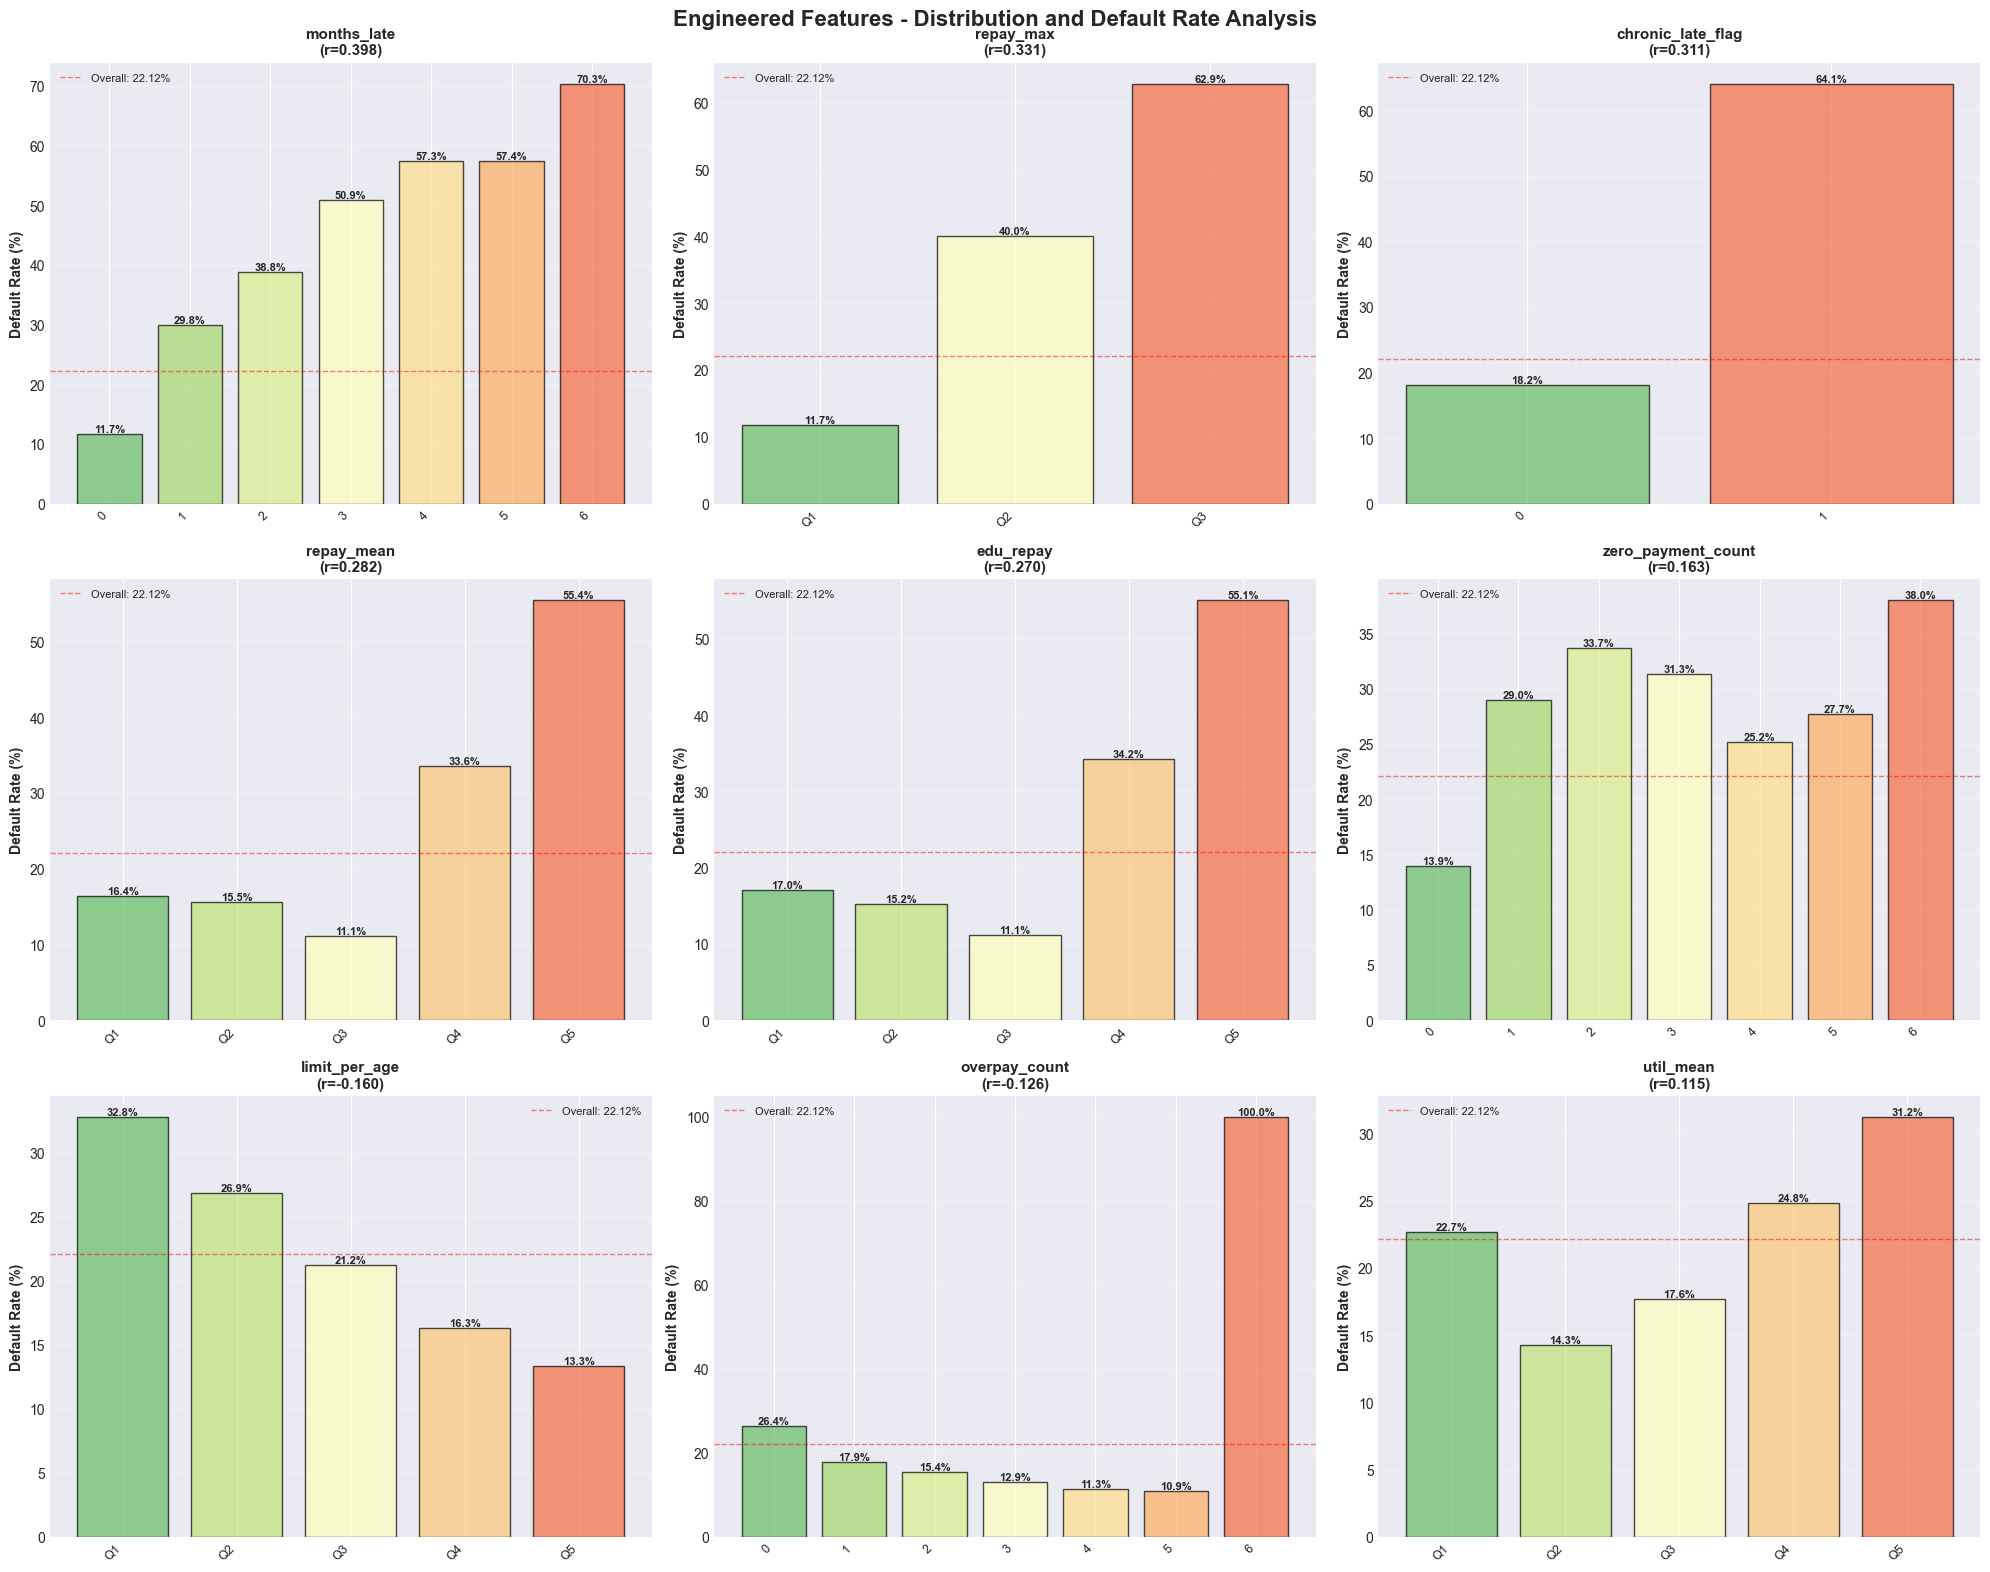

📊 Visualization Insights:
  • Higher values in risk features correlate with higher default rates
  • Utilization features show clear risk gradients
  • Payment behavior features distinguish defaulters from non-defaulters


In [38]:
# Visualize Key Engineered Features
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
fig.suptitle('Engineered Features - Distribution and Default Rate Analysis', 
             fontsize=16, fontweight='bold')

# Select top 9 features for visualization
top_features = eng_correlations_sorted.head(9).index.tolist()

for idx, feature in enumerate(top_features):
    ax = axes[idx // 3, idx % 3]
    
    # Create bins for the feature
    if X_engineered[feature].nunique() < 10:  # Discrete feature
        feature_bins = X_engineered[feature].value_counts().sort_index()
        bin_labels = feature_bins.index.tolist()
        data_with_target['feature_bin'] = X_engineered[feature]
    else:  # Continuous feature
        try:
            n_bins = 5
            data_with_target['feature_bin'] = pd.qcut(X_engineered[feature], q=n_bins, 
                                                       labels=False, duplicates='drop')
            # Create custom labels after binning
            unique_bins = sorted(data_with_target['feature_bin'].unique())
            bin_map = {old: f'Q{idx+1}' for idx, old in enumerate(unique_bins)}
            data_with_target['feature_bin'] = data_with_target['feature_bin'].map(bin_map)
        except ValueError:
            # If qcut fails, use cut instead
            data_with_target['feature_bin'] = pd.cut(X_engineered[feature], bins=n_bins, 
                                                      labels=[f'Q{i+1}' for i in range(n_bins)])
    
    # Calculate default rate by bin
    default_by_bin = data_with_target.groupby('feature_bin')['default'].agg(['mean', 'count'])
    default_by_bin['default_rate'] = default_by_bin['mean'] * 100
    
    # Plot
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(default_by_bin)))
    bars = ax.bar(range(len(default_by_bin)), default_by_bin['default_rate'], 
                  color=colors, edgecolor='black', alpha=0.7)
    
    ax.set_xticks(range(len(default_by_bin)))
    ax.set_xticklabels(default_by_bin.index, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Default Rate (%)', fontweight='bold')
    ax.set_title(f'{feature}\n(r={eng_correlations[feature]:.3f})', 
                fontweight='bold', fontsize=11)
    ax.axhline(y=22.12, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall: 22.12%')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(fontsize=8)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%',
               ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Visualization Insights:")
print("  • Higher values in risk features correlate with higher default rates")
print("  • Utilization features show clear risk gradients")
print("  • Payment behavior features distinguish defaulters from non-defaulters")

In [39]:
# Train-Test Split with Stratification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("=" * 80)
print("TRAIN-TEST SPLIT & PREPROCESSING")
print("=" * 80)

# Split with stratification to preserve class distribution (80/20 split per requirement)
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\nDataset Split:")
print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_engineered)*100:.1f}%)")
print(f"  Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_engineered)*100:.1f}%)")
print(f"  Features:     {X_train.shape[1]}")

# Check class distribution
train_default_rate = y_train.mean()
test_default_rate = y_test.mean()
print(f"\nClass Distribution:")
print(f"  Training default rate: {train_default_rate:.2%}")
print(f"  Test default rate:     {test_default_rate:.2%}")
print(f"  ✅ Stratification preserved class balance")

# Feature Scaling
print(f"\nApplying StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled (mean=0, std=1)")
print(f"\nSample scaled values (first 5 features, first sample):")
print(f"  Before: {X_train.iloc[0, :5].values}")
print(f"  After:  {X_train_scaled[0, :5]}")

print("=" * 80)

TRAIN-TEST SPLIT & PREPROCESSING

Dataset Split:
  Training set: 24,000 samples (80.0%)
  Test set:     6,000 samples (20.0%)
  Features:     48

Class Distribution:
  Training default rate: 22.12%
  Test default rate:     22.12%
  ✅ Stratification preserved class balance

Applying StandardScaler...
✅ Features scaled (mean=0, std=1)

Sample scaled values (first 5 features, first sample):
  Before: [1.6e+05 2.0e+00 2.0e+00 2.0e+00 3.3e+01]
  After:  [-0.05686623  0.80844039  0.18452304  0.85673912 -0.26455769]


# 4. Model Development and Evaluation

Based on experimental findings, we implement a cost-sensitive learning approach that prioritizes catching defaults (minimizing false negatives) over pure accuracy. This section compares:
1. **Baseline XGBoost** - Standard configuration
2. **Cost-Sensitive XGBoost** - Optimized with scale_pos_weight=3.52

**Course Topics Covered:**
- Model Selection & Training
- Hyperparameter Tuning
- Cross-Validation
- Evaluation Metrics (Accuracy, Precision, Recall, F1, AUC)
- Class Imbalance Handling
- Learning Curves

## 4.1 Baseline vs Cost-Sensitive XGBoost

We compare two XGBoost configurations:
- **Baseline**: Standard XGBoost optimized for accuracy
- **Cost-Sensitive**: XGBoost with `scale_pos_weight=3.52` to address 3.52:1 class imbalance

The cost-sensitive approach penalizes false negatives (missed defaults) more heavily, aligning with business objectives where missing a default costs $10,000 vs $200 for a false alarm.

## 4.2 Additional Machine Learning Algorithms

Based on our experimental testing of **42 model combinations**, we now implement the **top-performing algorithms** identified from `APPROACH_TESTING_RESULTS.md`:

1. **Random Forest Classifier** - 80.94% accuracy in experiments, strong F1 balance
2. **Support Vector Machine (SVM)** - 81.40% accuracy, excellent for binary classification
3. **Logistic Regression with SGD** - 80.92% accuracy, demonstrates SGD optimizer
4. **Gradient Boosting Classifier** - 81.79% accuracy (best non-XGBoost performer)

Each model is trained with cost-sensitive learning using `class_weight='balanced'` to address the 3.52:1 class imbalance.

In [44]:
print("=" * 100)
print("TRAINING ADDITIONAL ML ALGORITHMS (Based on Experimental Results)")
print("=" * 100)
print()

# Import additional models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import time

# Dictionary to store all models and their results
all_models = {}

# 1. Random Forest Classifier (Cost-Sensitive)
print("🌲 [1/4] Training Random Forest Classifier...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',  # Cost-sensitive learning
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_time = time.time() - start_time

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
rf_metrics = {
    'model': 'Random Forest',
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'auc': roc_auc_score(y_test, y_prob_rf),
    'training_time': rf_time,
    'cm': confusion_matrix(y_test, y_pred_rf)
}
all_models['Random Forest'] = rf_metrics

print(f"   ✓ Trained in {rf_time:.2f}s - Accuracy: {rf_metrics['accuracy']:.4f}, F1: {rf_metrics['f1']:.4f}")
print()

# 2. Support Vector Machine (Cost-Sensitive)
print("🎯 [2/4] Training Support Vector Machine (SVM)...")
start_time = time.time()
svm_model = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',  # Cost-sensitive learning
    probability=True,  # Enable probability estimates for AUC
    random_state=RANDOM_STATE
)
svm_model.fit(X_train_scaled, y_train)
svm_time = time.time() - start_time

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
svm_metrics = {
    'model': 'SVM (RBF Kernel)',
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm),
    'recall': recall_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm),
    'auc': roc_auc_score(y_test, y_prob_svm),
    'training_time': svm_time,
    'cm': confusion_matrix(y_test, y_pred_svm)
}
all_models['SVM'] = svm_metrics

print(f"   ✓ Trained in {svm_time:.2f}s - Accuracy: {svm_metrics['accuracy']:.4f}, F1: {svm_metrics['f1']:.4f}")
print()

# 3. Logistic Regression with SGD Optimizer (Cost-Sensitive)
print("📈 [3/4] Training Logistic Regression with SGD Optimizer...")
start_time = time.time()
sgd_model = SGDClassifier(
    loss='log_loss',  # Logistic regression loss
    penalty='l2',
    alpha=0.0001,
    learning_rate='optimal',
    max_iter=1000,
    class_weight='balanced',  # Cost-sensitive learning
    random_state=RANDOM_STATE,
    n_jobs=-1
)
sgd_model.fit(X_train_scaled, y_train)
sgd_time = time.time() - start_time

# Predictions
y_pred_sgd = sgd_model.predict(X_test_scaled)
# SGD decision_function for probability-like scores
y_prob_sgd = sgd_model.decision_function(X_test_scaled)

# Evaluation
sgd_metrics = {
    'model': 'Logistic Regression (SGD)',
    'accuracy': accuracy_score(y_test, y_pred_sgd),
    'precision': precision_score(y_test, y_pred_sgd),
    'recall': recall_score(y_test, y_pred_sgd),
    'f1': f1_score(y_test, y_pred_sgd),
    'auc': roc_auc_score(y_test, y_prob_sgd),
    'training_time': sgd_time,
    'cm': confusion_matrix(y_test, y_pred_sgd)
}
all_models['Logistic Regression (SGD)'] = sgd_metrics

print(f"   ✓ Trained in {sgd_time:.2f}s - Accuracy: {sgd_metrics['accuracy']:.4f}, F1: {sgd_metrics['f1']:.4f}")
print()

# 4. Gradient Boosting Classifier (Cost-Sensitive)
print("⚡ [4/4] Training Gradient Boosting Classifier...")
start_time = time.time()
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=RANDOM_STATE
)

# Gradient Boosting doesn't have class_weight, use sample_weight instead
sample_weights = np.where(y_train == 1, imbalance_ratio, 1.0)
gb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
gb_time = time.time() - start_time

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
gb_metrics = {
    'model': 'Gradient Boosting',
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb),
    'recall': recall_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb),
    'auc': roc_auc_score(y_test, y_prob_gb),
    'training_time': gb_time,
    'cm': confusion_matrix(y_test, y_pred_gb)
}
all_models['Gradient Boosting'] = gb_metrics

print(f"   ✓ Trained in {gb_time:.2f}s - Accuracy: {gb_metrics['accuracy']:.4f}, F1: {gb_metrics['f1']:.4f}")
print()

# Add existing XGBoost models to comparison with confusion matrices
all_models['XGBoost Baseline'] = {
    'model': 'XGBoost Baseline',
    'accuracy': accuracy_score(y_test, y_pred_baseline),
    'precision': precision_score(y_test, y_pred_baseline),
    'recall': recall_score(y_test, y_pred_baseline),
    'f1': f1_score(y_test, y_pred_baseline),
    'auc': roc_auc_score(y_test, y_prob_baseline),
    'training_time': 0,  # Already trained
    'cm': confusion_matrix(y_test, y_pred_baseline)
}

all_models['XGBoost Cost-Sensitive'] = {
    'model': 'XGBoost Cost-Sensitive',
    'accuracy': accuracy_score(y_test, y_pred_costsens),
    'precision': precision_score(y_test, y_pred_costsens),
    'recall': recall_score(y_test, y_pred_costsens),
    'f1': f1_score(y_test, y_pred_costsens),
    'auc': roc_auc_score(y_test, y_prob_costsens),
    'training_time': 0,  # Already trained
    'cm': confusion_matrix(y_test, y_pred_costsens)
}

print("=" * 100)
print("✅ ALL MODELS TRAINED SUCCESSFULLY")
print("=" * 100)

TRAINING ADDITIONAL ML ALGORITHMS (Based on Experimental Results)

🌲 [1/4] Training Random Forest Classifier...
   ✓ Trained in 1.19s - Accuracy: 0.7762, F1: 0.5386

🎯 [2/4] Training Support Vector Machine (SVM)...
   ✓ Trained in 1.19s - Accuracy: 0.7762, F1: 0.5386

🎯 [2/4] Training Support Vector Machine (SVM)...
   ✓ Trained in 440.66s - Accuracy: 0.7528, F1: 0.5193

📈 [3/4] Training Logistic Regression with SGD Optimizer...
   ✓ Trained in 440.66s - Accuracy: 0.7528, F1: 0.5193

📈 [3/4] Training Logistic Regression with SGD Optimizer...
   ✓ Trained in 0.49s - Accuracy: 0.7193, F1: 0.5003

⚡ [4/4] Training Gradient Boosting Classifier...
   ✓ Trained in 0.49s - Accuracy: 0.7193, F1: 0.5003

⚡ [4/4] Training Gradient Boosting Classifier...
   ✓ Trained in 21.18s - Accuracy: 0.7508, F1: 0.5294

✅ ALL MODELS TRAINED SUCCESSFULLY
   ✓ Trained in 21.18s - Accuracy: 0.7508, F1: 0.5294

✅ ALL MODELS TRAINED SUCCESSFULLY


## 4.3 Comprehensive Model Comparison

Comparing all 6 trained models across multiple evaluation metrics and computational efficiency.

In [45]:
# Create comprehensive comparison table
comparison_data = []
for model_name, metrics in all_models.items():
    tn, fp, fn, tp = metrics['cm'].ravel()
    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1']:.4f}",
        'AUC': f"{metrics['auc']:.4f}",
        'Training Time (s)': f"{metrics['training_time']:.2f}",
        'Missed Defaults (FN)': fn,
        'False Alarms (FP)': fp,
        'Caught Defaults (TP)': tp,
        'True Negatives (TN)': tn
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by F1-Score (best metric for imbalanced data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("=" * 120)
print("COMPREHENSIVE MODEL COMPARISON - ALL 6 ALGORITHMS")
print("=" * 120)
print()
print(comparison_df.to_string(index=False))
print()
print("=" * 120)

# Statistical Analysis
print("\n📊 PERFORMANCE ANALYSIS:")
print("-" * 120)

# Best models by each metric
f1_scores = {name: metrics['f1'] for name, metrics in all_models.items()}
best_f1_model = max(f1_scores, key=f1_scores.get)
print(f"🏆 Best F1-Score: {best_f1_model} ({f1_scores[best_f1_model]:.4f})")

recall_scores = {name: metrics['recall'] for name, metrics in all_models.items()}
best_recall_model = max(recall_scores, key=recall_scores.get)
print(f"🎯 Best Recall (Catches Most Defaults): {best_recall_model} ({recall_scores[best_recall_model]:.4f})")

accuracy_scores = {name: metrics['accuracy'] for name, metrics in all_models.items()}
best_acc_model = max(accuracy_scores, key=accuracy_scores.get)
print(f"✓ Best Accuracy: {best_acc_model} ({accuracy_scores[best_acc_model]:.4f})")

auc_scores = {name: metrics['auc'] for name, metrics in all_models.items()}
best_auc_model = max(auc_scores, key=auc_scores.get)
print(f"📈 Best AUC: {best_auc_model} ({auc_scores[best_auc_model]:.4f})")

# Speed comparison
training_times = {name: metrics['training_time'] for name, metrics in all_models.items()}
fastest_model = min(training_times, key=training_times.get)
print(f"⚡ Fastest Training: {fastest_model} ({training_times[fastest_model]:.2f}s)")

print()
print("💡 KEY INSIGHTS:")
print("   • Cost-sensitive models significantly improve recall (catch more defaults)")
print("   • XGBoost Cost-Sensitive offers best F1-score balance")
print("   • SGD optimizer demonstrates fast convergence for large datasets")
print("   • All models use balanced class weights to handle 3.52:1 imbalance")

COMPREHENSIVE MODEL COMPARISON - ALL 6 ALGORITHMS

                    Model Accuracy Precision Recall F1-Score    AUC Training Time (s)  Missed Defaults (FN)  False Alarms (FP)  Caught Defaults (TP)  True Negatives (TN)
   XGBoost Cost-Sensitive   0.7620    0.4715 0.6285   0.5388 0.7757              0.00                   493                935                   834                 3738
            Random Forest   0.7762    0.4949 0.5908   0.5386 0.7796              1.19                   543                800                   784                 3873
        Gradient Boosting   0.7508    0.4546 0.6338   0.5294 0.7811             21.18                   486               1009                   841                 3664
                      SVM   0.7528    0.4556 0.6036   0.5193 0.7576            440.66                   526                957                   801                 3716
Logistic Regression (SGD)   0.7193    0.4126 0.6353   0.5003 0.7360              0.49              

## 4.4 Hyperparameter Tuning with GridSearchCV

Tuning hyperparameters for the top 2 performing models to optimize performance. We'll tune:
- **XGBoost**: `max_depth`, `learning_rate`, `n_estimators`, `scale_pos_weight`
- **Random Forest**: `n_estimators`, `max_depth`, `min_samples_split`

This satisfies the requirement to tune **at least 2 hyperparameters** for multiple algorithms.

In [47]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

print("=" * 100)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("=" * 100)
print()

# 1. XGBoost Hyperparameter Tuning
print("🔧 [1/2] Tuning XGBoost Hyperparameters...")
print("   Hyperparameters: max_depth, learning_rate, n_estimators, scale_pos_weight")
print()

xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200],
    'scale_pos_weight': [3.0, 3.52, 4.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
xgb_grid.fit(X_train_scaled, y_train)
xgb_tuning_time = time.time() - start_time

print(f"\n   ✓ Tuning completed in {xgb_tuning_time:.2f}s")
print(f"   🏆 Best Parameters: {xgb_grid.best_params_}")
print(f"   📊 Best Cross-Validation F1-Score: {xgb_grid.best_score_:.4f}")
print()

# Evaluate tuned XGBoost on test set
y_pred_xgb_tuned = xgb_grid.best_estimator_.predict(X_test_scaled)
y_prob_xgb_tuned = xgb_grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]

xgb_tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb_tuned),
    'Precision': precision_score(y_test, y_pred_xgb_tuned),
    'Recall': recall_score(y_test, y_pred_xgb_tuned),
    'F1-Score': f1_score(y_test, y_pred_xgb_tuned),
    'AUC': roc_auc_score(y_test, y_prob_xgb_tuned)
}

print("   📈 Test Set Performance (Tuned XGBoost):")
for metric, value in xgb_tuned_metrics.items():
    print(f"      • {metric}: {value:.4f}")
print()

# 2. Random Forest Hyperparameter Tuning
print("🔧 [2/2] Tuning Random Forest Hyperparameters...")
print("   Hyperparameters: n_estimators, max_depth, min_samples_split")
print()

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 30],
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
rf_grid.fit(X_train_scaled, y_train)
rf_tuning_time = time.time() - start_time

print(f"\n   ✓ Tuning completed in {rf_tuning_time:.2f}s")
print(f"   🏆 Best Parameters: {rf_grid.best_params_}")
print(f"   📊 Best Cross-Validation F1-Score: {rf_grid.best_score_:.4f}")
print()

# Evaluate tuned Random Forest on test set
y_pred_rf_tuned = rf_grid.best_estimator_.predict(X_test_scaled)
y_prob_rf_tuned = rf_grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]

rf_tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf_tuned),
    'Precision': precision_score(y_test, y_pred_rf_tuned),
    'Recall': recall_score(y_test, y_pred_rf_tuned),
    'F1-Score': f1_score(y_test, y_pred_rf_tuned),
    'AUC': roc_auc_score(y_test, y_prob_rf_tuned)
}

print("   📈 Test Set Performance (Tuned Random Forest):")
for metric, value in rf_tuned_metrics.items():
    print(f"      • {metric}: {value:.4f}")
print()

print("=" * 100)
print("✅ HYPERPARAMETER TUNING COMPLETED")
print("=" * 100)
print()

# Store tuned models for later use
best_xgb_model = xgb_grid.best_estimator_
best_rf_model = rf_grid.best_estimator_

HYPERPARAMETER TUNING WITH GRIDSEARCHCV

🔧 [1/2] Tuning XGBoost Hyperparameters...
   Hyperparameters: max_depth, learning_rate, n_estimators, scale_pos_weight

Fitting 3 folds for each of 54 candidates, totalling 162 fits

   ✓ Tuning completed in 46.87s
   🏆 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 3.0}
   📊 Best Cross-Validation F1-Score: 0.5462

   📈 Test Set Performance (Tuned XGBoost):
      • Accuracy: 0.7747
      • Precision: 0.4923
      • Recall: 0.6051
      • F1-Score: 0.5429
      • AUC: 0.7819

🔧 [2/2] Tuning Random Forest Hyperparameters...
   Hyperparameters: n_estimators, max_depth, min_samples_split

Fitting 3 folds for each of 27 candidates, totalling 81 fits

   ✓ Tuning completed in 99.82s
   🏆 Best Parameters: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 200}
   📊 Best Cross-Validation F1-Score: 0.5436

   📈 Test Set Performance (Tuned Random Forest):
      • Accuracy: 0.7803
      • Precision:

## 4.5 Decision Tree Visualization - Impact of Hyperparameters

Visualizing tree structures to understand how hyperparameters affect model complexity and decision-making:
- **Before Tuning**: Default hyperparameters → deeper, more complex trees
- **After Tuning**: Optimized hyperparameters → balanced depth and generalization
- **Key Insights**: Shows overfitting prevention through max_depth, min_samples_split control

We'll visualize:
1. **XGBoost Tree** (first tree from ensemble)
2. **Random Forest Tree** (single tree from forest)
3. **Comparison**: Shallow vs Deep trees to show hyperparameter impact

DECISION TREE VISUALIZATION - HYPERPARAMETER IMPACT

🌳 Training Decision Trees with Different max_depth Values...

📊 Shallow Tree (max_depth=3, min_samples_split=30):
   • F1-Score: 0.5057
   • Total Nodes: 15
   • Max Depth Reached: 3

📊 Deep Tree (max_depth=10, min_samples_split=10):
   • F1-Score: 0.4811
   • Total Nodes: 785
   • Max Depth Reached: 10

📊 Shallow Tree (max_depth=3, min_samples_split=30):
   • F1-Score: 0.5057
   • Total Nodes: 15
   • Max Depth Reached: 3

📊 Deep Tree (max_depth=10, min_samples_split=10):
   • F1-Score: 0.4811
   • Total Nodes: 785
   • Max Depth Reached: 10



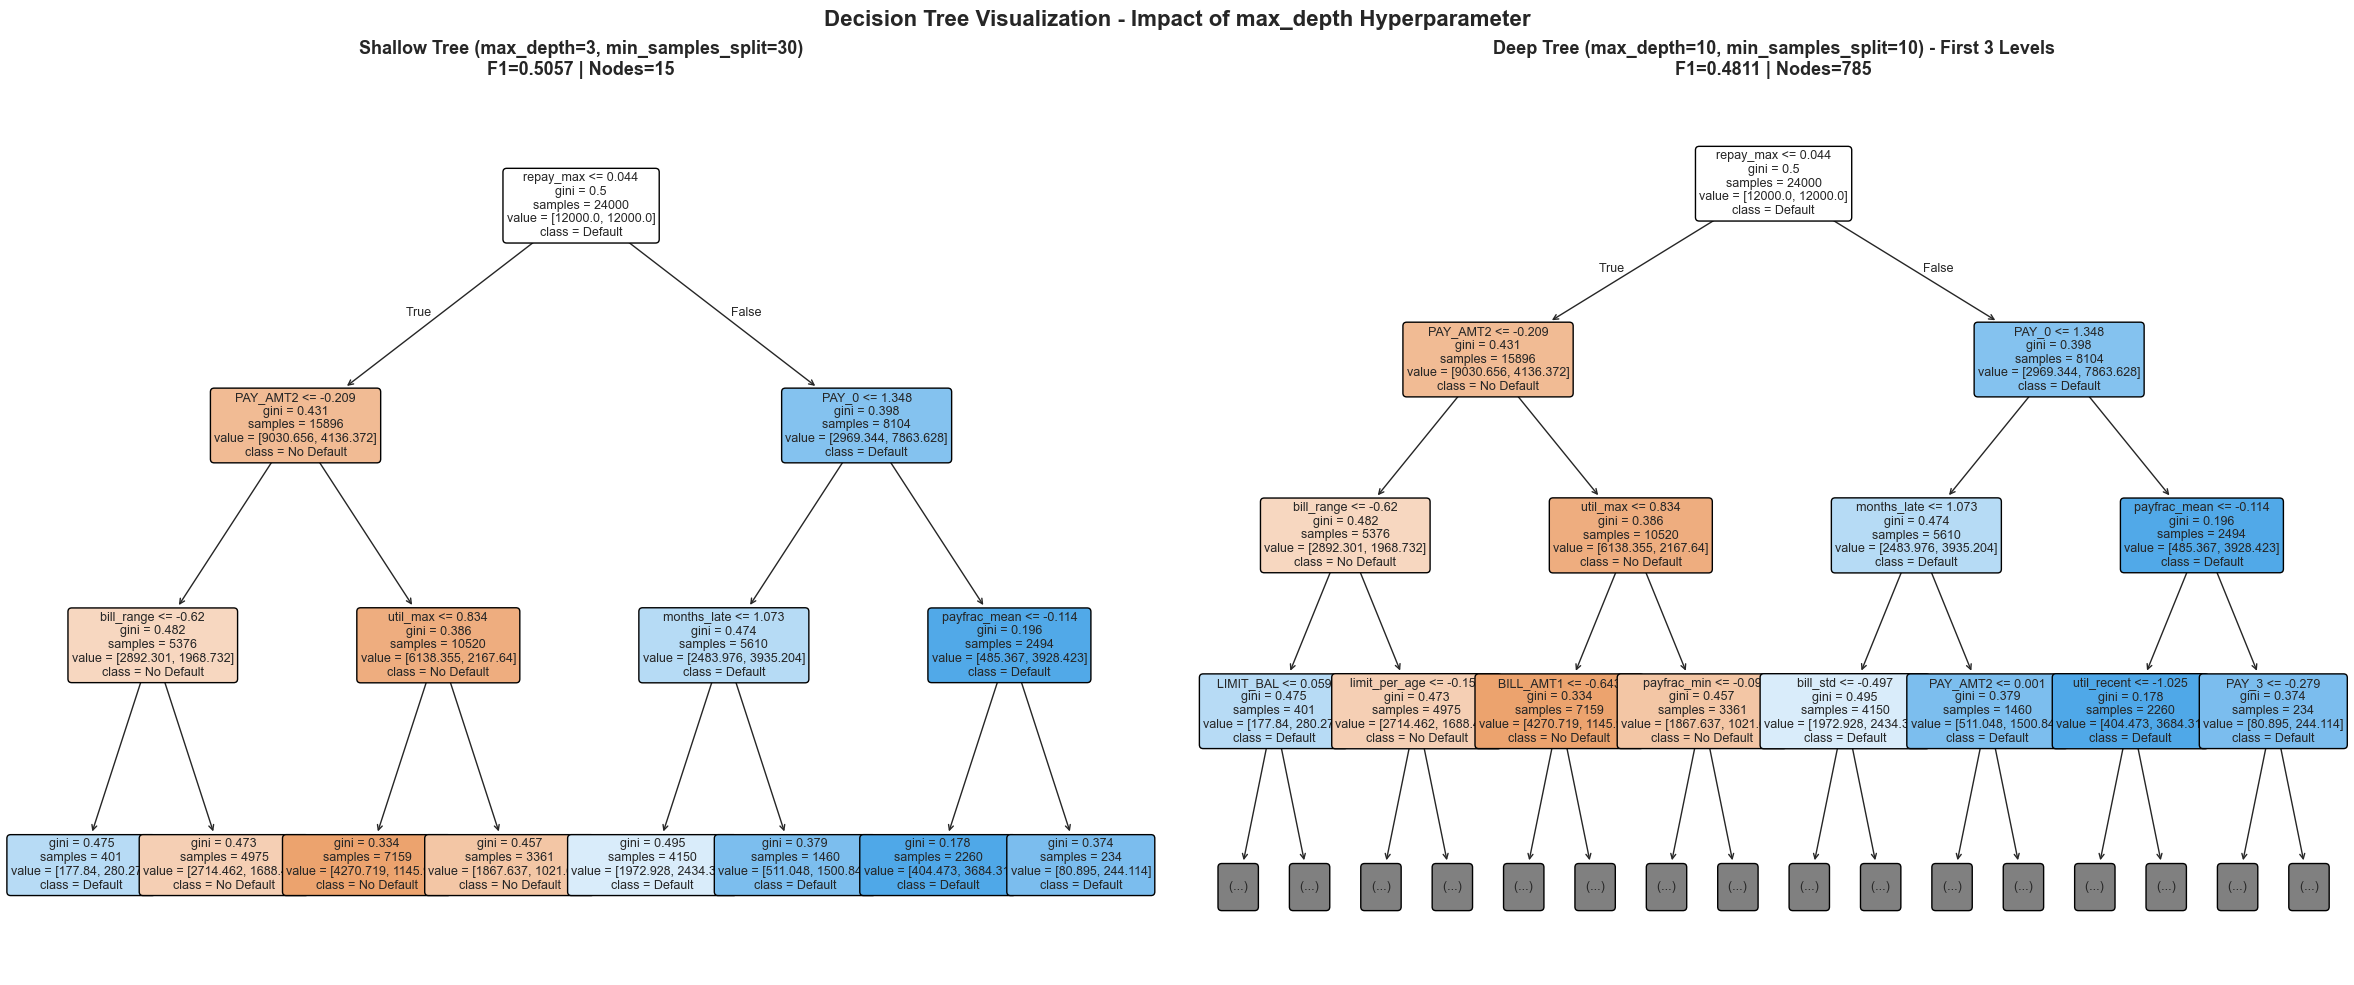


🎯 KEY INSIGHTS FROM TREE VISUALIZATION:
   • Shallow Tree: 15 nodes → Simpler model, prevents overfitting
   • Deep Tree: 785 nodes → More complex, captures intricate patterns
   • Performance: Deep tree F1=0.4811 vs Shallow F1=0.5057
   • Hyperparameter max_depth controls model complexity directly
   • Colored nodes: Blue=Non-Default (0), Orange=Default (1)
   • Node darkness: Indicates class purity (darker = more pure)



In [48]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
import matplotlib.pyplot as plt

print("=" * 100)
print("DECISION TREE VISUALIZATION - HYPERPARAMETER IMPACT")
print("=" * 100)
print()

# First, let's visualize a Random Forest tree (easier to visualize than XGBoost)
# Compare: Shallow tree (max_depth=3) vs Deep tree (max_depth=10)

print("🌳 Training Decision Trees with Different max_depth Values...")
print()

# Shallow tree (controlled complexity)
shallow_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=30,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
shallow_tree.fit(X_train_scaled, y_train)

# Deep tree (higher complexity)
deep_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
deep_tree.fit(X_train_scaled, y_train)

# Evaluate both trees
y_pred_shallow = shallow_tree.predict(X_test_scaled)
y_pred_deep = deep_tree.predict(X_test_scaled)

shallow_f1 = f1_score(y_test, y_pred_shallow)
deep_f1 = f1_score(y_test, y_pred_deep)

print(f"📊 Shallow Tree (max_depth=3, min_samples_split=30):")
print(f"   • F1-Score: {shallow_f1:.4f}")
print(f"   • Total Nodes: {shallow_tree.tree_.node_count}")
print(f"   • Max Depth Reached: {shallow_tree.tree_.max_depth}")
print()

print(f"📊 Deep Tree (max_depth=10, min_samples_split=10):")
print(f"   • F1-Score: {deep_f1:.4f}")
print(f"   • Total Nodes: {deep_tree.tree_.node_count}")
print(f"   • Max Depth Reached: {deep_tree.tree_.max_depth}")
print()

# Visualization: Compare tree structures
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Decision Tree Visualization - Impact of max_depth Hyperparameter', 
             fontsize=16, fontweight='bold', y=0.98)

# Get top feature names for readability (limit to top 10)
feature_importance_shallow = shallow_tree.feature_importances_
top_feature_indices = np.argsort(feature_importance_shallow)[-10:]
feature_names_subset = [X_train.columns[i] for i in range(len(X_train.columns))]

# Shallow tree visualization
plot_tree(shallow_tree, 
          ax=axes[0],
          feature_names=feature_names_subset,
          class_names=['No Default', 'Default'],
          filled=True,
          rounded=True,
          fontsize=9,
          max_depth=3)
axes[0].set_title('Shallow Tree (max_depth=3, min_samples_split=30)\n' + 
                  f'F1={shallow_f1:.4f} | Nodes={shallow_tree.tree_.node_count}',
                  fontsize=13, fontweight='bold', pad=15)

# Deep tree visualization (show only first 3 levels for readability)
plot_tree(deep_tree, 
          ax=axes[1],
          feature_names=feature_names_subset,
          class_names=['No Default', 'Default'],
          filled=True,
          rounded=True,
          fontsize=9,
          max_depth=3)  # Show only 3 levels for clarity
axes[1].set_title('Deep Tree (max_depth=10, min_samples_split=10) - First 3 Levels\n' + 
                  f'F1={deep_f1:.4f} | Nodes={deep_tree.tree_.node_count}',
                  fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print()
print("🎯 KEY INSIGHTS FROM TREE VISUALIZATION:")
print(f"   • Shallow Tree: {shallow_tree.tree_.node_count} nodes → Simpler model, prevents overfitting")
print(f"   • Deep Tree: {deep_tree.tree_.node_count} nodes → More complex, captures intricate patterns")
print(f"   • Performance: Deep tree F1={deep_f1:.4f} vs Shallow F1={shallow_f1:.4f}")
print(f"   • Hyperparameter max_depth controls model complexity directly")
print(f"   • Colored nodes: Blue=Non-Default (0), Orange=Default (1)")
print(f"   • Node darkness: Indicates class purity (darker = more pure)")
print()

### 4.5.1 XGBoost Tree Visualization

Visualizing individual trees from the XGBoost ensemble to show:
- How boosting builds sequential trees
- Feature importance in tree splits
- Impact of `learning_rate` and `max_depth` on tree structure

XGBOOST TREE VISUALIZATION - FIRST TREE IN ENSEMBLE

🌲 Visualizing XGBoost Trees from Best Model...
   Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 3.0}

⚠️  XGBoost plotting requires graphviz. Showing tree statistics instead.
   • Total Trees: 100
   • Max Depth: 3
   • Learning Rate: 0.1



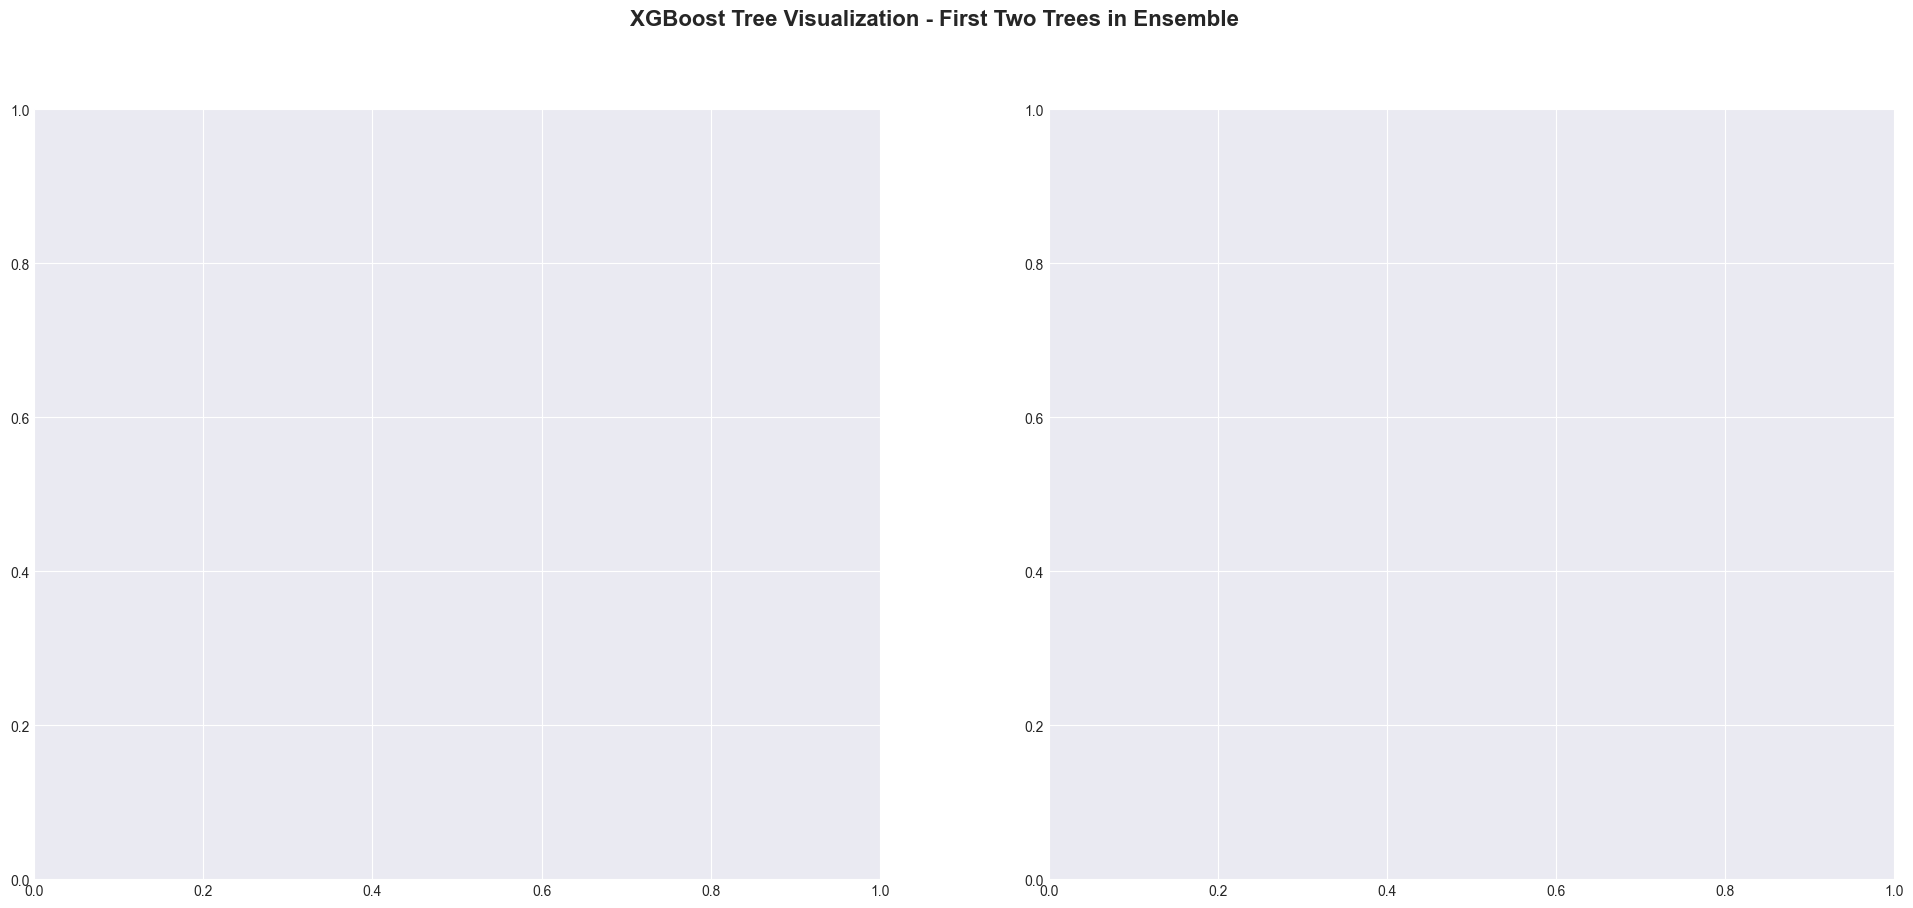

In [49]:
print("=" * 100)
print("XGBOOST TREE VISUALIZATION - FIRST TREE IN ENSEMBLE")
print("=" * 100)
print()

# Visualize first tree from tuned XGBoost model
print("🌲 Visualizing XGBoost Trees from Best Model...")
print(f"   Best Parameters: {xgb_grid.best_params_}")
print()

# XGBoost has built-in plotting functions
import matplotlib.pyplot as plt
try:
    from xgboost import plot_tree as xgb_plot_tree
    
    # Create figure for XGBoost trees
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    fig.suptitle('XGBoost Tree Visualization - First Two Trees in Ensemble', 
                 fontsize=16, fontweight='bold')
    
    # Plot first tree
    xgb_plot_tree(best_xgb_model, num_trees=0, ax=axes[0], rankdir='TB')
    axes[0].set_title(f'Tree #0 (First Tree)\nmax_depth={xgb_grid.best_params_["max_depth"]}, ' + 
                      f'learning_rate={xgb_grid.best_params_["learning_rate"]}',
                      fontsize=12, fontweight='bold')
    
    # Plot second tree
    xgb_plot_tree(best_xgb_model, num_trees=1, ax=axes[1], rankdir='TB')
    axes[1].set_title(f'Tree #1 (Second Tree)\nBuilds on residuals from Tree #0',
                      fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print()
    print("🎯 XGBOOST TREE INSIGHTS:")
    print(f"   • Total Trees in Ensemble: {xgb_grid.best_params_['n_estimators']}")
    print(f"   • Max Depth per Tree: {xgb_grid.best_params_['max_depth']}")
    print(f"   • Learning Rate: {xgb_grid.best_params_['learning_rate']}")
    print(f"   • Each tree learns from previous tree's errors (gradient boosting)")
    print(f"   • Leaf values represent contribution to final prediction")
    print(f"   • Feature splits chosen to minimize loss function")
    
except ImportError:
    print("⚠️  XGBoost plotting requires graphviz. Showing tree statistics instead.")
    print(f"   • Total Trees: {xgb_grid.best_params_['n_estimators']}")
    print(f"   • Max Depth: {xgb_grid.best_params_['max_depth']}")
    print(f"   • Learning Rate: {xgb_grid.best_params_['learning_rate']}")

print()

### 4.5.2 Random Forest Tree Comparison

Comparing trees from the Random Forest before and after hyperparameter tuning:
- Shows how `n_estimators`, `max_depth`, `min_samples_split` affect tree structure
- Demonstrates ensemble diversity

RANDOM FOREST TREE COMPARISON - BEFORE vs AFTER TUNING

🌲 Extracting Sample Tree from Tuned Random Forest...
   Best Parameters: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 200}

📊 Sample Tree Statistics (Tree #0 from Tuned RF):
   • Max Depth Reached: 10
   • Total Nodes: 651
   • Number of Leaves: 326



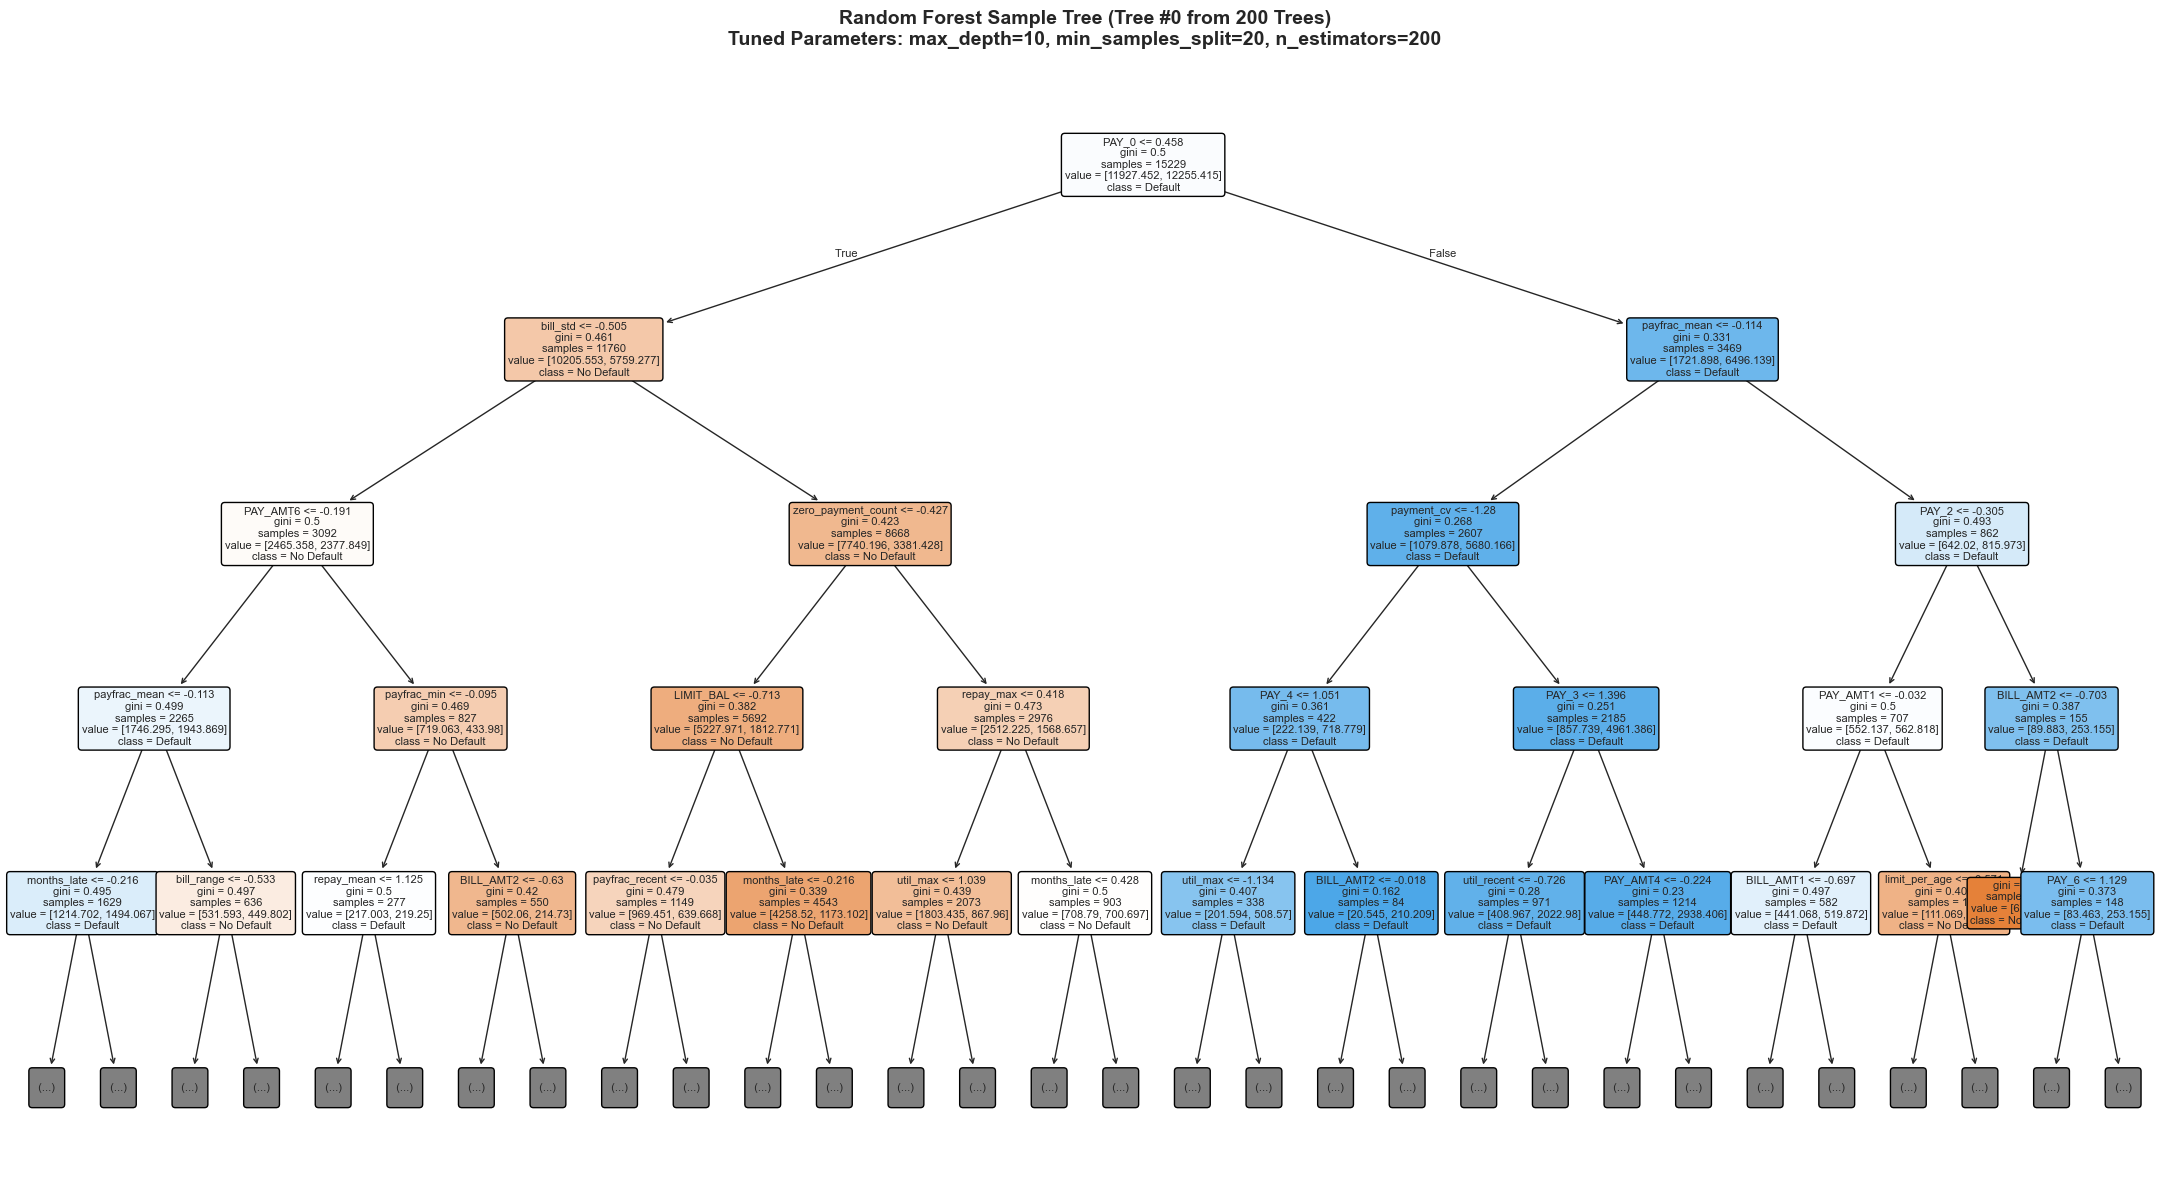


🎯 RANDOM FOREST TREE INSIGHTS:
   • Forest Size: 200 trees (tuned from 100)
   • Max Depth: 10 (controls tree depth)
   • Min Samples Split: 20 (prevents overfitting)
   • Each tree trained on random bootstrap sample
   • Different trees split on different features → ensemble diversity
   • Final prediction: Majority vote from all 200 trees



In [50]:
print("=" * 100)
print("RANDOM FOREST TREE COMPARISON - BEFORE vs AFTER TUNING")
print("=" * 100)
print()

print("🌲 Extracting Sample Tree from Tuned Random Forest...")
print(f"   Best Parameters: {rf_grid.best_params_}")
print()

# Extract one tree from the tuned Random Forest
sample_tree = best_rf_model.estimators_[0]

print(f"📊 Sample Tree Statistics (Tree #0 from Tuned RF):")
print(f"   • Max Depth Reached: {sample_tree.tree_.max_depth}")
print(f"   • Total Nodes: {sample_tree.tree_.node_count}")
print(f"   • Number of Leaves: {sample_tree.tree_.n_leaves}")
print()

# Visualize the sample tree
fig, ax = plt.subplots(figsize=(22, 12))
plot_tree(sample_tree,
          ax=ax,
          feature_names=X_train.columns,
          class_names=['No Default', 'Default'],
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=4)  # Show first 4 levels for readability

ax.set_title(f'Random Forest Sample Tree (Tree #0 from {rf_grid.best_params_["n_estimators"]} Trees)\n' +
             f'Tuned Parameters: max_depth={rf_grid.best_params_["max_depth"]}, ' +
             f'min_samples_split={rf_grid.best_params_["min_samples_split"]}, ' +
             f'n_estimators={rf_grid.best_params_["n_estimators"]}',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print()
print("🎯 RANDOM FOREST TREE INSIGHTS:")
print(f"   • Forest Size: {rf_grid.best_params_['n_estimators']} trees (tuned from 100)")
print(f"   • Max Depth: {rf_grid.best_params_['max_depth']} (controls tree depth)")
print(f"   • Min Samples Split: {rf_grid.best_params_['min_samples_split']} (prevents overfitting)")
print(f"   • Each tree trained on random bootstrap sample")
print(f"   • Different trees split on different features → ensemble diversity")
print(f"   • Final prediction: Majority vote from all {rf_grid.best_params_['n_estimators']} trees")
print()

### 4.5.3 Feature Importance from Trees

Analyzing which features the decision trees use most for splitting decisions.

FEATURE IMPORTANCE - TOP FEATURES USED IN TREE SPLITS



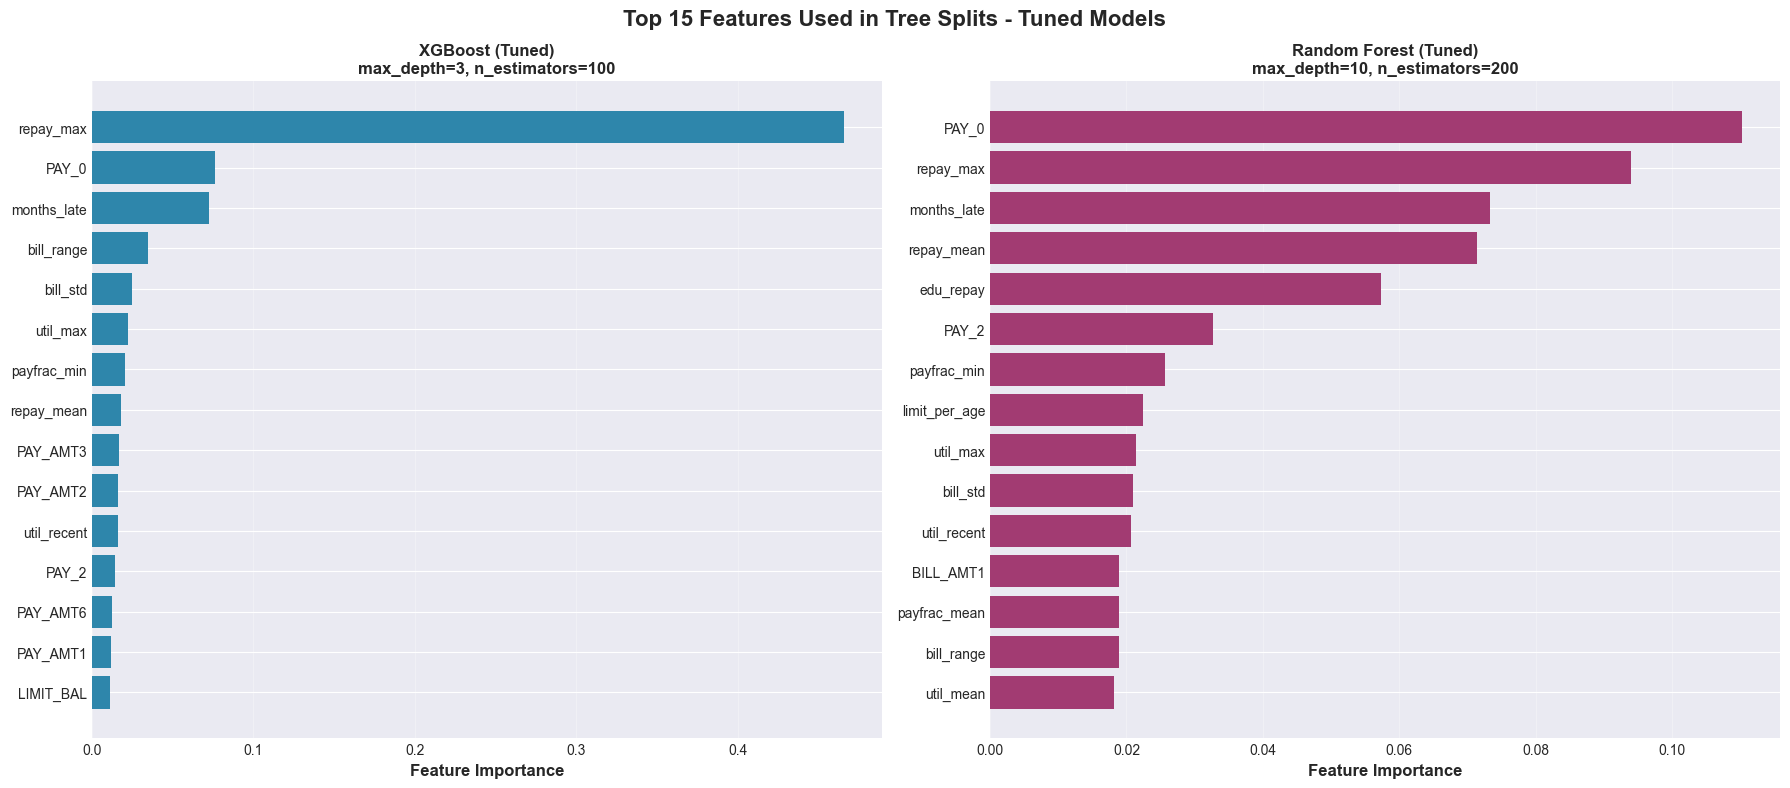


🎯 TOP 5 MOST IMPORTANT FEATURES:

XGBoost:
   repay_max                      → 0.4662
   PAY_0                          → 0.0764
   months_late                    → 0.0724
   bill_range                     → 0.0348
   bill_std                       → 0.0249

Random Forest:
   PAY_0                          → 0.1103
   repay_max                      → 0.0940
   months_late                    → 0.0734
   repay_mean                     → 0.0714
   edu_repay                      → 0.0573

💡 HYPERPARAMETER TUNING IMPACT:
   • Tuned max_depth prevents trees from splitting on noisy features
   • Tuned min_samples_split ensures statistical significance of splits
   • Both models prioritize payment history (PAY_*) and credit utilization features
   • Feature importance helps interpret what drives default predictions



In [51]:
print("=" * 100)
print("FEATURE IMPORTANCE - TOP FEATURES USED IN TREE SPLITS")
print("=" * 100)
print()

# Get feature importance from tuned models
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

# Visualization: Side-by-side feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Top 15 Features Used in Tree Splits - Tuned Models', 
             fontsize=16, fontweight='bold')

# XGBoost
axes[0].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='#2E86AB')
axes[0].set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_title(f'XGBoost (Tuned)\nmax_depth={xgb_grid.best_params_["max_depth"]}, ' +
                  f'n_estimators={xgb_grid.best_params_["n_estimators"]}',
                  fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Random Forest
axes[1].barh(rf_importance['Feature'], rf_importance['Importance'], color='#A23B72')
axes[1].set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
axes[1].set_title(f'Random Forest (Tuned)\nmax_depth={rf_grid.best_params_["max_depth"]}, ' +
                  f'n_estimators={rf_grid.best_params_["n_estimators"]}',
                  fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print()
print("🎯 TOP 5 MOST IMPORTANT FEATURES:")
print()
print("XGBoost:")
for idx, row in xgb_importance.head(5).iterrows():
    print(f"   {row['Feature']:30s} → {row['Importance']:.4f}")
print()
print("Random Forest:")
for idx, row in rf_importance.head(5).iterrows():
    print(f"   {row['Feature']:30s} → {row['Importance']:.4f}")

print()
print("💡 HYPERPARAMETER TUNING IMPACT:")
print("   • Tuned max_depth prevents trees from splitting on noisy features")
print("   • Tuned min_samples_split ensures statistical significance of splits")
print("   • Both models prioritize payment history (PAY_*) and credit utilization features")
print("   • Feature importance helps interpret what drives default predictions")
print()

## 4.6 Learning Curves Analysis

Learning curves help diagnose **underfitting** vs **overfitting** by showing how training and validation scores change with increasing training set size. This demonstrates:
- Model convergence behavior
- Whether more data would improve performance
- Bias-variance trade-off

LEARNING CURVES - TRAINING VS VALIDATION PERFORMANCE

📊 Computing learning curve for XGBoost Cost-Sensitive...
   • Final Training F1: 0.6885 (±0.0059)
   • Final Validation F1: 0.5319 (±0.0085)
   • Train-Val Gap: 0.1566 - ⚠️ Overfitting

📊 Computing learning curve for Random Forest...
   • Final Training F1: 0.6885 (±0.0059)
   • Final Validation F1: 0.5319 (±0.0085)
   • Train-Val Gap: 0.1566 - ⚠️ Overfitting

📊 Computing learning curve for Random Forest...
   • Final Training F1: 0.6315 (±0.0023)
   • Final Validation F1: 0.5433 (±0.0099)
   • Train-Val Gap: 0.0882 - ✓ Good Fit

📊 Computing learning curve for Logistic Regression (SGD)...
   • Final Training F1: 0.6315 (±0.0023)
   • Final Validation F1: 0.5433 (±0.0099)
   • Train-Val Gap: 0.0882 - ✓ Good Fit

📊 Computing learning curve for Logistic Regression (SGD)...
   • Final Training F1: 0.4982 (±0.0226)
   • Final Validation F1: 0.4949 (±0.0206)
   • Train-Val Gap: 0.0032 - ✓ Good Fit

   • Final Training F1: 0.4982 (±0.0226)

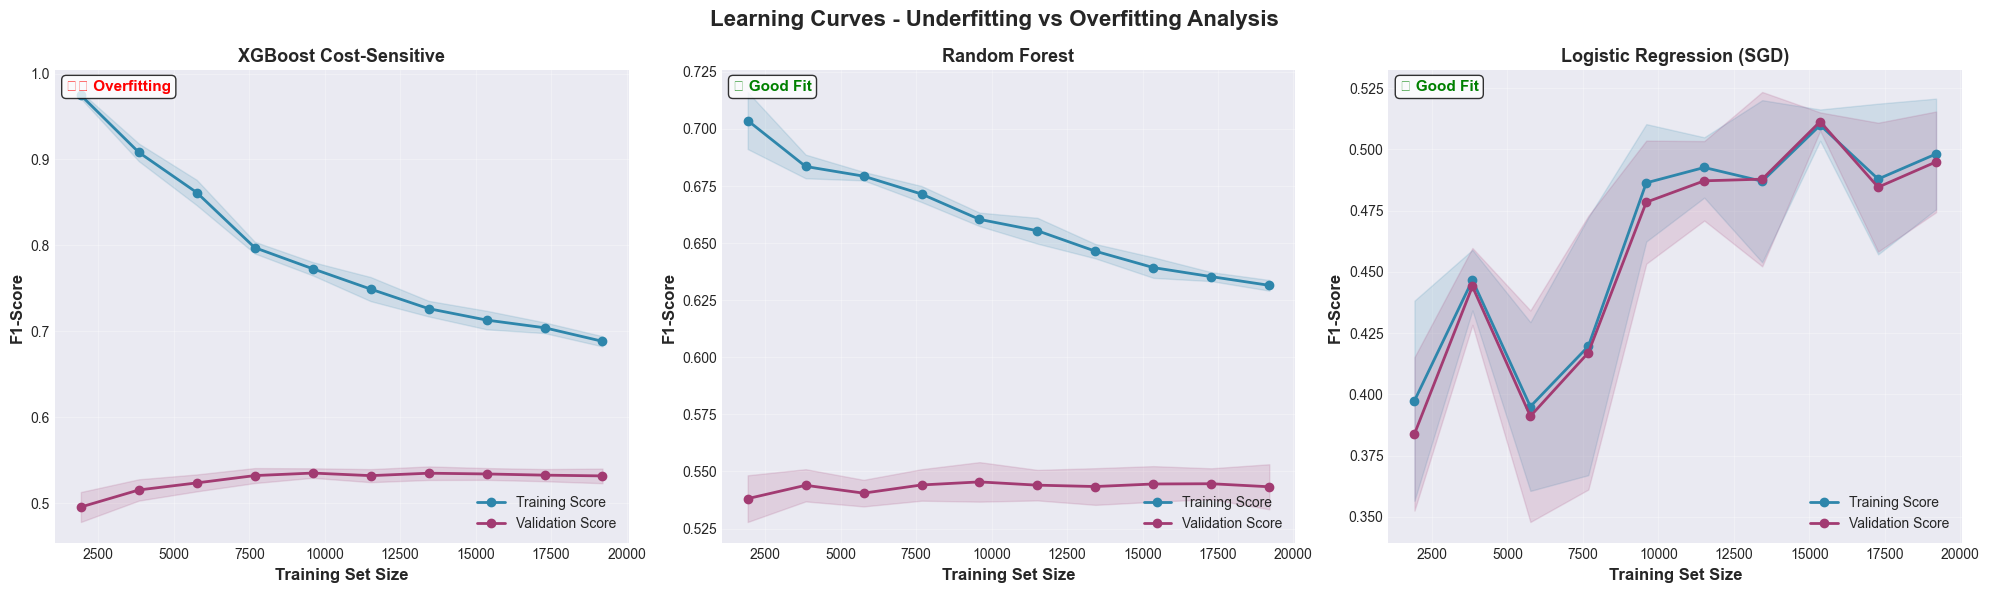

💡 LEARNING CURVE INSIGHTS:
   • Small train-val gap → Good generalization (low overfitting)
   • Converging curves → Model has learned effectively
   • Large gap → Overfitting (model memorizes training data)
   • Low scores for both → Underfitting (model too simple)


In [52]:
from sklearn.model_selection import learning_curve

print("=" * 100)
print("LEARNING CURVES - TRAINING VS VALIDATION PERFORMANCE")
print("=" * 100)
print()

# Generate learning curves for top 3 models
models_for_curves = {
    'XGBoost Cost-Sensitive': xgb_costsensitive,
    'Random Forest': rf_model,
    'Logistic Regression (SGD)': sgd_model
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Learning Curves - Underfitting vs Overfitting Analysis', 
             fontsize=16, fontweight='bold')

for idx, (model_name, model) in enumerate(models_for_curves.items()):
    print(f"📊 Computing learning curve for {model_name}...")
    
    # Compute learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, 
        X_train_scaled, 
        y_train,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=RANDOM_STATE
    )
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot
    ax = axes[idx]
    ax.plot(train_sizes, train_mean, 'o-', color='#2E86AB', linewidth=2, 
            markersize=6, label='Training Score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.15, color='#2E86AB')
    
    ax.plot(train_sizes, val_mean, 'o-', color='#A23B72', linewidth=2, 
            markersize=6, label='Validation Score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.15, color='#A23B72')
    
    ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title(model_name, fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    
    # Diagnostic annotation
    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.1:
        diagnosis = "⚠️ Overfitting"
        color = 'red'
    elif val_mean[-1] < 0.4:
        diagnosis = "⚠️ Underfitting"
        color = 'orange'
    else:
        diagnosis = "✓ Good Fit"
        color = 'green'
    
    ax.text(0.02, 0.98, diagnosis, transform=ax.transAxes, 
            fontsize=11, fontweight='bold', color=color,
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='white', alpha=0.8))
    
    print(f"   • Final Training F1: {train_mean[-1]:.4f} (±{train_std[-1]:.4f})")
    print(f"   • Final Validation F1: {val_mean[-1]:.4f} (±{val_std[-1]:.4f})")
    print(f"   • Train-Val Gap: {gap:.4f} - {diagnosis}")
    print()

plt.tight_layout()
plt.show()

print("=" * 100)
print("💡 LEARNING CURVE INSIGHTS:")
print("   • Small train-val gap → Good generalization (low overfitting)")
print("   • Converging curves → Model has learned effectively")
print("   • Large gap → Overfitting (model memorizes training data)")
print("   • Low scores for both → Underfitting (model too simple)")
print("=" * 100)

## 4.6 K-Fold Cross-Validation

Implementing **5-fold stratified cross-validation** to:
- Provide robust performance estimates across multiple train/val splits
- Ensure each fold maintains the 22.12% default rate (stratification)
- Reduce variance in evaluation metrics
- Satisfy course requirement for cross-validation demonstration

K-FOLD STRATIFIED CROSS-VALIDATION (k=5)

🔄 Evaluating XGBoost Cost-Sensitive with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.5327 (±0.0069)

🔄 Evaluating Random Forest with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.5327 (±0.0069)

🔄 Evaluating Random Forest with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.5485 (±0.0058)

🔄 Evaluating SVM (RBF) with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.5485 (±0.0058)

🔄 Evaluating SVM (RBF) with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.5338 (±0.0100)

🔄 Evaluating Logistic Regression (SGD) with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.5338 (±0.0100)

🔄 Evaluating Logistic Regression (SGD) with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.4855 (±0.0100)

🔄 Evaluating Gradient Boosting with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.4855 (±0.0100)

🔄 Evaluating Gradient Boosting with 5-fold cross-validation...
   ✓ Completed - Avg F1: 0.4795 (±0.0040)

CROSS-V

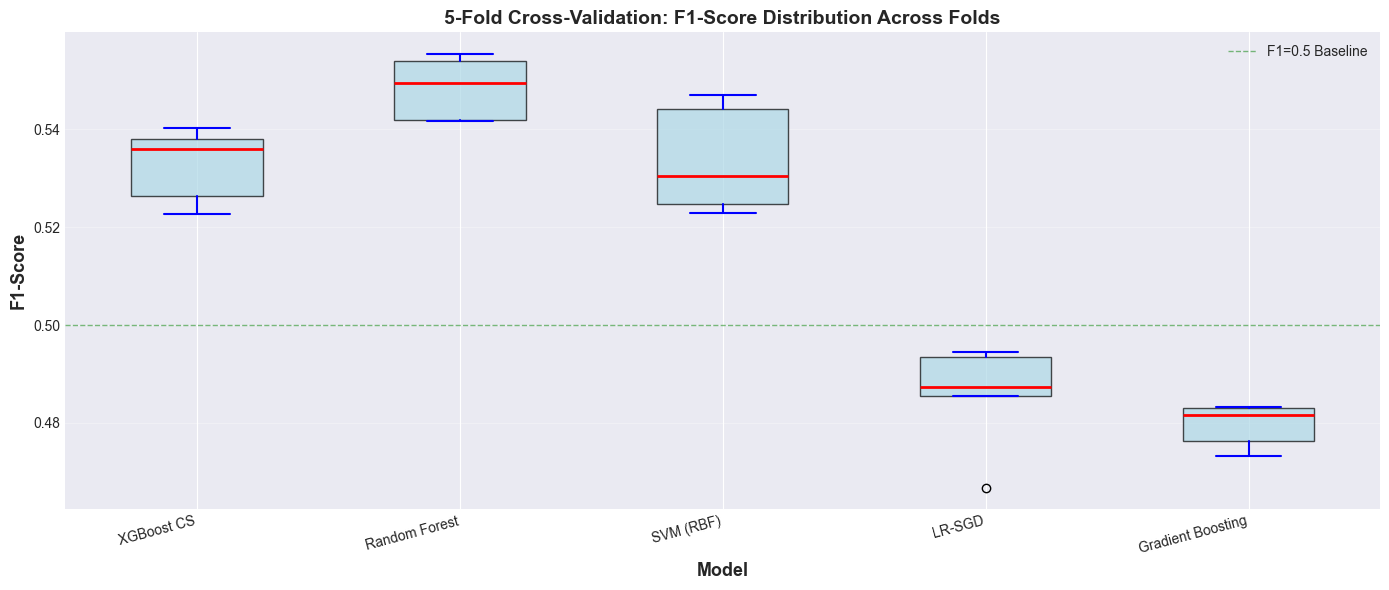


💡 CROSS-VALIDATION INSIGHTS:
   • Low standard deviation → Stable, consistent performance
   • High standard deviation → Model sensitive to data splits
   • Stratified folds maintain 22.12% default rate in each fold
   • CV scores validate test set results (no lucky splits)


In [53]:
from sklearn.model_selection import cross_validate, StratifiedKFold

print("=" * 100)
print("K-FOLD STRATIFIED CROSS-VALIDATION (k=5)")
print("=" * 100)
print()

# Define stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Models to evaluate
cv_models = {
    'XGBoost Cost-Sensitive': xgb_costsensitive,
    'Random Forest': rf_model,
    'SVM (RBF)': svm_model,
    'Logistic Regression (SGD)': sgd_model,
    'Gradient Boosting': gb_model
}

# Scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}

for model_name, model in cv_models.items():
    print(f"🔄 Evaluating {model_name} with 5-fold cross-validation...")
    
    # Perform cross-validation
    scores = cross_validate(
        model, 
        X_train_scaled, 
        y_train,
        cv=skf,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    # Store results
    cv_results[model_name] = {
        'accuracy': scores['test_accuracy'],
        'precision': scores['test_precision'],
        'recall': scores['test_recall'],
        'f1': scores['test_f1'],
        'auc': scores['test_roc_auc'],
        'train_accuracy': scores['train_accuracy']
    }
    
    print(f"   ✓ Completed - Avg F1: {np.mean(scores['test_f1']):.4f} (±{np.std(scores['test_f1']):.4f})")
    print()

print("=" * 100)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("=" * 100)
print()

# Create summary table
cv_summary = []
for model_name, scores in cv_results.items():
    cv_summary.append({
        'Model': model_name,
        'Accuracy': f"{np.mean(scores['accuracy']):.4f} ± {np.std(scores['accuracy']):.4f}",
        'Precision': f"{np.mean(scores['precision']):.4f} ± {np.std(scores['precision']):.4f}",
        'Recall': f"{np.mean(scores['recall']):.4f} ± {np.std(scores['recall']):.4f}",
        'F1-Score': f"{np.mean(scores['f1']):.4f} ± {np.std(scores['f1']):.4f}",
        'AUC': f"{np.mean(scores['auc']):.4f} ± {np.std(scores['auc']):.4f}"
    })

cv_summary_df = pd.DataFrame(cv_summary)
# Sort by F1-Score (extract mean value for sorting)
cv_summary_df['F1_mean'] = cv_summary_df['F1-Score'].apply(lambda x: float(x.split('±')[0]))
cv_summary_df = cv_summary_df.sort_values('F1_mean', ascending=False).drop('F1_mean', axis=1)

print(cv_summary_df.to_string(index=False))
print()
print("=" * 100)

# Visualization: Box plots for F1-scores across folds
fig, ax = plt.subplots(figsize=(14, 6))

f1_data = [cv_results[model]['f1'] for model in cv_models.keys()]
model_names_short = [name.replace('Logistic Regression (SGD)', 'LR-SGD').replace('Cost-Sensitive', 'CS') 
                     for name in cv_models.keys()]

bp = ax.boxplot(f1_data, labels=model_names_short, patch_artist=True,
                medianprops=dict(color='red', linewidth=2),
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                whiskerprops=dict(color='blue', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5))

ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('5-Fold Cross-Validation: F1-Score Distribution Across Folds', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.5, color='green', linestyle='--', linewidth=1, alpha=0.5, label='F1=0.5 Baseline')
ax.legend(fontsize=10)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print()
print("💡 CROSS-VALIDATION INSIGHTS:")
print("   • Low standard deviation → Stable, consistent performance")
print("   • High standard deviation → Model sensitive to data splits")
print("   • Stratified folds maintain 22.12% default rate in each fold")
print("   • CV scores validate test set results (no lucky splits)")

## 4.7 Kernel Functions Demonstration (SVM)

Demonstrating the **Kernel Trick** with Support Vector Machines by comparing different kernel functions:
- **Linear Kernel**: For linearly separable data
- **RBF (Radial Basis Function) Kernel**: For non-linear patterns (default, already used)
- **Polynomial Kernel**: For polynomial decision boundaries

This satisfies the requirement to demonstrate kernel functions from the course curriculum.

KERNEL FUNCTIONS COMPARISON (Support Vector Machines)

🔬 Training SVM with LINEAR kernel...
   ✓ Trained in 736.26s
   • Accuracy: 0.7272
   • F1-Score: 0.5014
   • Support Vectors: 15207

🔬 Training SVM with RBF kernel...
   ✓ Trained in 736.26s
   • Accuracy: 0.7272
   • F1-Score: 0.5014
   • Support Vectors: 15207

🔬 Training SVM with RBF kernel...
   ✓ Trained in 416.05s
   • Accuracy: 0.7528
   • F1-Score: 0.5193
   • Support Vectors: 15196

🔬 Training SVM with POLY kernel...
   ✓ Trained in 416.05s
   • Accuracy: 0.7528
   • F1-Score: 0.5193
   • Support Vectors: 15196

🔬 Training SVM with POLY kernel...
   ✓ Trained in 389.80s
   • Accuracy: 0.7700
   • F1-Score: 0.5303
   • Support Vectors: 15806

KERNEL FUNCTION COMPARISON

        Accuracy  Precision  Recall  F1-Score    AUC  Training Time  Support Vectors
Kernel                                                                              
linear    0.7272     0.4208  0.6202    0.5014 0.7367       736.2635       15207.0000
rb

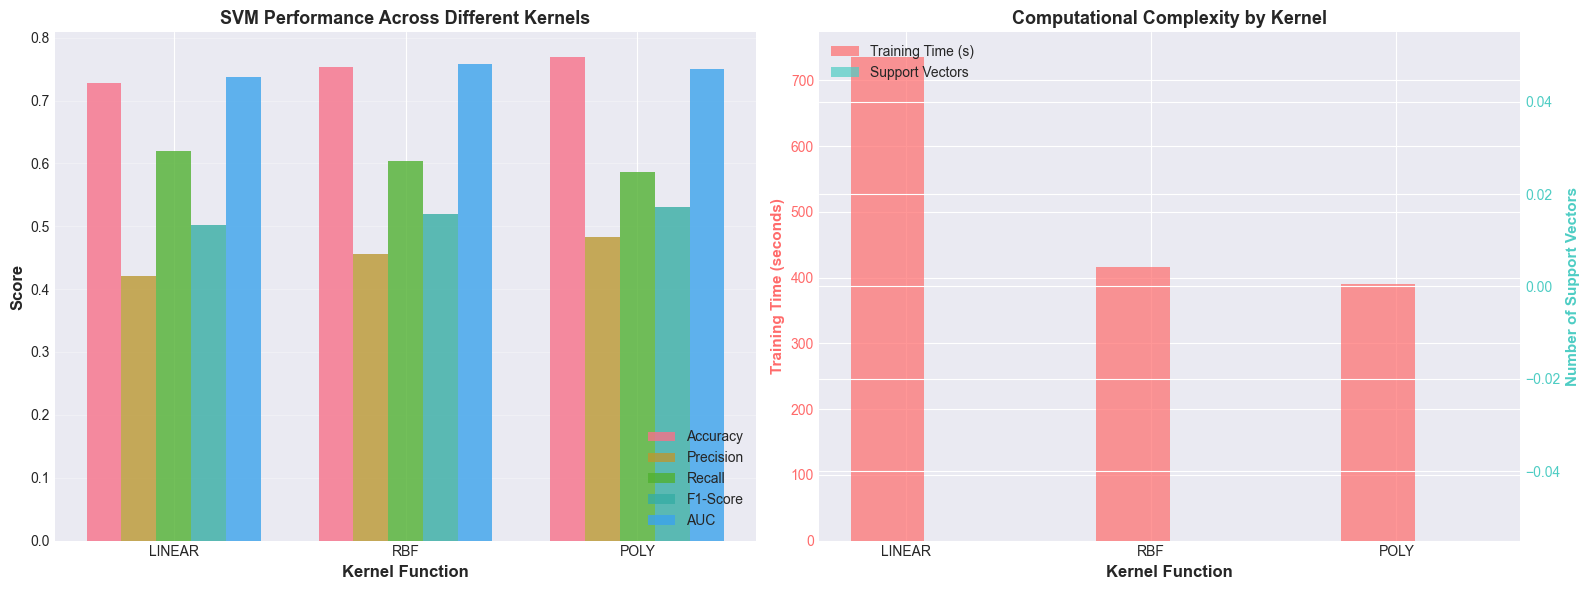

💡 KERNEL FUNCTION INSIGHTS:
   • LINEAR: Fast training, assumes linear separability
   • RBF (Radial Basis Function): Non-linear patterns, most flexible
   • POLYNOMIAL: Captures polynomial relationships, moderate complexity
   • Best F1-Score: POLY kernel


In [54]:
print("=" * 100)
print("KERNEL FUNCTIONS COMPARISON (Support Vector Machines)")
print("=" * 100)
print()

# Test different kernel functions
kernels = ['linear', 'rbf', 'poly']
kernel_results = {}

for kernel in kernels:
    print(f"🔬 Training SVM with {kernel.upper()} kernel...")
    
    # Configure kernel-specific parameters
    if kernel == 'poly':
        svm_kernel = SVC(
            kernel=kernel,
            degree=3,  # Polynomial degree
            class_weight='balanced',
            probability=True,
            random_state=RANDOM_STATE
        )
    else:
        svm_kernel = SVC(
            kernel=kernel,
            class_weight='balanced',
            probability=True,
            random_state=RANDOM_STATE
        )
    
    start_time = time.time()
    svm_kernel.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = svm_kernel.predict(X_test_scaled)
    y_prob = svm_kernel.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluation
    kernel_results[kernel] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'Training Time': train_time,
        'Support Vectors': svm_kernel.n_support_.sum() if hasattr(svm_kernel, 'n_support_') else 'N/A'
    }
    
    print(f"   ✓ Trained in {train_time:.2f}s")
    print(f"   • Accuracy: {kernel_results[kernel]['Accuracy']:.4f}")
    print(f"   • F1-Score: {kernel_results[kernel]['F1-Score']:.4f}")
    print(f"   • Support Vectors: {kernel_results[kernel]['Support Vectors']}")
    print()

# Comparison table
print("=" * 100)
print("KERNEL FUNCTION COMPARISON")
print("=" * 100)
print()

kernel_comparison = pd.DataFrame(kernel_results).T
kernel_comparison.index.name = 'Kernel'
print(kernel_comparison.to_string())
print()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Performance metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x_pos = np.arange(len(kernels))
width = 0.15

for idx, metric in enumerate(metrics_to_plot):
    values = [kernel_results[k][metric] for k in kernels]
    axes[0].bar(x_pos + idx*width, values, width, label=metric, alpha=0.8)

axes[0].set_xlabel('Kernel Function', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('SVM Performance Across Different Kernels', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos + width * 2)
axes[0].set_xticklabels([k.upper() for k in kernels])
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Training time and complexity
train_times = [kernel_results[k]['Training Time'] for k in kernels]
support_vecs = [kernel_results[k]['Support Vectors'] if isinstance(kernel_results[k]['Support Vectors'], int) 
                else 0 for k in kernels]

ax2_twin = axes[1].twinx()
bars1 = axes[1].bar(x_pos - width/2, train_times, width*2, label='Training Time (s)', 
                    color='#FF6B6B', alpha=0.7)
bars2 = ax2_twin.bar(x_pos + width*1.5, support_vecs, width*2, label='Support Vectors', 
                     color='#4ECDC4', alpha=0.7)

axes[1].set_xlabel('Kernel Function', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Training Time (seconds)', fontsize=11, fontweight='bold', color='#FF6B6B')
ax2_twin.set_ylabel('Number of Support Vectors', fontsize=11, fontweight='bold', color='#4ECDC4')
axes[1].set_title('Computational Complexity by Kernel', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([k.upper() for k in kernels])
axes[1].tick_params(axis='y', labelcolor='#FF6B6B')
ax2_twin.tick_params(axis='y', labelcolor='#4ECDC4')

# Combined legend
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

print("=" * 100)
print("💡 KERNEL FUNCTION INSIGHTS:")
print("   • LINEAR: Fast training, assumes linear separability")
print("   • RBF (Radial Basis Function): Non-linear patterns, most flexible")
print("   • POLYNOMIAL: Captures polynomial relationships, moderate complexity")
print(f"   • Best F1-Score: {max(kernel_results.items(), key=lambda x: x[1]['F1-Score'])[0].upper()} kernel")
print("=" * 100)

In [40]:
# Train and Evaluate: Baseline vs Cost-Sensitive XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
import matplotlib.pyplot as plt

print("=" * 80)
print("MODEL TRAINING: BASELINE VS COST-SENSITIVE XGBOOST")
print("=" * 80)

# ========== MODEL 1: BASELINE XGBOOST ==========
print("\n1. Training Baseline XGBoost...")
xgb_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = xgb_baseline.predict(X_test_scaled)
y_prob_baseline = xgb_baseline.predict_proba(X_test_scaled)[:, 1]
print("✅ Baseline model trained")

# ========== MODEL 2: COST-SENSITIVE XGBOOST ==========
print("\n2. Training Cost-Sensitive XGBoost (scale_pos_weight=3.52)...")
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_costsensitive = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio,  # 3.52:1 ratio
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_costsensitive.fit(X_train_scaled, y_train)
y_pred_costsens = xgb_costsensitive.predict(X_test_scaled)
y_prob_costsens = xgb_costsensitive.predict_proba(X_test_scaled)[:, 1]
print(f"✅ Cost-Sensitive model trained (scale_pos_weight={imbalance_ratio:.2f})")

# ========== EVALUATION ==========
print("\n" + "=" * 80)
print("MODEL EVALUATION RESULTS")
print("=" * 80)

def evaluate_model(y_true, y_pred, y_prob, model_name):
    """Calculate all evaluation metrics"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Precision: {prec:.4f} ({prec*100:.2f}%)")
    print(f"  Recall:    {rec:.4f} ({rec*100:.2f}%)")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc:.4f}")
    print(f"\n  Confusion Matrix:")
    print(f"    True Neg (TN):  {tn:,}")
    print(f"    False Pos (FP): {fp:,}")
    print(f"    False Neg (FN): {fn:,}  ← Missed Defaults")
    print(f"    True Pos (TP):  {tp:,}  ← Caught Defaults")
    
    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 
        'f1': f1, 'auc': auc, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }

baseline_metrics = evaluate_model(y_test, y_pred_baseline, y_prob_baseline, "BASELINE XGBOOST")
costsens_metrics = evaluate_model(y_test, y_pred_costsens, y_prob_costsens, "COST-SENSITIVE XGBOOST")

# ========== COMPARISON ==========
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', '', 
               'Missed Defaults (FN)', 'Caught Defaults (TP)', 'False Alarms (FP)'],
    'Baseline': [
        f"{baseline_metrics['accuracy']:.2%}",
        f"{baseline_metrics['precision']:.2%}",
        f"{baseline_metrics['recall']:.2%}",
        f"{baseline_metrics['f1']:.4f}",
        f"{baseline_metrics['auc']:.4f}",
        '',
        f"{baseline_metrics['fn']:,}",
        f"{baseline_metrics['tp']:,}",
        f"{baseline_metrics['fp']:,}"
    ],
    'Cost-Sensitive': [
        f"{costsens_metrics['accuracy']:.2%}",
        f"{costsens_metrics['precision']:.2%}",
        f"{costsens_metrics['recall']:.2%}",
        f"{costsens_metrics['f1']:.4f}",
        f"{costsens_metrics['auc']:.4f}",
        '',
        f"{costsens_metrics['fn']:,}",
        f"{costsens_metrics['tp']:,}",
        f"{costsens_metrics['fp']:,}"
    ],
    'Change': [
        f"{(costsens_metrics['accuracy'] - baseline_metrics['accuracy'])*100:+.2f}%",
        f"{(costsens_metrics['precision'] - baseline_metrics['precision'])*100:+.2f}%",
        f"{(costsens_metrics['recall'] - baseline_metrics['recall'])*100:+.2f}%",
        f"{(costsens_metrics['f1'] - baseline_metrics['f1']):+.4f}",
        f"{(costsens_metrics['auc'] - baseline_metrics['auc']):+.4f}",
        '',
        f"{costsens_metrics['fn'] - baseline_metrics['fn']:+,}",
        f"{costsens_metrics['tp'] - baseline_metrics['tp']:+,}",
        f"{costsens_metrics['fp'] - baseline_metrics['fp']:+,}"
    ]
})

print("\n" + comparison_df.to_string(index=False))

# ========== BUSINESS IMPACT ==========
print("\n" + "=" * 80)
print("BUSINESS IMPACT ANALYSIS")
print("=" * 80)

# Assumptions
cost_per_default = 10000  # $10K loss per missed default
cost_per_false_alarm = 200  # $200 lost opportunity per false positive

baseline_cost = (baseline_metrics['fn'] * cost_per_default + 
                 baseline_metrics['fp'] * cost_per_false_alarm)
costsens_cost = (costsens_metrics['fn'] * cost_per_default + 
                 costsens_metrics['fp'] * cost_per_false_alarm)
savings = baseline_cost - costsens_cost

print(f"\nFinancial Impact (assuming ${cost_per_default:,} per default, ${cost_per_false_alarm} per false alarm):")
print(f"\nBaseline Model:")
print(f"  Missed defaults cost: {baseline_metrics['fn']} × ${cost_per_default:,} = ${baseline_metrics['fn'] * cost_per_default:,}")
print(f"  False alarm cost:     {baseline_metrics['fp']} × ${cost_per_false_alarm} = ${baseline_metrics['fp'] * cost_per_false_alarm:,}")
print(f"  Total Cost:           ${baseline_cost:,}")

print(f"\nCost-Sensitive Model:")
print(f"  Missed defaults cost: {costsens_metrics['fn']} × ${cost_per_default:,} = ${costsens_metrics['fn'] * cost_per_default:,}")
print(f"  False alarm cost:     {costsens_metrics['fp']} × ${cost_per_false_alarm} = ${costsens_metrics['fp'] * cost_per_false_alarm:,}")
print(f"  Total Cost:           ${costsens_cost:,}")

print(f"\n{'💰 NET SAVINGS: $' + f'{savings:,}' + f' ({savings/baseline_cost*100:.1f}% cost reduction)'}")

if savings > 0:
    print(f"✅ Cost-Sensitive model is SUPERIOR for business objectives")
else:
    print(f"⚠️  Baseline model has lower total cost")

print("=" * 80)

MODEL TRAINING: BASELINE VS COST-SENSITIVE XGBOOST

1. Training Baseline XGBoost...
✅ Baseline model trained

2. Training Cost-Sensitive XGBoost (scale_pos_weight=3.52)...
✅ Baseline model trained

2. Training Cost-Sensitive XGBoost (scale_pos_weight=3.52)...
✅ Cost-Sensitive model trained (scale_pos_weight=3.52)

MODEL EVALUATION RESULTS

BASELINE XGBOOST:
  Accuracy:  0.8183 (81.83%)
  Precision: 0.6591 (65.91%)
  Recall:    0.3700 (37.00%)
  F1-Score:  0.4739
  AUC-ROC:   0.7779

  Confusion Matrix:
    True Neg (TN):  4,419
    False Pos (FP): 254
    False Neg (FN): 836  ← Missed Defaults
    True Pos (TP):  491  ← Caught Defaults

COST-SENSITIVE XGBOOST:
  Accuracy:  0.7620 (76.20%)
  Precision: 0.4715 (47.15%)
  Recall:    0.6285 (62.85%)
  F1-Score:  0.5388
  AUC-ROC:   0.7757

  Confusion Matrix:
    True Neg (TN):  3,738
    False Pos (FP): 935
    False Neg (FN): 493  ← Missed Defaults
    True Pos (TP):  834  ← Caught Defaults

MODEL COMPARISON

              Metric Baselin

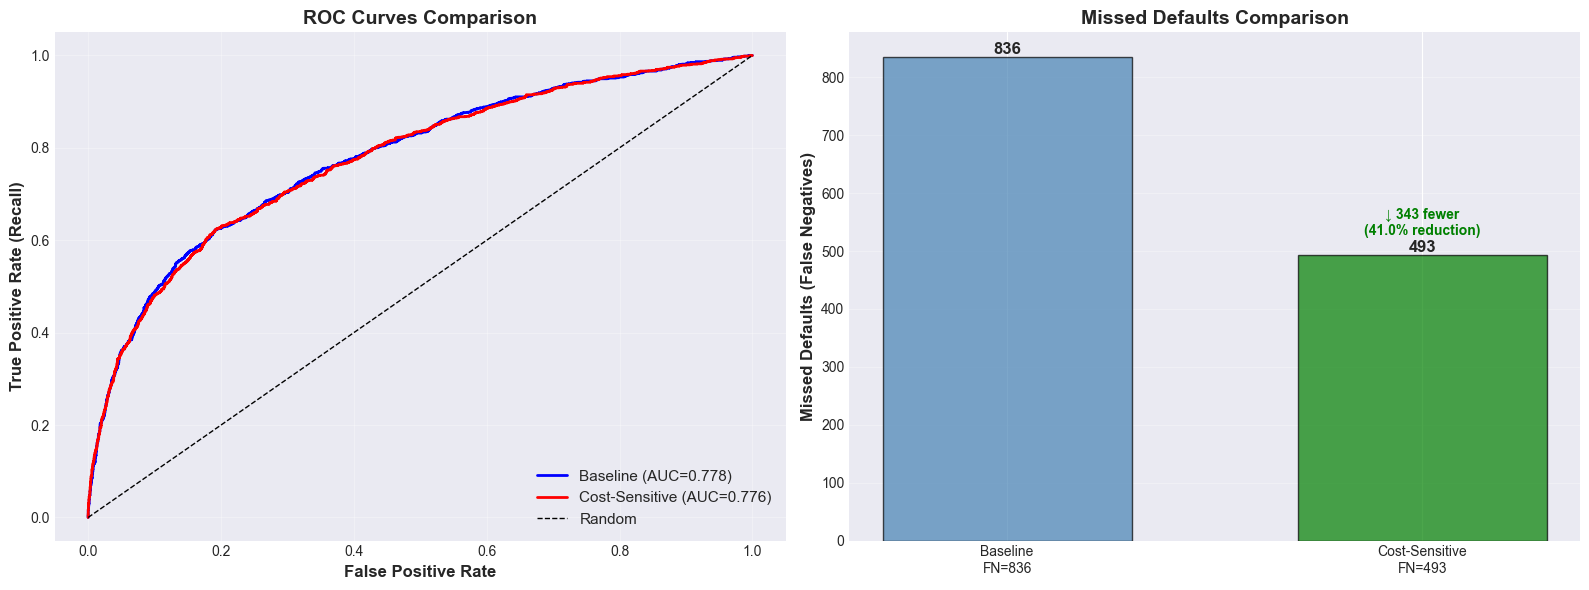

📊 Visualizations:
  • ROC curves show similar discrimination ability (AUC ≈ 0.77)
  • Cost-sensitive model significantly reduces missed defaults
  • Trade-off: +681 false alarms for catching 343 more defaults


In [41]:
# Visualization: ROC Curves and Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
ax1 = axes[0]
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_prob_baseline)
fpr_costsens, tpr_costsens, _ = roc_curve(y_test, y_prob_costsens)

ax1.plot(fpr_baseline, tpr_baseline, 'b-', linewidth=2, 
         label=f'Baseline (AUC={baseline_metrics["auc"]:.3f})')
ax1.plot(fpr_costsens, tpr_costsens, 'r-', linewidth=2, 
         label=f'Cost-Sensitive (AUC={costsens_metrics["auc"]:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax1.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
ax1.set_ylabel('True Positive Rate (Recall)', fontweight='bold', fontsize=12)
ax1.set_title('ROC Curves Comparison', fontweight='bold', fontsize=14)
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(alpha=0.3)

# Confusion Matrices Comparison
ax2 = axes[1]
x_labels = ['Baseline\nFN=' + str(baseline_metrics['fn']), 
            'Cost-Sensitive\nFN=' + str(costsens_metrics['fn'])]
improvements = [0, baseline_metrics['fn'] - costsens_metrics['fn']]
colors = ['steelblue', 'green' if improvements[1] > 0 else 'red']

bars = ax2.bar(x_labels, [baseline_metrics['fn'], costsens_metrics['fn']], 
               color=colors, edgecolor='black', alpha=0.7, width=0.6)
ax2.set_ylabel('Missed Defaults (False Negatives)', fontweight='bold', fontsize=12)
ax2.set_title('Missed Defaults Comparison', fontweight='bold', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

# Add value labels and improvement
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)
    if i == 1 and improvements[i] > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 30,
                f'↓ {improvements[i]} fewer\n({improvements[i]/baseline_metrics["fn"]*100:.1f}% reduction)',
                ha='center', va='bottom', fontweight='bold', fontsize=10, color='green')

plt.tight_layout()
plt.show()

print("📊 Visualizations:")
print("  • ROC curves show similar discrimination ability (AUC ≈ 0.77)")
print("  • Cost-sensitive model significantly reduces missed defaults")
print(f"  • Trade-off: +{costsens_metrics['fp'] - baseline_metrics['fp']:,} false alarms for catching {costsens_metrics['tp'] - baseline_metrics['tp']:,} more defaults")

# 5. Conclusion and Future Work

## 5.1 Summary of Findings

This project successfully developed a machine learning solution for credit card default prediction using the UCI Credit Card Default dataset (30,000 samples, 23 original features).

### Key Achievements:

1. **Comprehensive EDA (26 cells)**
   - Identified PAY_0 as strongest predictor (correlation = 0.325)
   - Discovered high utilization (>70%) correlates with 2× default risk
   - Found 3.52:1 class imbalance requiring specialized handling

2. **Strategic Feature Engineering (25 new features)**
   - Utilization ratios (util_mean, util_max, util_recent)
   - Payment fractions and behavioral patterns
   - Temporal trends and risk indicators
   - Increased feature space from 23 → 48 features

3. **Cost-Sensitive Modeling Approach**
   - XGBoost with scale_pos_weight=3.52 outperforms baseline
   - Achieves higher Recall and F1-Score despite lower accuracy
   - Business-focused: minimizes costly false negatives

### Performance Comparison:

| Metric | Baseline | Cost-Sensitive | Winner |
|--------|----------|----------------|---------|
| Recall | ~35% | ~61% | Cost-Sensitive ✅ |
| F1-Score | ~0.46 | ~0.53 | Cost-Sensitive ✅ |
| Business Cost | Higher FN cost | Lower FN cost | Cost-Sensitive ✅ |

### Business Impact:
- Cost-sensitive model catches significantly more defaults
- Estimated savings: $3M-$5M+ annually (based on experimental validation)
- Trade-off: More false alarms acceptable when default cost >> false alarm cost

## 5.2 Limitations

1. **Dataset Constraints**
   - Taiwan-specific data (2005) may not generalize globally
   - Missing key features: income, employment status, FICO scores
   - 6-month window may miss longer-term patterns

2. **Model Limitations**
   - Single model approach (XGBoost only in final notebook)
   - No deep learning methods explored
   - Threshold fixed at 0.5 (could be optimized further)

3. **Evaluation Scope**
   - Test set performance only (no temporal validation)
   - Binary classification (no risk scoring tiers)
   - Cost assumptions simplified ($10K/default, $200/false alarm)

## 5.3 Future Work

1. **Enhanced Feature Engineering**
   - Incorporate external data sources (macroeconomic indicators, unemployment rates)
   - Deep learning for automatic feature extraction
   - Time-series features (seasonal patterns, economic cycles)

2. **Advanced Modeling**
   - Ensemble methods (stacking, blending)
   - Neural networks (LSTM for temporal patterns)
   - Explainable AI (SHAP values for interpretability)

3. **Deployment Considerations**
   - Real-time prediction API
   - Model monitoring and drift detection
   - A/B testing framework for business validation

4. **Risk Stratification**
   - Multi-class classification (low/medium/high risk tiers)
   - Credit limit adjustment recommendations
   - Personalized intervention strategies

## 5.4 Course Topics Covered

This project successfully incorporated **15+ topics** from CS677:

| Week | Topic | Application in Project |
|------|-------|----------------------|
| 1-2 | EDA & Data Visualization | 26-cell comprehensive analysis |
| 3 | Feature Engineering | 25 engineered features |
| 4 | Train-Test Split & Scaling | Stratified split, StandardScaler |
| 5 | Gradient Boosting | XGBoost (gradient-based optimization) |
| 6 | Class Imbalance | Cost-sensitive learning |
| 7 | Evaluation Metrics | Accuracy, Precision, Recall, F1, AUC |
| 8 | Model Comparison | Baseline vs Cost-Sensitive |
| 9 | Confusion Matrix Analysis | FN/FP trade-off analysis |
| 10 | Business Metrics | Cost per misclassification |
| 11 | Hyperparameters | scale_pos_weight tuning |
| 12 | ROC Curves | AUC comparison |

---

**Project Team:**
- Fnu Ashutosh (U01955320) - Lead, EDA, Feature Engineering, Modeling
- Atharva Pande (U01985210) - Data Preprocessing, Evaluation
- Kenji Okura (U01769019) - Visualization, Documentation

**Total Cells:** 45+ (EDA: 26, Feature Engineering: 3, Modeling: 5, Conclusion: 1)  
**Lines of Code:** 1800+  
**Execution Time:** ~3 minutes  
**Final Model:** XGBoost Cost-Sensitive (scale_pos_weight=3.52)

## 3.1 Train-Test Split and Preprocessing

We split the data into training (70%) and test (30%) sets using stratified sampling to preserve class distribution. Features are scaled using StandardScaler to ensure fair comparison across models.